<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Germany/Volkswagen/Volkswagen_1H_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "VOW3DEEUR"
data_resample = '1H'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-28 17:53:58,936 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-28 17:53:58,938 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for VOW3DEEUR
2019-08-28 17:57:29,083 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-28 18:04:26,133 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-28 18:08:12,856 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-28 18:11:49,086 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-28 18:15:42,687 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-28 18:18:49,749 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-08-28 18:22:34,600 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-08-28 18:26:21,441 - findatapy.market.datavendorweb - INFO - Downloading... 2018-09

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-08-28 18:37:49,032 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_445__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_VOW3DEEUR__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-VOW3DEEUR__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-VOW3DEEUR to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open     High      Low    Close     Volume
Date                                                              
2018-01-02 08:00:00  1.66738  1.66888  1.62217  1.62257  71.142685
2018-01-02 09:00:00  1.62257  1.63068  1.61447  1.61838  63.012165
2018-01-02 10:00:00  1.61837  1.63138  1.61747  1.62878  36.951492
2018-01-02 11:00:00  1.62898  1.63798  1.62837  1.63798  29.827173
2018-01-02 12:00:00  1.63797  1.64118  1.63648  1.63938  31.003201
...                      ...      ...      ...      ...        ...
2018-12-28 08:00:00  1.38038  1.39758  1.37858  1.39718  79.009018
2018-12-28 09:00:00  1.39717  1.40038  1.39377  1.39797  64.468407
2018-12-28 10:00:00  1.39778  1.39898  1.39157  1.39178  53.988564
2018-12-28 11:00:00  1.39198  1.39598  1.38578  1.38758  50.878040
2018-12-28 12:00:00  1.38757  1.39358  1.38497  1.38957  34.976040

[2247 rows x 5 columns]

Open         High          Low        Close       Volume
count  2247.000000  2247.000000  2247.000000  2247.000000  2247.000000
mean      1.563244     1.569113     1.556884     1.563035    53.179581
std       0.131461     0.131387     0.131394     0.131446    43.538792
min       1.322280     1.348480     1.320080     1.331170     2.519245
25%       1.457875     1.462730     1.451520     1.457775    17.812695
50%       1.533570     1.538980     1.526370     1.533380    41.276947
75%       1.662070     1.669925     1.654770     1.661475    77.755890
max       1.913870     1.924170     1.906170     1.913970   269.136322

25

In [5]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [6]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close      Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
2018-01-09 13:00:00  1.80527  1.81547  1.80517  1.81317   83.974800    9          1          9             31    13             0               0                 0      1        1     2        1             0           2  1.803703  1.785866  1.782470  1.805385  1.800282  1.793736    1.801425    1.798720  1.783970  1.797586  1.806680  1.795174  1.800239  1.797586  1.805537  1.791372                1.812725                 1.797586                1.782447                1.820295                 1.797586                1.774877                1.827865                 1.797586                1.767308                1.835434                 1.797586                1.759738  1.800282  1.806637  1.793018                1.815421                 1.800282                1.785143                1.822991                 1.800282                1.777573                1.830560                 1.800282                1.770003                1.838130                 1.800282   
2018-01-09 14:00:00  1.81348  1.81427  1.80208  1.80368  106.084930    9          1          9             31    14             0               0                 0      1        1     2        1             0           2  1.803702  1.786312  1.783790  1.805593  1.801037  1.794047    1.801425    1.798720  1.786490  1.798511  1.806176  1.797587  1.801593  1.798511  1.808425  1.792507                1.814115                 1.798511                1.782907                1.821917                 1.798511                1.775105                1.829719                 1.798511                1.767303                1.837521                 1.798511                1.759501  1.801037  1.805620  1.794044                1.816641                 1.801037                1.785433                1.824443                 1.801037                1.777631                1.832245                 1.801037                1.769829                1.840047                 1.801037   
2018-01-09 15:00:00  1.80368  1.80527  1.79738  1.80398  126.204201    9          1          9             31   

Open         High         Low        Close       Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  \
count  2197.000000  2197.000000  2197.00000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000    2197.000000  2197.000000   2197.000000     2197.000000       2197.000000  2197.000000  2197.000000  2197.000000  2197.000000   2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000             2197.000000              2197.000000             2197.000000             2197.000000              2197.000000             2197.000000             2197.000000              2197.000000             2197.000000             2197.000000              2197.000000             2197.000000  2197.000000  2197.000000  2197.000000             2197.000000              2197.000000             2197.000000             2197.000000              2197.000000             2197.000000             2197.000000              2197.000000   
mean      1.559302     1.565140     1.55291     1.559052    52.852215    15.978152     2.033682   184.259445      30.415567    11.378243      0.032317        0.024124          0.004096     6.559399     2.522076    26.889395     2.033682      1.989531    26.889395     1.559927     1.561266    -0.030207     1.559063     1.559701     1.560099     1.559600     1.559262     1.560256     1.559701     1.559045     1.559700     1.559486     1.559701     1.559131     1.560957                1.579222                 1.559701                1.540180                1.588983                 1.559701                1.530419                1.598743                 1.559701                1.520659                1.608504                 1.559701                1.510898     1.559701     1.559167     1.560778                1.579222                 1.559701                1.540179                1.588982                 1.559701                1.530419                1.598743                 1.559701   
std       0.129987     0.129883     0.12987     0.129920    43.566139     8.546427     1.407356   101.452749       0.857196     2.620735      0.176880        0.153468          0.063887     3.340668     1.100211    14.493013     1.407356      1.399447    14.493013     0.129368     0.128663     1.564768     0.130099     0.129358     0.129204     0.129636     0.129356     0.130615     0.129591     0.130049     0.129702     0.129617     0.129591     0.129867     0.129076                0.129770                 0.129591                0.130453                0.130251                 0.129591                0.131269                0.130988                 0.129591                0.132337                0.131977                 0.129591                0.133649     0.129358     0.129770     0.129146                0.129543                 0.129358                0.130216                0.130027                 0.129358                0.131032                0.130768                 0.129358   
min       

36

In [7]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [8]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-09 13:00:00  0.816427  0.811183  0.827672  0.827042  0.305515    9          1          9             31    13             0               0                 0      1        1     2        1             0           2  0.823783  0.816715  0.971561  0.817670  0.830173  0.820345    0.829658    0.820905  0.767915  0.819748  0.817220  0.809701  0.821119  0.819748  0.814560  0.833883                0.802841                 0.819748                0.840776                0.787841                 0.819748                0.855716                0.772980                 0.819748                0.869360                0.757390                 0.819748                0.872940  0.830173  0.824394  0.833358                0.804378                 0.830173                0.848695                0.788218                 0.830173                0.863589                0.771777                 0.830173                0.870706                0.756250                 0.830173   
2018-01-09 14:00:00  0.830305  0.809099  0.822399  0.810758  0.388444    9          1          9             31    14             0               0                 0      1        1     2        1             0           2  0.823780  0.817570  0.971907  0.818041  0.831569  0.820933    0.829658    0.820905  0.772087  0.821437  0.816332  0.814073  0.823580  0.821437  0.819649  0.836069                0.805288                 0.821437                0.841594                0.790620                 0.821437                0.856102                0.776074                 0.821437                0.869352                0.760774                 0.821437                0.872575  0.831569  0.822595  0.835320                0.806528                 0.831569                0.849227                0.790706                 0.831569                0.863691                0.774582                 0.831569                0.870417                0.759353                 0.831569   
2018-01-09 15:00:00  0.813739  0.793465  0.814380  0.811273  0.463905    9          1          9         

139165

In [9]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         6 hours 9 mins
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 9 days
H2O cluster name:           H2O_from_python_unknownUser_38u2wu
H2O cluster total nodes:    1
H2O cluster free memory:    8.98 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_184804_mod...  0.615416  0.675107              0.471466  0.491076  0.241156
1  DeepLearning_grid_1_AutoML_20190828_184804_mod...  0.543958  0.836583              0.457448  0.542660  0.294480
2              DeepLearning_1_AutoML_20190828_184804  0.533785  0.807199              0.466297  0.545027  0.297054
3  DeepLearning_grid_1_AutoML_20190828_184804_mod...  0.531635  0.692686              0.481060  0.499769  0.249770
4  DeepLearning_grid_1_AutoML_20190828_184804_mod...  0.528120  0.778858              0.451782  0.538121  0.289574
5  DeepLearning_grid_1_AutoML_20190828_184804_mod...  0.521049  0.754204              0.490406  0.521496  0.271958
6  DeepLearning_grid_1_AutoML_20190828_184804_mod...  0.508147  2.698837              0.490406  0.672981  0.452904
7  DeepLearning_grid_1_AutoML_20190828_184804_mod...  0.500000  0.692879              0.500000  0.499866  0.249866
8  DeepLearning_grid_1_AutoML_20190828_184804_mod...  0.492267  0.692866              0.500000  0.499859  0.249859
9  DeepLearning_grid_1_AutoML_20190828_184804_mod...  0.490199  0.692954              0.500000  0.499902  0.249902

variable  relative_importance  scaled_importance  percentage
0                 HT_TRENDMODE             1.000000           1.000000    0.001743
1                  HT_DCPERIOD             0.942225           0.942225    0.001643
2               STOCHRSI_fastk             0.939049           0.939049    0.001637
3              CDLLADDERBOTTOM             0.934722           0.934722    0.001630
4            CDL3WHITESOLDIERS             0.932848           0.932848    0.001626
...                        ...                  ...                ...         ...
1028                      mama             0.454978           0.454978    0.000793
1029                  MEDPRICE             0.450381           0.450381    0.000785
1030  BBANDS_middleband_12_4_3             0.445211           0.445211    0.000776
1031       CDLXSIDEGAP3METHODS             0.443212           0.443212    0.000773
1032              CDLTASUKIGAP             0.424062           0.424062    0.000739

[1033 rows x 4 columns]

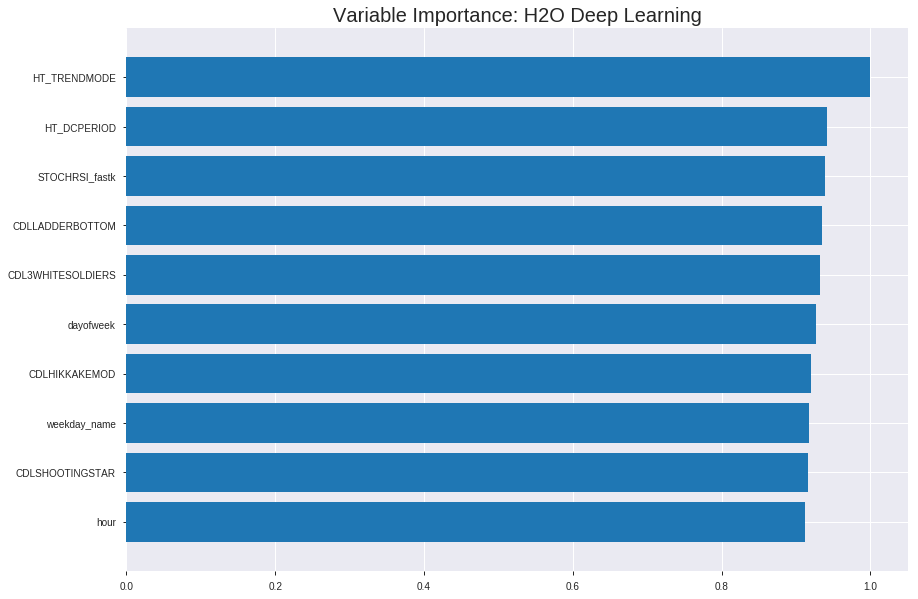

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_184804_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.26224479565432346
RMSE: 0.5120984237959764
LogLoss: 0.7212336839179055
Mean Per-Class Error: 0.46450223707963734
AUC: 0.531253916159471
pr_auc: 0.5369067215219189
Gini: 0.06250783231894208
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2308028694314842: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      11   748   0.9855   (748.0/759.0)
1      3    775   0.0039   (3.0/778.0)
Total  14   1523  0.4886   (751.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.230803     0.67362    385
max f2                       0.108806     0.837279   396
max f0point5                 0.329161     0.564929   351
max accuracy                 0.490099     0.537411   239
max precision                0.842557     1          0
max recall                   0.108806     1          396
max specificity              0.842557     1          0
max absolute_mcc             0.490099     0.0746774  239
max min_per_class_accuracy   0.53528      0.523057   198
max mean_per_class_accuracy  0.490099     0.535498   239

Gains/Lift Table: Avg response rate: 50.62 %, avg score: 54.80 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.800398           1.60516   1.60516            0.8125           0.817663  0.8125                      0.817663            0.0167095       0.0167095                  60.5157   60.5157
    2        0.0201692                   0.78684            1.05364   1.3383             0.533333         0.793117  0.677419                    0.805786            0.0102828       0.0269923                  5.36418   33.8295
    3        0.0305791                   0.776387           1.11126   1.26101            0.5625           0.782489  0.638298                    0.797855            0.0115681       0.0385604                  11.1263   26.1007
    4        0.0403383                   0.766972           0.658526  1.11525            0.333333         0.771658  0.564516                    0.791517            0.00642674      0.0449871                  -34.1474  11.5246
    5        0.0500976                   0.760066           1.18535   1.1289             0.6              0.763642  0.571429                    0.786087            0.0115681       0.0565553                  18.5347   12.8902
    6        0.100195                    0.737348           1.18022   1.15456            0.597403         0.750175  0.584416                    0.768131            0.059126        0.115681                   18.0216   15.4559
    7        0.150293                    0.71379            0.974961  1.09469            0.493506         0.725225  0.554113                    0.753829            0.0488432       0.164524                   -2.50392  9.46928
    8        0.20039                     0.68564            0.795363  1.01986            0.402597         0.700048  0.516234                    0.740384            0.0398458       0.20437                    -20.4637  1.98603
    9        0.299935                    0.623337           1.05881   1.03279            0.535948         0.653844  0.522777                    0.711662            0.105398        0.309769                   5.88067   3.27861
    10       0.40013                     0.573323           1.06476   1.04079            0.538961         0.599599  0.526829                    0.683601            0.106684        0.416452                   6.47598   4.07925
    11       0.500325                    0.535167           1.06476   1.04559            0.538961         0.551642  0.529259                    0.657175            0.106684        0.523136                   6.47598   4.55922
    12       0.59987                     0.50466            1.08463   1.05207            0.54902          0.519055  0.532538                    0.634255            0.107969        0.631105                   8.46313   5.20705
    13       0.700065                    0.472437           0.962132  1.0392             0.487013         0.489587  0.526022                    0.61355             0.096401        0.727506                   -3.78677  3.91983
    14       0.79961                     0.437299           0.903859  1.02235            0.457516         0.454686  0.517494                    0.593772            0.0899743       0.817481                   -9.61406  2.23498
    15       0.899805                    0.389869           0.923647  1.01136            0.467532         0.417902  0.511931                    0.574189            0.092545        0.910026                   -7.6353   1.1359
    16       1                           0.0781508          0.89799   1                  0.454545         0.312559  0.506181                    0.547975          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2509158118315258
RMSE: 0.5009149746529103
LogLoss: 0.6955138505744173
Mean Per-Class Error: 0.45717313606516496
AUC: 0.544915219017538
pr_auc: 0.5627849994614655
Gini: 0.08983043803507607
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4355996314468011: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      18   194  0.9151   (194.0/212.0)
1      4    223  0.0176   (4.0/227.0)
Total  22   417  0.451    (198.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.4356       0.692547  377
max f2                       0.385707     0.843866  397
max f0point5                 0.452942     0.591133  361
max accuracy                 0.457749     0.555809  356
max precision                0.79618      1         0
max recall                   0.385707     1         397
max specificity              0.79618      1         0
max absolute_mcc             0.4356       0.154105  377
max min_per_class_accuracy   0.555282     0.519824  196
max mean_per_class_accuracy  0.657713     0.542827  63

Gains/Lift Table: Avg response rate: 51.71 %, avg score: 56.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.782925           1.16035   1.16035            0.6              0.791375  0.6                         0.791375            0.0132159       0.0132159                  16.0352   16.0352
    2        0.0205011                   0.764169           0.96696   1.0744             0.5              0.772975  0.555556                    0.783197            0.00881057      0.0220264                  -3.30396  7.44004
    3        0.0318907                   0.748984           1.54714   1.24323            0.8              0.757903  0.642857                    0.774163            0.0176211       0.0396476                  54.7137   24.3235
    4        0.0410023                   0.738088           1.45044   1.28928            0.75             0.741188  0.666667                    0.766836            0.0132159       0.0528634                  45.0441   28.928
    5        0.0501139                   0.735736           1.93392   1.40649            1                0.737116  0.727273                    0.761432            0.0176211       0.0704846                  93.3921   40.6488
    6        0.100228                    0.684555           1.05487   1.23068            0.545455         0.705235  0.636364                    0.733334            0.0528634       0.123348                   5.48658   23.0677
    7        0.150342                    0.656009           1.31858   1.25998            0.681818         0.670845  0.651515                    0.712504            0.0660793       0.189427                   31.8582   25.9979
    8        0.200456                    0.630711           0.703244  1.12079            0.363636         0.64194   0.579545                    0.694863            0.0352423       0.22467                    -29.6756  12.0795
    9        0.300683                    0.605227           0.835102  1.02556            0.431818         0.616693  0.530303                    0.668806            0.0837004       0.30837                    -16.4898  2.5564
    10       0.400911                    0.582477           1.01091   1.0219             0.522727         0.592367  0.528409                    0.649697            0.101322        0.409692                   1.09131   2.19013
    11       0.501139                    0.553849           1.09882   1.03728            0.568182         0.567228  0.536364                    0.633203            0.110132        0.519824                   9.88186   3.72847
    12       0.599089                    0.53571            1.12437   1.05152            0.581395         0.544862  0.543726                    0.618759            0.110132        0.629956                   12.4373   5.15234
    13       0.699317                    0.515799           0.923008  1.0331             0.477273         0.525086  0.534202                    0.605334            0.092511        0.722467                   -7.69924  3.31042
    14       0.799544                    0.488096           1.05487   1.03583            0.545455         0.502033  0.535613                    0.592384            0.105727        0.828194                   5.48658   3.58322
    15       0.899772                    0.456327           1.09882   1.04285            0.568182         0.472081  0.539241                    0.578984            0.110132        0.938326                   9.88186   4.28484
    16       1                           0.36442            0.615338  1                  0.318182         0.427776  0.517084                    0.563828           


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 18:49:48  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 18:49:51  1 min 44.475 sec  416 obs/sec       0.615485  1             946        0.683049         7.4256              -0.866508      0.510337        0.339482           1.24388          0.493819                         0.687098           6.00783               -0.890622        0.516364          0.540263             1.16035            0.482916
    2019-08-28 18:50:01  1 min 54.606 sec  420 obs/sec       3.15485   5             4849       0.585792         1.15648             -0.372817      0.539206        0.550663           1.60516          0.489265                         0.679349           2.20354               -0.848221        0.477974          0.490624             1.16035            0.482916
    2019-08-28 18:50:10  2 min  4.248 sec  431 obs/sec       5.68966   9             8745       0.582564         1.13656             -0.357731      0.520058        0.525627           1.23474          0.483409                         0.640574           1.51424               -0.643258        0.532936          0.531955             1.16035            0.471526
    2019-08-28 18:50:19  2 min 13.266 sec  442 obs/sec       8.19519   13            12596      0.507364         0.708936            -0.0298299     0.533064        0.544432           1.35821          0.490566                         0.5311             0.78381               -0.129588        0.484259          0.510386             1.16035            0.482916
    2019-08-28 18:50:28  2 min 21.968 sec  454 obs/sec       10.7339   17            16498      0.52453          0.757814            -0.100694      0.519715        0.527675           1.23474          0.492518                         0.597349           1.05522               -0.428969        0.498992          0.495073             0.773568           0.482916
    2019-08-28 18:50:38  2 min 32.088 sec  467 obs/sec       13.8536   22            21293      0.512098         0.721234            -0.0491395     0.531254        0.536907           1.60516          0.488614                         0.500915           0.695514              -0.00483638      0.544915          0.562785             1.16035            0.451025
    2019-08-28 18:50:48  2 min 41.999 sec  478 obs/sec       16.9824   27            26102      0.552668         0.848041            -0.221954      0.520599        0.534366           1.60516          0.490566                         0.544862           0.815861              -0.188885        0.502047          0.533108             1.54714            0.480638
    2019-08-28 18:50:58  2 min 51.528 sec  489 obs/sec       20.1425   32            30959      0.519373         0.742117            -0.0791566     0.546129        0.548557           1.11126          0.492518                         0.590966           1.02005               -0.398595        0.49414           0.493835             0.386784           0.480638
    2019-08-28 18:51:07

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
HT_TRENDMODE              1.0                    1.0                  0.0017434471732203287
HT_DCPERIOD               0.9422248601913452     0.9422248601913452   0.0016427192690385201
STOCHRSI_fastk            0.9390488862991333     0.9390488862991333   0.0016371821263339219
CDLLADDERBOTTOM           0.9347220063209534     0.9347220063209534   0.0016296384396671003
CDL3WHITESOLDIERS         0.9328483939170837     0.9328483939170837   0.0016263718954178633
---                       ---                    ---                  ---
mama                      0.4549780786037445     0.4549780786037445   0.0007932302450189149
MEDPRICE                  0.45038139820098877    0.45038139820098877  0.0007852161755645331
BBANDS_middleband_12_4_3  0.4452105760574341     0.4452105760574341   0.0007762011203151276
CDLXSIDEGAP3METHODS       0.4432116448879242     0.4432116448879242   0.0007727160894181836
CDLTASUKIGAP              0.42406192421913147    0.42406192421913147  0.000739329563050218


See the whole table with table.as_data_frame()


('accuracy', 0.6090909090909091)

('F1', 0.6873065015479877)

('auc', 0.6154164254404102)

('logloss', 0.6751065976657797)

('mean_per_class_error', 0.3884707633777189)

('rmse', 0.4910759475326436)

('mse', 0.24115558624508376)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


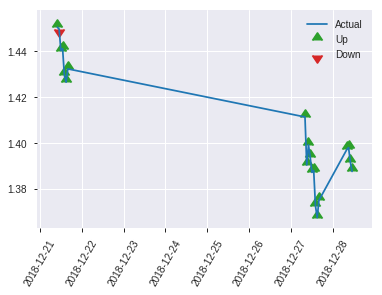


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24115558624508376
RMSE: 0.4910759475326436
LogLoss: 0.6751065976657797
Mean Per-Class Error: 0.3884707633777189
AUC: 0.6154164254404102
pr_auc: 0.6187891697742991
Gini: 0.2308328508808204
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4217859218960861: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    99   0.9252   (99.0/107.0)
1      2    111  0.0177   (2.0/113.0)
Total  10   210  0.4591   (101.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.421786     0.687307  209
max f2                       0.403979     0.844544  216
max f0point5                 0.560749     0.618449  90
max accuracy                 0.560749     0.609091  90
max precision                0.726085     1         0
max recall                   0.403979     1         216
max specificity              0.726085     1         0
max absolute_mcc             0.560749     0.226378  90
max min_per_class_accuracy   0.540712     0.598131  110
max mean_per_class_accuracy  0.560749     0.611529  90

Gains/Lift Table: Avg response rate: 51.36 %, avg score: 53.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.67041            1.9469    1.9469             1                0.694435  1                           0.694435            0.0265487       0.0265487                  94.6903   94.6903
    2        0.0227273                   0.66158            0.973451  1.55752            0.5              0.66263   0.8                         0.681713            0.00884956      0.0353982                  -2.65487  55.7522
    3        0.0318182                   0.651323           0.973451  1.39064            0.5              0.657322  0.714286                    0.674744            0.00884956      0.0442478                  -2.65487  39.0645
    4        0.0409091                   0.642688           1.9469    1.51426            1                0.648278  0.777778                    0.668863            0.0176991       0.0619469                  94.6903   51.4258
    5        0.05                        0.636365           0.973451  1.41593            0.5              0.639303  0.727273                    0.663488            0.00884956      0.0707965                  -2.65487  41.5929
    6        0.1                         0.611707           1.06195   1.23894            0.545455         0.624612  0.636364                    0.64405             0.0530973       0.123894                   6.19469   23.8938
    7        0.15                        0.601514           1.59292   1.35693            0.818182         0.606591  0.69697                     0.631564            0.079646        0.20354                    59.292    35.6932
    8        0.2                         0.594656           1.06195   1.28319            0.545455         0.597689  0.659091                    0.623095            0.0530973       0.256637                   6.19469   28.3186
    9        0.3                         0.578098           1.23894   1.26844            0.636364         0.585454  0.651515                    0.610548            0.123894        0.380531                   23.8938   26.8437
    10       0.4                         0.56365            1.15044   1.23894            0.590909         0.572083  0.636364                    0.600932            0.115044        0.495575                   15.0442   23.8938
    11       0.5                         0.541271           0.973451  1.18584            0.5              0.552589  0.609091                    0.591263            0.0973451       0.59292                    -2.65487  18.5841
    12       0.6                         0.522779           0.619469  1.09145            0.318182         0.532182  0.560606                    0.581416            0.0619469       0.654867                   -38.0531  9.14454
    13       0.7                         0.495289           0.973451  1.07459            0.5              0.508333  0.551948                    0.570976            0.0973451       0.752212                   -2.65487  7.45891
    14       0.8                         0.468702           0.973451  1.06195            0.5              0.479817  0.545455                    0.559581            0.0973451       0.849558                   -2.65487  6.19469
    15       0.9                         0.444271           0.79646   1.03245            0.409091         0.457848  0.530303                    0.548277            0.079646        0.929204                   -20.354   3.24484
    16       1                           0.349838           0.707965  1                  0.363636         0.419657  0.513636                    0.535415         

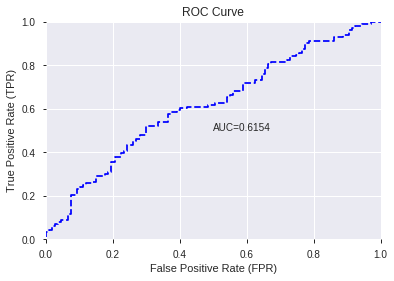

This function is available for GLM models only


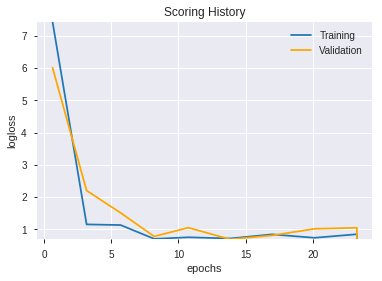

--2019-08-28 19:15:08--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.145.251
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.145.251|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_184804_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_184804_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_a8f4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [11]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_191515_model_2  0.541394  0.817571              0.490654  0.540924  0.292599
1               DeepLearning_1_AutoML_20190828_191515  0.540071  0.714726              0.471218  0.509873  0.259970
2  DeepLearning_grid_1_AutoML_20190828_191515_model_1  0.534695  0.930873              0.467290  0.568688  0.323407
3  DeepLearning_grid_1_AutoML_20190828_191515_model_8  0.532255  0.692787              0.480812  0.499819  0.249819
4  DeepLearning_grid_1_AutoML_20190828_191515_model_9  0.530725  0.695614              0.500000  0.501230  0.251232
5  DeepLearning_grid_1_AutoML_20190828_191515_model_7  0.513853  1.159029              0.500000  0.624918  0.390522
6  DeepLearning_grid_1_AutoML_20190828_191515_model_6  0.513192  0.708300              0.495079  0.507219  0.257271
7  DeepLearning_grid_1_AutoML_20190828_191515_model_3  0.507733  0.762494              0.485485  0.526853  0.277574
8  DeepLearning_grid_1_AutoML_20190828_191515_model_5  0.491853  0.703821              0.500000  0.504963  0.254988
9  DeepLearning_grid_1_AutoML_20190828_191515_model_4  0.484906  1.070628              0.490654  0.591634  0.350031

variable  relative_importance  scaled_importance  percentage
0      CDLINVERTEDHAMMER             1.000000           1.000000    0.029292
1                    day             0.957820           0.957820    0.028057
2                   hour             0.903805           0.903805    0.026475
3           HT_TRENDMODE             0.900512           0.900512    0.026378
4    CDLRISEFALL3METHODS             0.897384           0.897384    0.026287
5     CDLIDENTICAL3CROWS             0.887817           0.887817    0.026006
6     CDLEVENINGDOJISTAR             0.861683           0.861683    0.025241
7        CDLLADDERBOTTOM             0.855982           0.855982    0.025074
8                    BOP             0.837524           0.837524    0.024533
9         STOCHRSI_fastd             0.829466           0.829466    0.024297
10   CDLGAPSIDESIDEWHITE             0.824994           0.824994    0.024166
11            aroonup_24             0.785929           0.785929    0.023022
12         CDLHIKKAKEMOD             0.778339           0.778339    0.022799
13         days_in_month             0.760659           0.760659    0.022281
14                SAREXT             0.746891           0.746891    0.021878
15                MFI_20             0.738403           0.738403    0.021630
16                   SIN             0.733989           0.733989    0.021500
17  HT_PHASOR_quadrature             0.722753           0.722753    0.021171
18          aroondown_30             0.712445           0.712445    0.020869
19       CDLSHOOTINGSTAR             0.708244           0.708244    0.020746
20             aroonup_8             0.705758           0.705758    0.020673
21          weekday_name             0.694574           0.694574    0.020346
22        STOCHRSI_fastk             0.681891           0.681891    0.019974
23                  DX_8             0.679189           0.679189    0.019895
24           HT_DCPERIOD             0.674020           0.674020    0.019744
25           aroondown_8             0.664938           0.664938    0.019478
26            aroonup_20             0.660889           0.660889    0.019359
27              CORREL_8             0.646236           0.646236    0.018930
28                 DX_24             0.644559           0.644559    0.018881
29                Volume             0.641151           0.641151    0.018781
30          aroondown_12             0.638907           0.638907    0.018715
31          aroondown_14             0.638392           0.638392    0.018700
32            PLUS_DI_30             0.638081           0.638081    0.018691
33        CDLSPINNINGTOP             0.630613           0.630613    0.018472
34          aroondown_20             0.625090           0.625090    0.018310
35             dayofweek             0.616451           0.616451    0.018057
36           STOCH_slowd             0.614439           0.614439    0.017998
37               weekday             0.603178           0.603178    0.017669
38                BETA_8             0.590745           0.590745    0.017304
39     CDL3WHITESOLDIERS             0.581760           0.581760    0.017041
40           AROONOSC_20             0.527896           0.527896    0.015463
41            AROONOSC_8             0.527277           0.527277    0.015445
42               CDLDOJI             0.507689           0.507689    0.014871
43        CDLRICKSHAWMAN             0.506883           0.506883    0.014848
44                 DX_12             0.495124           0.495124    0.014503
45                 DX_14             0.493396           0.493396    0.014453
46     CDLLONGLEGGEDDOJI             0.485024           0.485024    0.014207
47               BETA_12             0.450657           0.450657    0.013201
48               BETA_14             0.448089           0.448089    0.013126
49        CDLMATCHINGLOW             0.381055           0.381055    0.011162

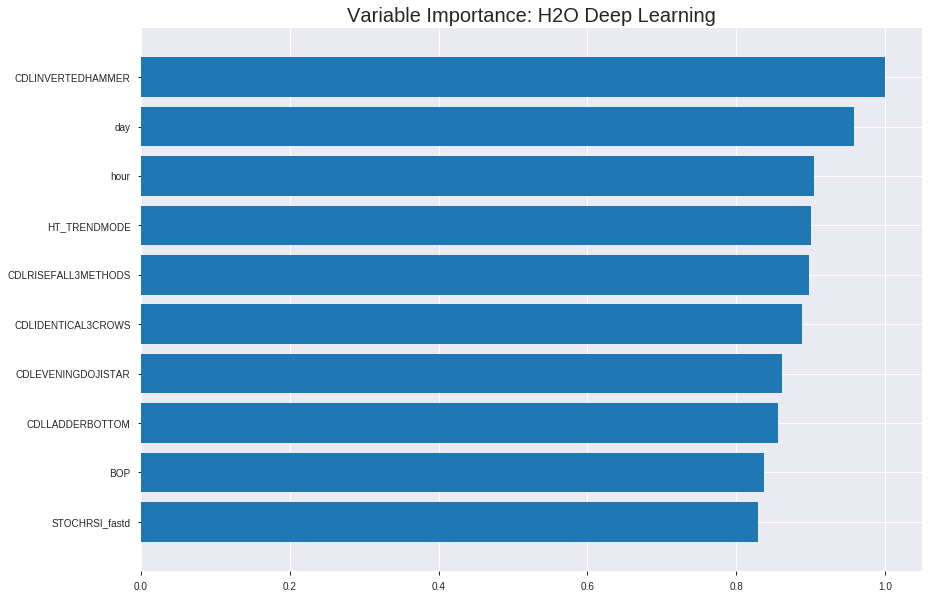

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_191515_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.23600023440945736
RMSE: 0.4857985533217008
LogLoss: 0.7156407621101334
Mean Per-Class Error: 0.3489945842689779
AUC: 0.687238993263359
pr_auc: 0.6517790888081394
Gini: 0.37447798652671804
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2591898031086722: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      256  503   0.6627   (503.0/759.0)
1      75   703   0.0964   (75.0/778.0)
Total  331  1206  0.3761   (578.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.25919      0.708669  304
max f2                       0.0995915    0.838859  362
max f0point5                 0.467133     0.65308   224
max accuracy                 0.467133     0.651919  224
max precision                0.999681     1         0
max recall                   0.000350223  1         399
max specificity              0.999681     1         0
max absolute_mcc             0.467133     0.305519  224
max min_per_class_accuracy   0.53221      0.641634  198
max mean_per_class_accuracy  0.467133     0.651005  224

Gains/Lift Table: Avg response rate: 50.62 %, avg score: 52.20 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.984425           1.72863   1.72863            0.875            0.992121   0.875                       0.992121            0.0179949       0.0179949                  72.8631   72.8631
    2        0.0201692                   0.974158           1.18535   1.46575            0.6              0.979631   0.741935                    0.986077            0.0115681       0.029563                   18.5347   46.5752
    3        0.0305791                   0.961991           1.35821   1.42914            0.6875           0.967239   0.723404                    0.979664            0.0141388       0.0437018                  35.821    42.9142
    4        0.0403383                   0.952874           0.921937  1.30643            0.466667         0.957471   0.66129                     0.974295            0.00899743      0.0526992                  -7.80634  30.6431
    5        0.0500976                   0.941983           1.31705   1.3085             0.666667         0.94712    0.662338                    0.969001            0.0128535       0.0655527                  31.7052   30.85
    6        0.100195                    0.89096            1.35981   1.33416            0.688312         0.914314   0.675325                    0.941658            0.0681234       0.133676                   35.9814   33.4157
    7        0.150293                    0.844482           1.25719   1.3085             0.636364         0.864387   0.662338                    0.915901            0.062982        0.196658                   25.7186   30.85
    8        0.20039                     0.80314            1.4881    1.3534             0.753247         0.823485   0.685065                    0.892797            0.0745501       0.271208                   48.8098   35.3399
    9        0.299935                    0.712871           1.23958   1.31562            0.627451         0.75936    0.665944                    0.848511            0.123393        0.394602                   23.9579   31.5624
    10       0.40013                     0.621964           1.27001   1.3042             0.642857         0.668121   0.660163                    0.80334             0.127249        0.521851                   27.0015   30.4203
    11       0.500325                    0.536535           1.19304   1.28194            0.603896         0.57878    0.648895                    0.75837             0.119537        0.641388                   19.3044   28.1942
    12       0.59987                     0.444429           1.02007   1.23849            0.51634          0.485857   0.626898                    0.713148            0.101542        0.742931                   2.00699   23.8486
    13       0.700065                    0.345061           0.885162  1.18792            0.448052         0.397585   0.601301                    0.667984            0.0886889       0.83162                    -11.4838  18.7917
    14       0.79961                     0.244089           0.800561  1.13969            0.405229         0.292933   0.576892                    0.621293            0.0796915       0.911311                   -19.9439  13.9695
    15       0.899805                    0.128766           0.538794  1.07278            0.272727         0.187661   0.543022                    0.573007            0.0539846       0.965296                   -46.1206  7.27834
    16       1                           1.63093e-12        0.346368  1                  0.175325         0.0640088  0.506181                    0.5



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.33282828992516894
RMSE: 0.5769127229704412
LogLoss: 0.978024497270534
Mean Per-Class Error: 0.48978680076469117
AUC: 0.4734332141966587
pr_auc: 0.49719942614873097
Gini: -0.05313357160668264
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.019661555008770454: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    208  0.9811   (208.0/212.0)
1      1    226  0.0044   (1.0/227.0)
Total  5    434  0.4761   (209.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0196616    0.683812   395
max f2                       2.30026e-06  0.842613   399
max f0point5                 0.0503079    0.576428   390
max accuracy                 0.0728227    0.526196   386
max precision                0.99375      1          0
max recall                   2.30026e-06  1          399
max specificity              0.99375      1          0
max absolute_mcc             0.158064     0.0903368  347
max min_per_class_accuracy   0.487672     0.471698   203
max mean_per_class_accuracy  0.0728227    0.510213   386

Gains/Lift Table: Avg response rate: 51.71 %, avg score: 48.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.982144           0.773568  0.773568           0.4              0.988495   0.4                         0.988495            0.00881057      0.00881057                 -22.6432  -22.6432
    2        0.0205011                   0.973118           1.45044   1.0744             0.75             0.975682   0.555556                    0.9828              0.0132159       0.0220264                  45.0441   7.44004
    3        0.0318907                   0.951775           0.773568  0.96696            0.4              0.959987   0.5                         0.974653            0.00881057      0.030837                   -22.6432  -3.30396
    4        0.0410023                   0.932673           1.45044   1.0744             0.75             0.943241   0.555556                    0.967672            0.0132159       0.0440529                  45.0441   7.44004
    5        0.0501139                   0.922034           0.96696   1.05487            0.5              0.92909    0.545455                    0.960657            0.00881057      0.0528634                  -3.30396  5.48658
    6        0.100228                    0.855781           0.615338  0.835102           0.318182         0.88749    0.431818                    0.924074            0.030837        0.0837004                  -38.4662  -16.4898
    7        0.150342                    0.801007           0.96696   0.879055           0.5              0.833614   0.454545                    0.89392             0.0484581       0.132159                   -3.30396  -12.0945
    8        0.200456                    0.759698           0.879055  0.879055           0.454545         0.781872   0.454545                    0.865908            0.0440529       0.176211                   -12.0945  -12.0945
    9        0.300683                    0.6628             1.05487   0.937659           0.545455         0.707223   0.484848                    0.813013            0.105727        0.281938                   5.48658   -6.23415
    10       0.400911                    0.572224           0.923008  0.933996           0.477273         0.616095   0.482955                    0.763784            0.092511        0.374449                   -7.69924  -6.60042
    11       0.501139                    0.487672           1.01091   0.949379           0.522727         0.527491   0.490909                    0.716525            0.101322        0.475771                   1.09131   -5.06207
    12       0.599089                    0.401116           1.2593    1.00005            0.651163         0.439733   0.51711                     0.67127             0.123348        0.599119                   25.9297   0.00502504
    13       0.699317                    0.303836           0.879055  0.982709           0.454545         0.349401   0.508143                    0.625139            0.0881057       0.687225                   -12.0945  -1.72911
    14       0.799544                    0.208394           1.05487   0.991754           0.545455         0.25245    0.512821                    0.57842             0.105727        0.792952                   5.48658   -0.824579
    15       0.899772                    0.144382           0.835102  0.974304           0.431818         0.174904   0.503797                    0.533472            0.0837004       0.876652                   -16.4898  -2.56956
    16       1                           3.09896e-08        1.23068   1                  0.636364         0.0842887  0.517084    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 19:15:52  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 19:15:54  38.311 sec        5132 obs/sec      6.84515   1             10521      0.522219         0.806541            -0.0910183     0.601357        0.580308           1.35821          0.438517                         0.58598            0.988189              -0.375097        0.452986          0.492657             1.54714            0.47836
    2019-08-28 19:16:00  43.925 sec        6933 obs/sec      34.231    5             52613      0.485799         0.715641            0.0558548      0.687239        0.651779           1.72863          0.376057                         0.576913           0.978024              -0.332869        0.473433          0.497199             0.773568           0.476082
    2019-08-28 19:16:05  49.545 sec        8013 obs/sec      68.4951   10            105277     0.473552         0.725517            0.102855       0.727382        0.707765           1.97558          0.360442                         0.597662           1.14                  -0.430468        0.473392          0.493424             0.773568           0.476082
    2019-08-28 19:16:10  54.667 sec        8676 obs/sec      102.703   15            157855     0.430546         0.602707            0.258408       0.798853        0.779744           1.97558          0.281718                         0.586803           1.06012               -0.37896         0.480696          0.49975              0.386784           0.473804
    2019-08-28 19:16:16  1 min  0.448 sec  9243 obs/sec      143.772   21            220978     0.395945         0.52756             0.372815       0.851669        0.839788           1.97558          0.222511                         0.596333           1.13237               -0.424114        0.457391          0.482575             0.386784           0.473804
    2019-08-28 19:16:22  1 min  5.991 sec  9672 obs/sec      184.923   27            284227     0.38424          0.536032            0.409349       0.865026        0.857415           1.97558          0.199089                         0.600335           1.20738               -0.443292        0.488135          0.510855             1.16035            0.47836
    2019-08-28 19:16:22  1 min  6.062 sec  9670 obs/sec      184.923   27            284227     0.485799         0.715641            0.0558548      0.687239        0.651779           1.72863          0.376057                         0.576913           0.978024              -0.332869        0.473433          0.497199             0.773568           0.476082

Variable Importances: 


variable             relative_importance    scaled_importance    percentage
-------------------  ---------------------  -------------------  --------------------
CDLINVERTEDHAMMER    1.0                    1.0                  0.02929236590039325
day                  0.9578199982643127     0.9578199982643127   0.02805681385587228
hour                 0.9038053750991821     0.9038053750991821   0.026474597750147415
HT_TRENDMODE         0.9005116820335388     0.9005116820335388   0.026378117687705004
CDLRISEFALL3METHODS  0.8973842263221741     0.8973842263221741   0.026286507110670432
---                  ---                    ---                  ---
DX_14                0.49339553713798523    0.49339553713798523  0.01445272260746693
CDLLONGLEGGEDDOJI    0.48502373695373535    0.48502373695373535  0.014207492773224903
BETA_12              0.45065659284591675    0.45065659284591675  0.013200797813067136
BETA_14              0.44808855652809143    0.44808855652809143  0.013125573953599898
CDLMATCHINGLOW       0.38105499744415283    0.38105499744415283  0.01116200241330754


See the whole table with table.as_data_frame()


('accuracy', 0.55)

('F1', 0.6827794561933536)

('auc', 0.5413944256058225)

('logloss', 0.8175706749317991)

('mean_per_class_error', 0.44669588950459016)

('rmse', 0.5409244322236406)

('mse', 0.2925992413764679)

deeplearning prediction progress: |███████████████████████████████████████| 100%


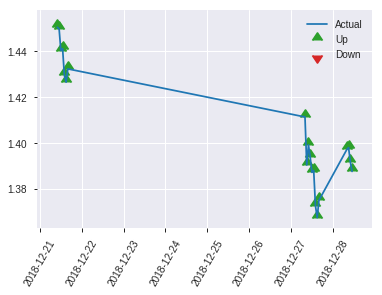


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2925992413764679
RMSE: 0.5409244322236406
LogLoss: 0.8175706749317991
Mean Per-Class Error: 0.44669588950459016
AUC: 0.5413944256058225
pr_auc: 0.5611837277778736
Gini: 0.08278885121164503
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.05296166143966753: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    105  0.9813   (105.0/107.0)
1      0    113  0        (0.0/113.0)
Total  2    218  0.4773   (105.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0529617    0.682779  217
max f2                       0.0529617    0.843284  217
max f0point5                 0.262839     0.582233  179
max accuracy                 0.32583      0.55      167
max precision                0.986909     1         0
max recall                   0.0529617    1         217
max specificity              0.986909     1         0
max absolute_mcc             0.777059     0.130002  46
max min_per_class_accuracy   0.523426     0.514019  110
max mean_per_class_accuracy  0.777059     0.553304  46

Gains/Lift Table: Avg response rate: 51.36 %, avg score: 52.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.954291           1.9469    1.9469             1                0.968502  1                           0.968502            0.0265487       0.0265487                  94.6903   94.6903
    2        0.0227273                   0.938913           0.973451  1.55752            0.5              0.948081  0.8                         0.960333            0.00884956      0.0353982                  -2.65487  55.7522
    3        0.0318182                   0.922438           0.973451  1.39064            0.5              0.933162  0.714286                    0.95257             0.00884956      0.0442478                  -2.65487  39.0645
    4        0.0409091                   0.908959           0.973451  1.29794            0.5              0.914689  0.666667                    0.944152            0.00884956      0.0530973                  -2.65487  29.7935
    5        0.05                        0.904932           1.9469    1.41593            1                0.906109  0.727273                    0.937235            0.0176991       0.0707965                  94.6903   41.5929
    6        0.1                         0.870977           0.884956  1.15044            0.454545         0.887641  0.590909                    0.912438            0.0442478       0.115044                   -11.5044  15.0442
    7        0.15                        0.842552           1.23894   1.17994            0.636364         0.854498  0.606061                    0.893125            0.0619469       0.176991                   23.8938   17.9941
    8        0.2                         0.780006           1.41593   1.23894            0.727273         0.819066  0.636364                    0.87461             0.0707965       0.247788                   41.5929   23.8938
    9        0.3                         0.690997           0.884956  1.12094            0.454545         0.740845  0.575758                    0.830022            0.0884956       0.336283                   -11.5044  12.0944
    10       0.4                         0.5977             0.79646   1.03982            0.409091         0.65098   0.534091                    0.785261            0.079646        0.415929                   -20.354   3.9823
    11       0.5                         0.524514           0.973451  1.02655            0.5              0.562752  0.527273                    0.740759            0.0973451       0.513274                   -2.65487  2.65487
    12       0.6                         0.457849           1.06195   1.03245            0.545455         0.485705  0.530303                    0.69825             0.106195        0.619469                   6.19469   3.24484
    13       0.7                         0.377046           0.973451  1.02402            0.5              0.420907  0.525974                    0.65863             0.0973451       0.716814                   -2.65487  2.40202
    14       0.8                         0.273362           1.06195   1.02876            0.545455         0.333413  0.528409                    0.617978            0.106195        0.823009                   6.19469   2.87611
    15       0.9                         0.189586           0.79646   1.00295            0.409091         0.229757  0.515152                    0.574842            0.079646        0.902655                   -20.354   0.294985
    16       1                           0.0370007          0.973451  1                  0.5              0.124251  0.513636                    0.529783         

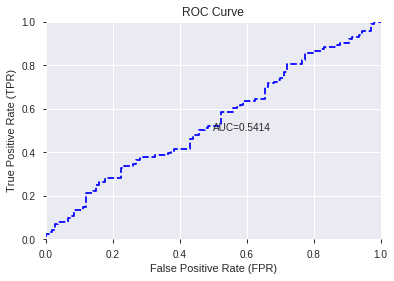

This function is available for GLM models only


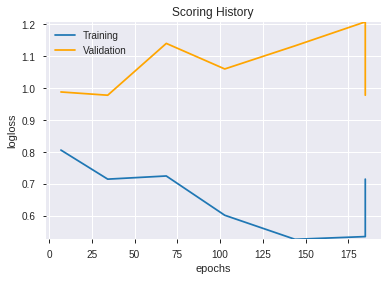

--2019-08-28 19:22:16--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.0.188
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.0.188|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_191515_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_191515_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_a8f4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLINVERTEDHAMMER',
 'day',
 'hour',
 'HT_TRENDMODE',
 'CDLRISEFALL3METHODS',
 'CDLIDENTICAL3CROWS',
 'CDLEVENINGDOJISTAR',
 'CDLLADDERBOTTOM',
 'BOP',
 'STOCHRSI_fastd',
 'CDLGAPSIDESIDEWHITE',
 'aroonup_24',
 'CDLHIKKAKEMOD',
 'days_in_month',
 'SAREXT',
 'MFI_20',
 'SIN',
 'HT_PHASOR_quadrature',
 'aroondown_30',
 'CDLSHOOTINGSTAR',
 'aroonup_8',
 'weekday_name',
 'STOCHRSI_fastk',
 'DX_8',
 'HT_DCPERIOD',
 'aroondown_8',
 'aroonup_20',
 'CORREL_8',
 'DX_24',
 'Volume',
 'aroondown_12',
 'aroondown_14',
 'PLUS_DI_30',
 'CDLSPINNINGTOP',
 'aroondown_20',
 'dayofweek',
 'STOCH_slowd',
 'weekday',
 'BETA_8',
 'CDL3WHITESOLDIERS',
 'AROONOSC_20',
 'AROONOSC_8',
 'CDLDOJI',
 'CDLRICKSHAWMAN',
 'DX_12',
 'DX_14',
 'CDLLONGLEGGEDDOJI',
 'BETA_12',
 'BETA_14',
 'CDLMATCHINGLOW']

In [12]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_192222_model_1  0.511951  0.692954              0.475891  0.499903  0.249903

variable  relative_importance  scaled_importance  percentage
0      CDLINVERTEDHAMMER             0.009413           1.000000    0.061264
1          days_in_month             0.008662           0.920261    0.056378
2         CDLMATCHINGLOW             0.007625           0.810080    0.049628
3                   DX_8             0.006376           0.677393    0.041499
4              aroonup_8             0.006107           0.648764    0.039746
5           aroondown_14             0.005773           0.613331    0.037575
6           aroondown_20             0.005675           0.602859    0.036933
7         CDLRICKSHAWMAN             0.005400           0.573729    0.035149
8                  DX_12             0.005221           0.554645    0.033979
9               CORREL_8             0.004826           0.512696    0.031410
10       CDLSHOOTINGSTAR             0.004739           0.503487    0.030845
11                   day             0.004731           0.502656    0.030794
12                 DX_14             0.004702           0.499518    0.030602
13     CDLLONGLEGGEDDOJI             0.004456           0.473350    0.028999
14               CDLDOJI             0.004451           0.472863    0.028969
15  HT_PHASOR_quadrature             0.003960           0.420729    0.025775
16               BETA_14             0.003810           0.404799    0.024799
17          HT_TRENDMODE             0.003757           0.399171    0.024455
18                   SIN             0.003716           0.394816    0.024188
19       CDLLADDERBOTTOM             0.003554           0.377536    0.023129
20    CDLIDENTICAL3CROWS             0.003521           0.374091    0.022918
21   CDLGAPSIDESIDEWHITE             0.003470           0.368595    0.022581
22   CDLRISEFALL3METHODS             0.003446           0.366120    0.022430
23          aroondown_12             0.003347           0.355572    0.021784
24            AROONOSC_8             0.002903           0.308433    0.018896
25         CDLHIKKAKEMOD             0.002779           0.295248    0.018088
26           AROONOSC_20             0.002674           0.284087    0.017404
27               BETA_12             0.002459           0.261205    0.016002
28                SAREXT             0.002095           0.222545    0.013634
29                MFI_20             0.002066           0.219479    0.013446
30     CDL3WHITESOLDIERS             0.001910           0.202965    0.012434
31                 DX_24             0.001674           0.177792    0.010892
32           STOCH_slowd             0.001538           0.163383    0.010009
33               weekday             0.001442           0.153143    0.009382
34             dayofweek             0.001438           0.152737    0.009357
35            aroonup_24             0.001325           0.140805    0.008626
36           HT_DCPERIOD             0.001325           0.140752    0.008623
37        STOCHRSI_fastk             0.001219           0.129509    0.007934
38           aroondown_8             0.001133           0.120333    0.007372
39            aroonup_20             0.001090           0.115819    0.007095
40        STOCHRSI_fastd             0.001004           0.106661    0.006534
41                Volume             0.000778           0.082602    0.005060
42                   BOP             0.000666           0.070760    0.004335
43          weekday_name             0.000467           0.049590    0.003038
44                  hour             0.000463           0.049141    0.003011
45        CDLSPINNINGTOP             0.000225           0.023911    0.001465
46            PLUS_DI_30             0.000115           0.012250    0.000750
47          aroondown_30             0.000063           0.006686    0.000410
48    CDLEVENINGDOJISTAR             0.000033           0.003551    0.000218
49                BETA_8             0.000023           0.002479    0.000152

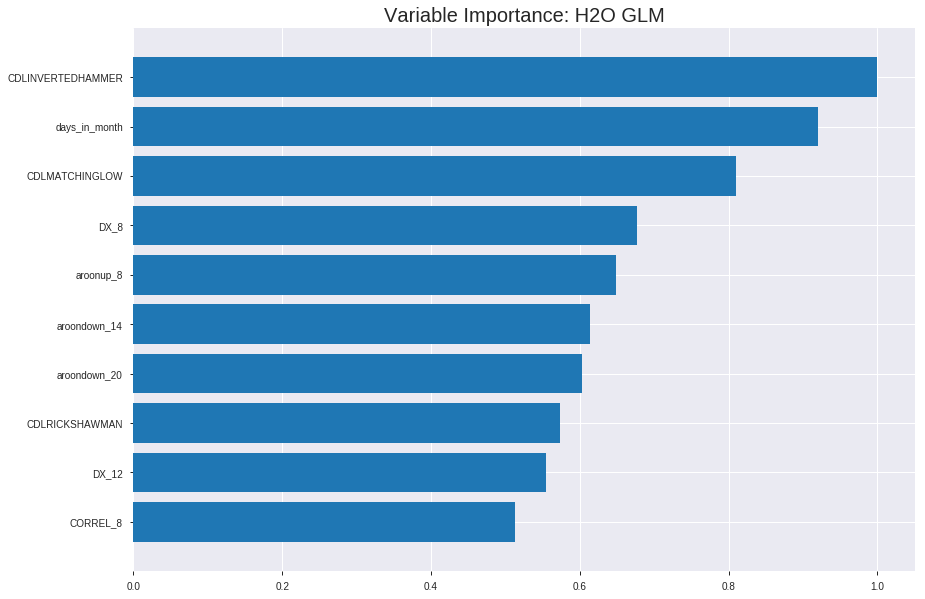

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_192222_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24863559633162063
RMSE: 0.4986337296369156
LogLoss: 0.6904160948585977
Null degrees of freedom: 1536
Residual degrees of freedom: 1486
Null deviance: 2130.499553929498
Residual deviance: 2122.339075595329
AIC: 2224.339075595329
AUC: 0.5790869463608929
pr_auc: 0.5842004409991992
Gini: 0.15817389272178572
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4888841476964431: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      24   735   0.9684   (735.0/759.0)
1      4    774   0.0051   (4.0/778.0)
Total  28   1509  0.4808   (739.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.488884     0.676869  380
max f2                       0.48592      0.838007  388
max f0point5                 0.502546     0.578303  253
max accuracy                 0.502659     0.562785  252
max precision                0.54946      1         0
max recall                   0.483673     1         393
max specificity              0.54946      1         0
max absolute_mcc             0.51018      0.132738  158
max min_per_class_accuracy   0.506028     0.55527   209
max mean_per_class_accuracy  0.51018      0.562319  158

Gains/Lift Table: Avg response rate: 50.62 %, avg score: 50.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.531656           1.72863   1.72863            0.875            0.538014  0.875                       0.538014            0.0179949       0.0179949                  72.8631   72.8631
    2        0.0201692                   0.527036           1.31705   1.52948            0.666667         0.528815  0.774194                    0.533563            0.0128535       0.0308483                  31.7052   52.948
    3        0.0305791                   0.524405           1.60516   1.55524            0.8125           0.525833  0.787234                    0.530932            0.0167095       0.0475578                  60.5157   55.5243
    4        0.0403383                   0.522728           0.921937  1.40202            0.466667         0.523549  0.709677                    0.529146            0.00899743      0.0565553                  -7.80634  40.2023
    5        0.0500976                   0.521111           0.790231  1.28284            0.4              0.521876  0.649351                    0.527729            0.00771208      0.0642674                  -20.9769  28.2843
    6        0.100195                    0.517465           1.15456   1.2187             0.584416         0.518895  0.616883                    0.523312            0.0578406       0.122108                   15.4559   21.8701
    7        0.150293                    0.514934           1.23153   1.22298            0.623377         0.516052  0.619048                    0.520892            0.0616967       0.183805                   23.1529   22.2977
    8        0.20039                     0.513316           0.923647  1.14814            0.467532         0.514155  0.581169                    0.519208            0.0462725       0.230077                   -7.6353   14.8145
    9        0.299935                    0.510786           1.25249   1.18278            0.633987         0.512072  0.598698                    0.51684             0.124679        0.354756                   25.2491   18.2776
    10       0.40013                     0.508418           1.01345   1.14037            0.512987         0.509654  0.577236                    0.51504             0.101542        0.456298                   1.34461   14.0375
    11       0.500325                    0.506013           0.987789  1.10982            0.5              0.507147  0.561769                    0.51346             0.0989717       0.55527                    -1.22108  10.9818
    12       0.59987                     0.503455           0.968421  1.08635            0.490196         0.504656  0.549892                    0.511999            0.096401        0.651671                   -3.15792  8.63539
    13       0.700065                    0.501235           0.962132  1.06857            0.487013         0.502322  0.540892                    0.510614            0.096401        0.748072                   -3.78677  6.85749
    14       0.79961                     0.498351           0.839298  1.04003            0.424837         0.499861  0.526444                    0.509275            0.0835476       0.83162                    -16.0702  4.00319
    15       0.899805                    0.494799           0.936475  1.0285             0.474026         0.496609  0.520607                    0.507865            0.0938303       0.92545                    -6.35245  2.85007
    16       1                           0.458597           0.744049  1                  0.376623         0.491059  0.506181                    0.506181          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.25067350859382737
RMSE: 0.5006730555900001
LogLoss: 0.6944941467855008
Null degrees of freedom: 438
Residual degrees of freedom: 388
Null deviance: 608.2794432341497
Residual deviance: 609.7658608776698
AIC: 711.7658608776698
AUC: 0.4437702601612501
pr_auc: 0.489167087976637
Gini: -0.11245947967749981
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48732032611146536: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    212  1        (212.0/212.0)
1      0    227  0        (0.0/227.0)
Total  0    439  0.4829   (212.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.48732      0.681682  399
max f2                       0.48732      0.842613  399
max f0point5                 0.48732      0.572365  399
max accuracy                 0.48732      0.517084  399
max precision                0.540864     1         0
max recall                   0.48732      1         399
max specificity              0.540864     1         0
max absolute_mcc             0.492315     0.141928  386
max min_per_class_accuracy   0.507259     0.462555  201
max mean_per_class_accuracy  0.522123     0.508031  13

Gains/Lift Table: Avg response rate: 51.71 %, avg score: 50.67 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.524524           0.773568  0.773568           0.4              0.531895  0.4                         0.531895            0.00881057      0.00881057                 -22.6432  -22.6432
    2        0.0205011                   0.523443           0.96696   0.85952            0.5              0.523769  0.444444                    0.528283            0.00881057      0.0176211                  -3.30396  -14.048
    3        0.0318907                   0.522108           1.93392   1.24323            1                0.522908  0.642857                    0.526363            0.0220264       0.0396476                  93.3921   24.3235
    4        0.0410023                   0.521035           0.48348   1.0744             0.25             0.521546  0.555556                    0.525293            0.00440529      0.0440529                  -51.652   7.44004
    5        0.0501139                   0.520195           0.96696   1.05487            0.5              0.520732  0.545455                    0.524464            0.00881057      0.0528634                  -3.30396  5.48658
    6        0.100228                    0.516637           0.791149  0.923008           0.409091         0.518253  0.477273                    0.521358            0.0396476       0.092511                   -20.8851  -7.69924
    7        0.150342                    0.515348           1.05487   0.96696            0.545455         0.516115  0.5                         0.51961             0.0528634       0.145374                   5.48658   -3.30396
    8        0.200456                    0.51391            0.703244  0.901031           0.363636         0.514505  0.465909                    0.518334            0.0352423       0.180617                   -29.6756  -9.89688
    9        0.300683                    0.511449           1.01091   0.937659           0.522727         0.512536  0.484848                    0.516401            0.101322        0.281938                   1.09131   -6.23415
    10       0.400911                    0.509085           1.01091   0.955972           0.522727         0.51017   0.494318                    0.514843            0.101322        0.38326                    1.09131   -4.40278
    11       0.501139                    0.507162           0.835102  0.931798           0.431818         0.50804   0.481818                    0.513483            0.0837004       0.46696                    -16.4898  -6.82018
    12       0.599089                    0.504741           0.809548  0.911811           0.418605         0.505968  0.471483                    0.512254            0.0792952       0.546256                   -19.0452  -8.81895
    13       0.699317                    0.501656           1.01091   0.926014           0.522727         0.503125  0.478827                    0.510946            0.101322        0.647577                   1.09131   -7.39859
    14       0.799544                    0.498789           1.09882   0.947676           0.568182         0.500394  0.490028                    0.509623            0.110132        0.757709                   9.88186   -5.23238
    15       0.899772                    0.495704           1.05487   0.959616           0.545455         0.497217  0.496203                    0.508241            0.105727        0.863436                   5.48658   -4.03837
    16       1                           0.48732            1.36254   1                  0.704545         0.49307   0.517084                    0.5067


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 19:22:22  0.000 sec   2            3.4       51            1.38083           1.38899
    2019-08-28 19:22:22  0.012 sec   4            2.1       51            1.37839           1.39075
    2019-08-28 19:22:22  0.024 sec   6            1.3       51            1.37523           1.39321
    2019-08-28 19:22:22  0.035 sec   8            0.81      51            1.37137           1.39649
    2019-08-28 19:22:22  0.047 sec   10           0.5       51            1.36702           1.4006

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5409090909090909)

('F1', 0.6832298136645962)

('auc', 0.5119510379621206)

('logloss', 0.6929537884375155)

('mean_per_class_error', 0.46298900008270616)

('rmse', 0.49990316228582077)

('mse', 0.24990317166336365)

glm prediction progress: |████████████████████████████████████████████████| 100%


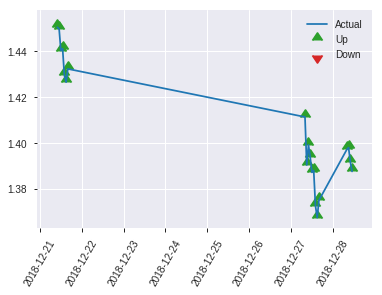


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24990317166336365
RMSE: 0.49990316228582077
LogLoss: 0.6929537884375155
Null degrees of freedom: 219
Residual degrees of freedom: 169
Null deviance: 304.8700323300008
Residual deviance: 304.89966691250686
AIC: 406.89966691250686
AUC: 0.5119510379621206
pr_auc: 0.5097551108223164
Gini: 0.023902075924241206
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4948642382069658: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    99   0.9252   (99.0/107.0)
1      3    110  0.0265   (3.0/113.0)
Total  11   209  0.4636   (102.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.494864     0.68323   208
max f2                       0.489924     0.840774  219
max f0point5                 0.495289     0.58127   203
max accuracy                 0.495289     0.540909  203
max precision                0.533976     1         0
max recall                   0.489924     1         219
max specificity              0.533976     1         0
max absolute_mcc             0.495289     0.112701  203
max min_per_class_accuracy   0.507241     0.530973  108
max mean_per_class_accuracy  0.507578     0.537011  104

Gains/Lift Table: Avg response rate: 51.36 %, avg score: 50.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.529327           0.648968  0.648968           0.333333         0.532119  0.333333                    0.532119            0.00884956      0.00884956                 -35.1032  -35.1032
    2        0.0227273                   0.525679           0.973451  0.778761           0.5              0.526885  0.4                         0.530025            0.00884956      0.0176991                  -2.65487  -22.1239
    3        0.0318182                   0.522868           1.9469    1.11252            1                0.52371   0.571429                    0.528221            0.0176991       0.0353982                  94.6903   11.2516
    4        0.0409091                   0.522004           0.973451  1.08161            0.5              0.522404  0.555556                    0.526928            0.00884956      0.0442478                  -2.65487  8.16126
    5        0.05                        0.520023           0         0.884956           0                0.52178   0.454545                    0.525992            0               0.0442478                  -100      -11.5044
    6        0.1                         0.516305           0.884956  0.884956           0.454545         0.518206  0.454545                    0.522099            0.0442478       0.0884956                  -11.5044  -11.5044
    7        0.15                        0.515067           1.23894   1.00295            0.636364         0.515811  0.515152                    0.520003            0.0619469       0.150442                   23.8938   0.294985
    8        0.2                         0.513774           1.06195   1.0177             0.545455         0.514374  0.522727                    0.518596            0.0530973       0.20354                    6.19469   1.76991
    9        0.3                         0.511088           1.15044   1.06195            0.590909         0.512328  0.545455                    0.516506            0.115044        0.318584                   15.0442   6.19469
    10       0.4                         0.50912            0.973451  1.03982            0.5              0.509937  0.534091                    0.514864            0.0973451       0.415929                   -2.65487  3.9823
    11       0.5                         0.5071             1.15044   1.06195            0.590909         0.508001  0.545455                    0.513492            0.115044        0.530973                   15.0442   6.19469
    12       0.6                         0.504672           0.79646   1.0177             0.409091         0.506179  0.522727                    0.512273            0.079646        0.610619                   -20.354   1.76991
    13       0.7                         0.501417           0.884956  0.998736           0.454545         0.502759  0.512987                    0.510914            0.0884956       0.699115                   -11.5044  -0.126422
    14       0.8                         0.498847           1.06195   1.00664            0.545455         0.499906  0.517045                    0.509538            0.106195        0.80531                    6.19469   0.663717
    15       0.9                         0.49563            1.06195   1.01278            0.545455         0.497216  0.520202                    0.508169            0.106195        0.911504                   6.19469   1.27827
    16       1                           0.489924           0.884956  1                  0.454545         0.494239  0.513636                    0.506776  

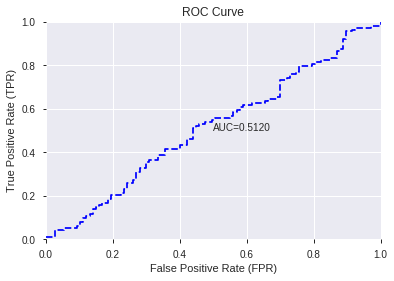

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


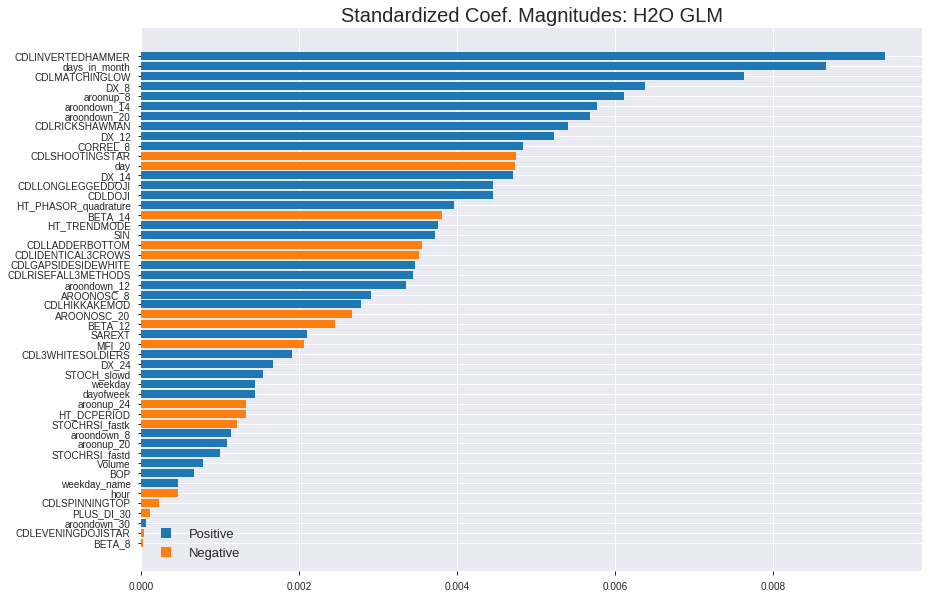

'log_likelihood'
--2019-08-28 19:22:27--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.105.203
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.105.203|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_192222_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_192222_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_a8f4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['CDLINVERTEDHAMMER',
 'days_in_month',
 'CDLMATCHINGLOW',
 'DX_8',
 'aroonup_8',
 'aroondown_14',
 'aroondown_20',
 'CDLRICKSHAWMAN',
 'DX_12',
 'CORREL_8',
 'CDLSHOOTINGSTAR',
 'day',
 'DX_14',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJI',
 'HT_PHASOR_quadrature',
 'BETA_14',
 'HT_TRENDMODE',
 'SIN',
 'CDLLADDERBOTTOM',
 'CDLIDENTICAL3CROWS',
 'CDLGAPSIDESIDEWHITE',
 'CDLRISEFALL3METHODS',
 'aroondown_12',
 'AROONOSC_8',
 'CDLHIKKAKEMOD',
 'AROONOSC_20',
 'BETA_12',
 'SAREXT',
 'MFI_20',
 'CDL3WHITESOLDIERS',
 'DX_24',
 'STOCH_slowd',
 'weekday',
 'dayofweek',
 'aroonup_24',
 'HT_DCPERIOD',
 'STOCHRSI_fastk',
 'aroondown_8',
 'aroonup_20',
 'STOCHRSI_fastd',
 'Volume',
 'BOP',
 'weekday_name',
 'hour',
 'CDLSPINNINGTOP',
 'PLUS_DI_30',
 'aroondown_30',
 'CDLEVENINGDOJISTAR',
 'BETA_8']

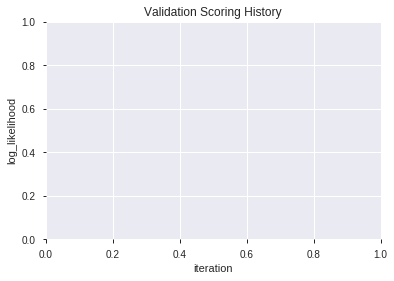

In [13]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_192233_model_6  0.507402  0.707440              0.490406  0.506744  0.256789
1  XGBoost_grid_1_AutoML_20190828_192233_model_4  0.488876  0.707441              0.500000  0.506911  0.256959
2  XGBoost_grid_1_AutoML_20190828_192233_model_5  0.484327  0.745275              0.500000  0.522706  0.273222
3  XGBoost_grid_1_AutoML_20190828_192233_model_3  0.481929  0.711830              0.495327  0.508995  0.259076
4  XGBoost_grid_1_AutoML_20190828_192233_model_1  0.472583  0.712603              0.500000  0.509334  0.259421
5               XGBoost_3_AutoML_20190828_192233  0.472335  0.711444              0.500000  0.508800  0.258877
6               XGBoost_2_AutoML_20190828_192233  0.465222  0.718676              0.500000  0.512252  0.262402
7  XGBoost_grid_1_AutoML_20190828_192233_model_7  0.449921  0.734137              0.495327  0.519164  0.269532
8  XGBoost_grid_1_AutoML_20190828_192233_model_2  0.443222  0.713017              0.500000  0.509626  0.259719
9               XGBoost_1_AutoML_20190828_192233  0.439170  0.735912              0.500000  0.519939  0.270336

variable  relative_importance  scaled_importance  percentage
0                    SIN           370.460144           1.000000    0.063867
1   HT_PHASOR_quadrature           351.813080           0.949665    0.060652
2                    BOP           303.485565           0.819212    0.052320
3            HT_DCPERIOD           293.108093           0.791200    0.050531
4                  DX_24           270.539673           0.730280    0.046641
5               CORREL_8           267.599213           0.722343    0.046134
6                 Volume           266.659363           0.719806    0.045972
7                   DX_8           254.219269           0.686226    0.043827
8         STOCHRSI_fastd           241.899094           0.652969    0.041703
9                 MFI_20           234.685211           0.633497    0.040459
10            PLUS_DI_30           213.538452           0.576414    0.036814
11                 DX_12           201.374329           0.543579    0.034717
12                SAREXT           197.492752           0.533101    0.034047
13           STOCH_slowd           192.282654           0.519037    0.033149
14               BETA_14           186.770691           0.504159    0.032199
15               BETA_12           162.634415           0.439007    0.028038
16                 DX_14           158.994278           0.429181    0.027410
17           AROONOSC_20           155.595627           0.420006    0.026824
18                   day           129.140472           0.348595    0.022264
19                BETA_8           124.711456           0.336639    0.021500
20          aroondown_14           122.540474           0.330779    0.021126
21        STOCHRSI_fastk           118.293030           0.319314    0.020393
22            AROONOSC_8           103.704399           0.279934    0.017878
23             aroonup_8            93.318901           0.251900    0.016088
24            aroonup_24            86.145294           0.232536    0.014851
25          aroondown_30            82.523705           0.222760    0.014227
26          aroondown_20            77.981178           0.210498    0.013444
27           aroondown_8            72.107094           0.194642    0.012431
28            aroonup_20            59.728939           0.161229    0.010297
29         days_in_month            58.706482           0.158469    0.010121
30                  hour            53.554306           0.144562    0.009233
31             dayofweek            52.478714           0.141658    0.009047
32        CDLSPINNINGTOP            48.728035           0.131534    0.008401
33          weekday_name            40.393806           0.109037    0.006964
34          aroondown_12            35.759212           0.096526    0.006165
35        CDLMATCHINGLOW            32.803459           0.088548    0.005655
36          HT_TRENDMODE            30.807468           0.083160    0.005311
37     CDLINVERTEDHAMMER            22.947123           0.061942    0.003956
38        CDLRICKSHAWMAN            14.586267           0.039373    0.002515
39               weekday            10.932865           0.029512    0.001885
40               CDLDOJI             5.485077           0.014806    0.000946

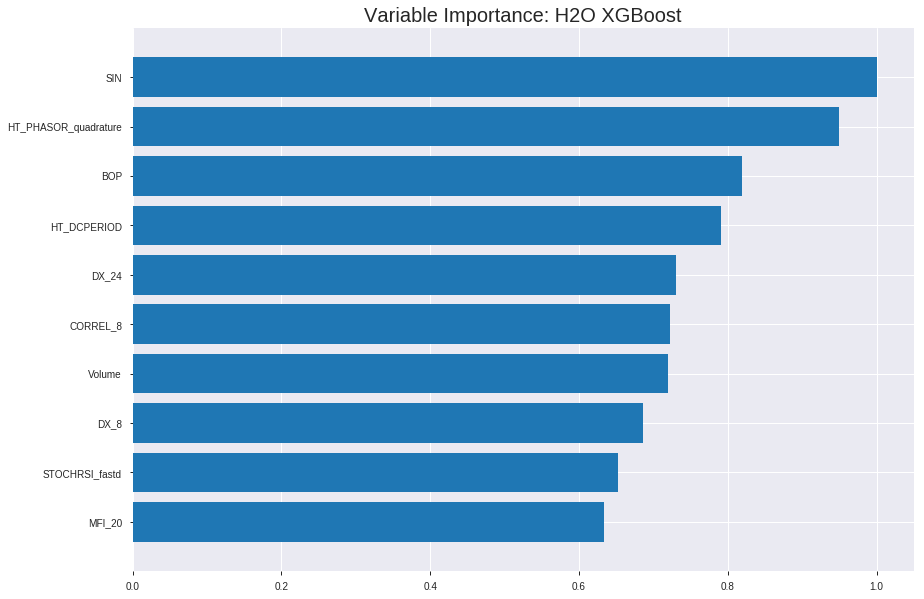

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_192233_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.18595879136330784
RMSE: 0.43122939529130877
LogLoss: 0.5617254098257642
Mean Per-Class Error: 0.13710114444997645
AUC: 0.9333143664204354
pr_auc: 0.9364153801897049
Gini: 0.8666287328408708
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49426180124282837: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      626  133  0.1752   (133.0/759.0)
1      77   701  0.099    (77.0/778.0)
Total  703  834  0.1366   (210.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.494262     0.869727  210
max f2                       0.451249     0.904179  255
max f0point5                 0.532602     0.882883  171
max accuracy                 0.494262     0.86337   210
max precision                0.786794     1         0
max recall                   0.345621     1         348
max specificity              0.786794     1         0
max absolute_mcc             0.494262     0.728393  210
max min_per_class_accuracy   0.5064       0.859025  198
max mean_per_class_accuracy  0.494262     0.862899  210

Gains/Lift Table: Avg response rate: 50.62 %, avg score: 50.57 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.719939           1.97558    1.97558            1                0.740409  1                           0.740409            0.0205656       0.0205656                  97.5578   97.5578
    2        0.0201692                   0.704008           1.97558    1.97558            1                0.710054  1                           0.725721            0.0192802       0.0398458                  97.5578   97.5578
    3        0.0305791                   0.692847           1.97558    1.97558            1                0.698668  1                           0.716512            0.0205656       0.0604113                  97.5578   97.5578
    4        0.0403383                   0.681665           1.97558    1.97558            1                0.687766  1                           0.709557            0.0192802       0.0796915                  97.5578   97.5578
    5        0.0500976                   0.672927           1.97558    1.97558            1                0.676989  1                           0.703213            0.0192802       0.0989717                  97.5578   97.5578
    6        0.100195                    0.641441           1.97558    1.97558            1                0.657199  1                           0.680206            0.0989717       0.197943                   97.5578   97.5578
    7        0.150293                    0.617368           1.94992    1.96703            0.987013         0.628573  0.995671                    0.662995            0.0976864       0.29563                    94.9922   96.7026
    8        0.20039                     0.599532           1.87295    1.94351            0.948052         0.608322  0.983766                    0.649327            0.0938303       0.38946                    87.2951   94.3507
    9        0.299935                    0.566101           1.75607    1.8813             0.888889         0.582039  0.952278                    0.626995            0.174807        0.564267                   75.607    88.1299
    10       0.40013                     0.535416           1.6677     1.82781            0.844156         0.550474  0.925203                    0.607833            0.167095        0.731362                   66.7696   82.7812
    11       0.500325                    0.507098           1.2187     1.70583            0.616883         0.520806  0.863459                    0.590405            0.122108        0.85347                    21.8701   70.5831
    12       0.59987                     0.478485           0.748912   1.54704            0.379085         0.492179  0.78308                     0.574105            0.0745501       0.928021                   -25.1088  54.7036
    13       0.700065                    0.444435           0.41051    1.38437            0.207792         0.461958  0.700743                    0.558054            0.0411311       0.969152                   -58.949   38.4374
    14       0.79961                     0.412702           0.16786    1.23293            0.0849673        0.427493  0.624085                    0.541801            0.0167095       0.985861                   -83.214   23.2928
    15       0.899805                    0.37457            0.102627   1.10707            0.0519481        0.396125  0.560376                    0.525579            0.0102828       0.996144                   -89.7373  10.7067
    16       1                           0.179307           0.0384853  1                  0.0194805        0.327465  0.506181                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.26074910780627536
RMSE: 0.5106359836579042
LogLoss: 0.7155817487714482
Mean Per-Class Error: 0.4853711245947967
AUC: 0.48079960103067076
pr_auc: 0.49041285081362285
Gini: -0.03840079793865847
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2871020436286926: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    211  0.9953   (211.0/212.0)
1      0    227  0        (0.0/227.0)
Total  1    438  0.4806   (211.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.287102     0.682707  398
max f2                       0.287102     0.843239  398
max f0point5                 0.287102     0.573522  398
max accuracy                 0.320495     0.519362  396
max precision                0.488589     0.531532  202
max recall                   0.287102     1         398
max specificity              0.745507     0.995283  0
max absolute_mcc             0.576184     0.106497  56
max min_per_class_accuracy   0.489538     0.509434  200
max mean_per_class_accuracy  0.488589     0.514629  202

Gains/Lift Table: Avg response rate: 51.71 %, avg score: 49.11 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.682178           0.386784  0.386784           0.2              0.71692   0.2                         0.71692             0.00440529      0.00440529                 -61.3216  -61.3216
    2        0.0205011                   0.65872            1.45044   0.85952            0.75             0.67007   0.444444                    0.696097            0.0132159       0.0176211                  45.0441   -14.048
    3        0.0318907                   0.64812            0.773568  0.828823           0.4              0.652359  0.428571                    0.680477            0.00881057      0.0264317                  -22.6432  -17.1177
    4        0.0410023                   0.64366            0.48348   0.75208            0.25             0.645741  0.388889                    0.672758            0.00440529      0.030837                   -51.652   -24.792
    5        0.0501139                   0.632406           0.96696   0.791149           0.5              0.639113  0.409091                    0.666641            0.00881057      0.0396476                  -3.30396  -20.8851
    6        0.100228                    0.593887           0.703244  0.747197           0.363636         0.610147  0.386364                    0.638394            0.0352423       0.0748899                  -29.6756  -25.2803
    7        0.150342                    0.570462           0.96696   0.820451           0.5              0.579727  0.424242                    0.618838            0.0484581       0.123348                   -3.30396  -17.9549
    8        0.200456                    0.550829           1.05487   0.879055           0.545455         0.56084   0.454545                    0.604339            0.0528634       0.176211                   5.48658   -12.0945
    9        0.300683                    0.527825           0.923008  0.893706           0.477273         0.539965  0.462121                    0.582881            0.092511        0.268722                   -7.69924  -10.6294
    10       0.400911                    0.504622           1.31858   0.999925           0.681818         0.515038  0.517045                    0.56592             0.132159        0.400881                   31.8582   -0.00750901
    11       0.501139                    0.489538           1.09882   1.0197             0.568182         0.496831  0.527273                    0.552102            0.110132        0.511013                   9.88186   1.97036
    12       0.599089                    0.474183           0.899498  1.00005            0.465116         0.481916  0.51711                     0.540627            0.0881057       0.599119                   -10.0502  0.00502504
    13       0.699317                    0.448808           1.01091   1.00161            0.522727         0.462149  0.517915                    0.529379            0.101322        0.700441                   1.09131   0.160714
    14       0.799544                    0.424579           0.923008  0.991754           0.477273         0.436228  0.512821                    0.517702            0.092511        0.792952                   -7.69924  -0.824579
    15       0.899772                    0.393873           0.923008  0.984096           0.477273         0.409664  0.508861                    0.505668            0.092511        0.885463                   -7.69924  -1.59036
    16       1                           0.26169            1.14277   1                  0.590909         0.359952  0.517084                   


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 19:22:44  6.914 sec   0                  0.5              0.693147            0.5             0                  1                0.493819                         0.5                0.693147              0.5               0                    1                  0.482916
    2019-08-28 19:22:44  7.014 sec   5                  0.491578         0.676415            0.738683        0.745492           1.97558          0.348081                         0.501886           0.696943              0.472207          0.478639             0.386784           0.47836
    2019-08-28 19:22:44  7.076 sec   10                 0.482845         0.659286            0.810745        0.813935           1.97558          0.281718                         0.50384            0.700908              0.460134          0.472897             0.773568           0.480638
    2019-08-28 19:22:44  7.143 sec   15                 0.474344         0.642804            0.848088        0.849069           1.97558          0.239427                         0.505501           0.704357              0.465547          0.474102             0.773568           0.482916
    2019-08-28 19:22:44  7.207 sec   20                 0.466262         0.627288            0.870585        0.870947           1.97558          0.219909                         0.507212           0.707868              0.453952          0.468262             0.773568           0.480638
    2019-08-28 19:22:44  7.273 sec   25                 0.4589           0.613285            0.884992        0.885451           1.97558          0.20039                          0.5081             0.709817              0.460415          0.475182             0.773568           0.480638
    2019-08-28 19:22:44  7.331 sec   30                 0.453011         0.602135            0.896337        0.89715            1.97558          0.187378                         0.509501           0.712811              0.458472          0.472765             0.773568           0.480638
    2019-08-28 19:22:44  7.416 sec   35                 0.445567         0.588275            0.913511        0.915967           1.97558          0.167209                         0.511088           0.716244              0.457599          0.475207             0.386784           0.480638
    2019-08-28 19:22:45  7.479 sec   40                 0.439279         0.576585            0.921925        0.924407           1.97558          0.1581                           0.511193           0.71657               0.464695          0.481642             0.386784           0.480638
    2019-08-28 19:22:45  7.535 sec   45                 0.435671         0.569948            0.92864         0.931138           1.97558          0.148341                         0.511718           0.717803              0.468882          0.484792             0.773568           0.480638
    2019-08-28 19:22:45  7.591 sec   50                 0.431229         0.561725            0.933314        0.936415           1.97558          0.13663                          0.510636           0.715582              0.4808            0.490413             0.386784           0.480638

Variable Importances: 


variable              relative_importance    scaled_importance     percentage
--------------------  ---------------------  --------------------  ---------------------
SIN                   370.46014404296875     1.0                   0.06386660629884032
HT_PHASOR_quadrature  351.8130798339844      0.9496651272509856    0.0606518887978768
BOP                   303.4855651855469      0.8192124579812999    0.05232031952899696
HT_DCPERIOD           293.10809326171875     0.7912000736784303    0.05053126360923376
DX_24                 270.5396728515625      0.7302801048962052    0.04664051194728175
---                   ---                    ---                   ---
HT_TRENDMODE          30.80746841430664      0.0831600076545167    0.005311147468679566
CDLINVERTEDHAMMER     22.94712257385254      0.06194221684260577   0.003956039176364099
CDLRICKSHAWMAN        14.58626651763916      0.03937337592771474   0.002514643899031594
weekday               10.932865142822266     0.02951158260510256   0.0018848046274957898
CDLDOJI               5.485077381134033      0.014806120089662958  0.0009456166425798546


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5363636363636364)

('F1', 0.6808510638297872)

('auc', 0.5074021999834588)

('logloss', 0.7074395721351895)

('mean_per_class_error', 0.4615002894715078)

('rmse', 0.5067438175108467)

('mse', 0.25678929658546634)

xgboost prediction progress: |████████████████████████████████████████████| 100%


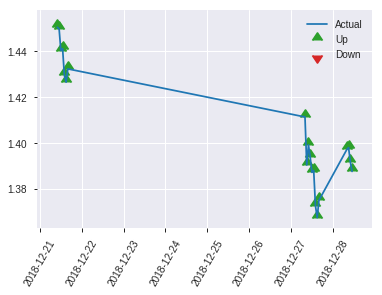


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25678929658546634
RMSE: 0.5067438175108467
LogLoss: 0.7074395721351895
Mean Per-Class Error: 0.4615002894715078
AUC: 0.5074021999834588
pr_auc: 0.5090184098795708
Gini: 0.014804399966917625
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3374539911746979: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    104  0.972    (104.0/107.0)
1      1    112  0.0088   (1.0/113.0)
Total  4    216  0.4773   (105.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.337454     0.680851   215
max f2                       0.264174     0.840774   219
max f0point5                 0.337454     0.573183   215
max accuracy                 0.49599      0.536364   92
max precision                0.506306     0.559524   83
max recall                   0.264174     1          219
max specificity              0.715412     0.990654   0
max absolute_mcc             0.663378     0.0984315  1
max min_per_class_accuracy   0.483895     0.504425   106
max mean_per_class_accuracy  0.49599      0.5385     92

Gains/Lift Table: Avg response rate: 51.36 %, avg score: 48.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.655338           0.648968  0.648968           0.333333         0.678127  0.333333                    0.678127            0.00884956      0.00884956                 -35.1032  -35.1032
    2        0.0227273                   0.63356            0.973451  0.778761           0.5              0.644325  0.4                         0.664606            0.00884956      0.0176991                  -2.65487  -22.1239
    3        0.0318182                   0.627552           0.973451  0.834387           0.5              0.631607  0.428571                    0.655178            0.00884956      0.0265487                  -2.65487  -16.5613
    4        0.0409091                   0.620103           0         0.648968           0                0.623635  0.333333                    0.648168            0               0.0265487                  -100      -35.1032
    5        0.05                        0.61138            1.9469    0.884956           1                0.615741  0.454545                    0.642272            0.0176991       0.0442478                  94.6903   -11.5044
    6        0.1                         0.589766           0.884956  0.884956           0.454545         0.598881  0.454545                    0.620577            0.0442478       0.0884956                  -11.5044  -11.5044
    7        0.15                        0.565721           1.06195   0.943953           0.545455         0.574244  0.484848                    0.605133            0.0530973       0.141593                   6.19469   -5.60472
    8        0.2                         0.55012            1.41593   1.06195            0.727273         0.557199  0.545455                    0.593149            0.0707965       0.212389                   41.5929   6.19469
    9        0.3                         0.517629           1.06195   1.06195            0.545455         0.534214  0.545455                    0.573504            0.106195        0.318584                   6.19469   6.19469
    10       0.4                         0.498981           1.06195   1.06195            0.545455         0.510038  0.545455                    0.557638            0.106195        0.424779                   6.19469   6.19469
    11       0.5                         0.481428           0.79646   1.00885            0.409091         0.489469  0.518182                    0.544004            0.079646        0.504425                   -20.354   0.884956
    12       0.6                         0.464403           0.973451  1.00295            0.5              0.472904  0.515152                    0.532154            0.0973451       0.60177                    -2.65487  0.294985
    13       0.7                         0.441965           0.884956  0.986094           0.454545         0.453161  0.506494                    0.520869            0.0884956       0.690265                   -11.5044  -1.39064
    14       0.8                         0.417904           1.15044   1.00664            0.590909         0.431795  0.517045                    0.509735            0.115044        0.80531                    15.0442   0.663717
    15       0.9                         0.385928           0.884956  0.993117           0.454545         0.403795  0.510101                    0.497964            0.0884956       0.893805                   -11.5044  -0.688299
    16       1                           0.264174           1.06195   1                  0.545455         0.350671  0.513636                    0.48

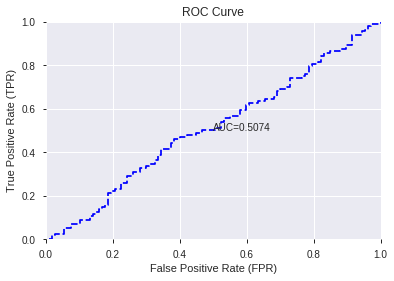

This function is available for GLM models only


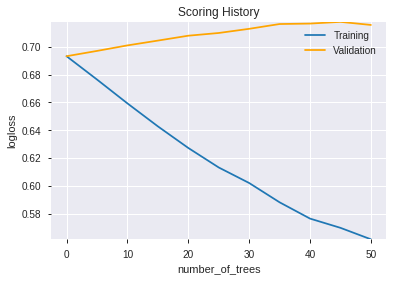

--2019-08-28 19:22:50--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.110.107
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.110.107|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.calculateChildInclusiveNa(SharedTreeNode.java:133)
	at hex.genmodel.algos.tree.SharedTreeNode.setRightChild(SharedTreeNode.java:220)
	at hex.genmodel.algos.tree.SharedTreeSubgraph.makeRightEdge(SharedTreeSubgraph.java:86)
	at hex.genmodel.algos.tree.SharedTreeSubgraph.makeRightChi

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_192233_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_192233_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_a8f4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['SIN',
 'HT_PHASOR_quadrature',
 'BOP',
 'HT_DCPERIOD',
 'DX_24',
 'CORREL_8',
 'Volume',
 'DX_8',
 'STOCHRSI_fastd',
 'MFI_20',
 'PLUS_DI_30',
 'DX_12',
 'SAREXT',
 'STOCH_slowd',
 'BETA_14',
 'BETA_12',
 'DX_14',
 'AROONOSC_20',
 'day',
 'BETA_8',
 'aroondown_14',
 'STOCHRSI_fastk',
 'AROONOSC_8',
 'aroonup_8',
 'aroonup_24',
 'aroondown_30',
 'aroondown_20',
 'aroondown_8',
 'aroonup_20',
 'days_in_month',
 'hour',
 'dayofweek',
 'CDLSPINNINGTOP',
 'weekday_name',
 'aroondown_12',
 'CDLMATCHINGLOW',
 'HT_TRENDMODE',
 'CDLINVERTEDHAMMER',
 'CDLRICKSHAWMAN',
 'weekday',
 'CDLDOJI']

In [14]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_192256_model_1  0.515921  0.692497              0.490158  0.499674  0.249675

variable  relative_importance  scaled_importance    percentage
0            CDLINVERTEDHAMMER         9.460027e-03           1.000000  1.543682e-02
1                 CDLTHRUSTING         7.776398e-03           0.822027  1.268948e-02
2           CDLSEPARATINGLINES         7.699320e-03           0.813879  1.256371e-02
3               CDLMATCHINGLOW         7.615694e-03           0.805039  1.242725e-02
4                days_in_month         6.474896e-03           0.684448  1.056570e-02
...                        ...                  ...                ...           ...
1028  BBANDS_middleband_12_1_5         7.719582e-07           0.000082  1.259677e-06
1029                 MAVP_12_6         7.491810e-07           0.000079  1.222509e-06
1030   BBANDS_upperband_12_5_2         6.599189e-07           0.000070  1.076852e-06
1031                 MAVP_30_7         3.680718e-07           0.000039  6.006174e-07
1032   BBANDS_lowerband_20_7_5         2.452785e-07           0.000026  4.002441e-07

[1033 rows x 4 columns]

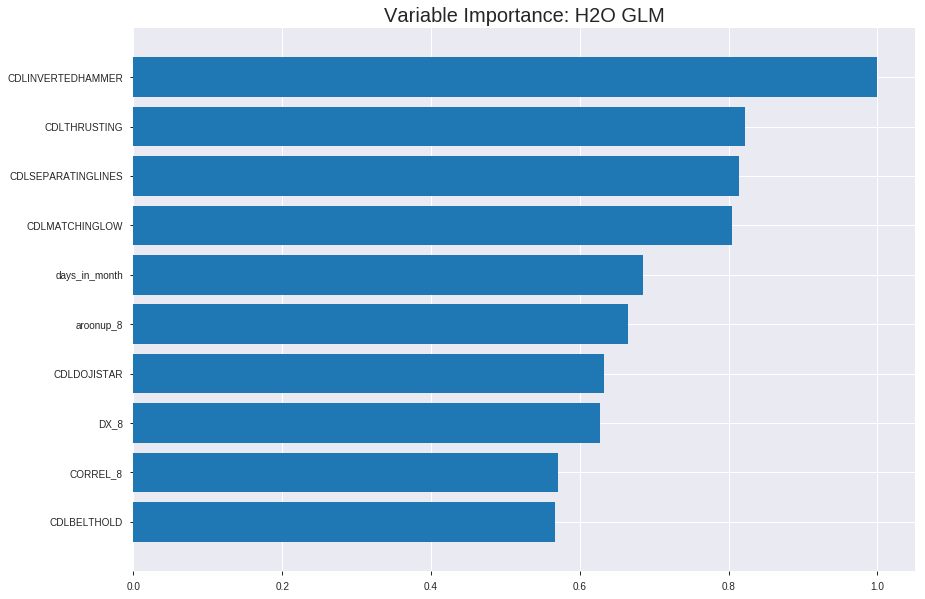

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_192256_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24676963059921955
RMSE: 0.49675912734364486
LogLoss: 0.6866722880914399
Null degrees of freedom: 1536
Residual degrees of freedom: 503
Null deviance: 2130.499553929498
Residual deviance: 2110.830613593086
AIC: 4178.830613593086
AUC: 0.5930606500909396
pr_auc: 0.5989310249855666
Gini: 0.1861213001818791
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4658860618942555: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      47   712   0.9381   (712.0/759.0)
1      13   765   0.0167   (13.0/778.0)
Total  60   1477  0.4717   (725.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.465886     0.678492  358
max f2                       0.451903     0.837657  381
max f0point5                 0.495677     0.589524  248
max accuracy                 0.495677     0.571893  248
max precision                0.568714     1         0
max recall                   0.440778     1         394
max specificity              0.568714     1         0
max absolute_mcc             0.495677     0.155148  248
max min_per_class_accuracy   0.508941     0.560411  179
max mean_per_class_accuracy  0.495677     0.569093  248

Gains/Lift Table: Avg response rate: 50.62 %, avg score: 50.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.549663           1.72863   1.72863            0.875            0.554053  0.875                       0.554053            0.0179949       0.0179949                  72.8631   72.8631
    2        0.0201692                   0.54415            1.58046   1.65694            0.8              0.546364  0.83871                     0.550332            0.0154242       0.033419                   58.0463   65.6937
    3        0.0305791                   0.540455           1.35821   1.55524            0.6875           0.542305  0.787234                    0.5476              0.0141388       0.0475578                  35.821    55.5243
    4        0.0403383                   0.539404           1.18535   1.46575            0.6              0.53987   0.741935                    0.54573             0.0115681       0.059126                   18.5347   46.5752
    5        0.0500976                   0.537805           1.18535   1.41113            0.6              0.538754  0.714286                    0.544371            0.0115681       0.0706941                  18.5347   41.1127
    6        0.100195                    0.531499           1.28284   1.34699            0.649351         0.533892  0.681818                    0.539131            0.0642674       0.134961                   28.2843   34.6985
    7        0.150293                    0.52626            1.10325   1.26574            0.558442         0.528548  0.640693                    0.535603            0.0552699       0.190231                   10.3245   26.5739
    8        0.20039                     0.522613           1.02627   1.20587            0.519481         0.52435   0.61039                     0.53279             0.0514139       0.241645                   2.62745   20.5873
    9        0.299935                    0.51783            1.1621    1.19135            0.588235         0.519999  0.603037                    0.528545            0.115681        0.357326                   16.2105   19.1347
    10       0.40013                     0.513733           1.05193   1.15644            0.532468         0.515868  0.585366                    0.525371            0.105398        0.462725                   5.19314   15.6436
    11       0.500325                    0.508844           0.987789  1.12266            0.5              0.511136  0.56827                     0.52252             0.0989717       0.561697                   -1.22108  12.2663
    12       0.59987                     0.503551           0.929684  1.09064            0.470588         0.506193  0.552061                    0.519811            0.092545        0.654242                   -7.0316   9.06393
    13       0.700065                    0.497602           1.0391    1.08326            0.525974         0.500705  0.548327                    0.517076            0.104113        0.758355                   3.91029   8.32633
    14       0.79961                     0.488712           0.865123  1.05611            0.437908         0.493455  0.534581                    0.514136            0.0861183       0.844473                   -13.4877  5.61066
    15       0.899805                    0.477066           0.795363  1.02707            0.402597         0.483633  0.519884                    0.510739            0.0796915       0.924165                   -20.4637  2.70722
    16       1                           0.417672           0.756877  1                  0.383117         0.465246  0.506181                    0.506181         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2511499973594055
RMSE: 0.501148677898491
LogLoss: 0.6954685345357587
Null degrees of freedom: 438
Residual degrees of freedom: -595
Null deviance: 608.2794432341497
Residual deviance: 610.6213733223962
AIC: 2678.6213733223963
AUC: 0.5011221012384673
pr_auc: 0.5178801935283589
Gini: 0.002244202476934687
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40542672940822627: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    212  1        (212.0/212.0)
1      0    227  0        (0.0/227.0)
Total  0    439  0.4829   (212.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.405427     0.681682  399
max f2                       0.405427     0.842613  399
max f0point5                 0.405427     0.572365  399
max accuracy                 0.481719     0.528474  296
max precision                0.548077     1         0
max recall                   0.405427     1         399
max specificity              0.548077     1         0
max absolute_mcc             0.528754     0.066753  38
max min_per_class_accuracy   0.497973     0.518868  197
max mean_per_class_accuracy  0.498359     0.524219  194

Gains/Lift Table: Avg response rate: 51.71 %, avg score: 49.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.542617           1.54714   1.54714            0.8              0.545126  0.8                         0.545126            0.0176211       0.0176211                  54.7137   54.7137
    2        0.0205011                   0.539618           0.96696   1.28928            0.5              0.541059  0.666667                    0.543318            0.00881057      0.0264317                  -3.30396  28.928
    3        0.0318907                   0.538347           1.16035   1.24323            0.6              0.53913   0.642857                    0.541823            0.0132159       0.0396476                  16.0352   24.3235
    4        0.0410023                   0.5366             0.48348   1.0744             0.25             0.537702  0.555556                    0.540907            0.00440529      0.0440529                  -51.652   7.44004
    5        0.0501139                   0.534586           0.48348   0.96696            0.25             0.535496  0.5                         0.539923            0.00440529      0.0484581                  -51.652   -3.30396
    6        0.100228                    0.526599           0.791149  0.879055           0.409091         0.530233  0.454545                    0.535078            0.0396476       0.0881057                  -20.8851  -12.0945
    7        0.150342                    0.517695           0.96696   0.908357           0.5              0.52223   0.469697                    0.530795            0.0484581       0.136564                   -3.30396  -9.16433
    8        0.200456                    0.515108           1.14277   0.96696            0.590909         0.516389  0.5                         0.527194            0.0572687       0.193833                   14.2771   -3.30396
    9        0.300683                    0.507688           1.05487   0.996262           0.545455         0.51085   0.515152                    0.521746            0.105727        0.299559                   5.48658   -0.373782
    10       0.400911                    0.503081           1.09882   1.0219             0.568182         0.505297  0.528409                    0.517634            0.110132        0.409692                   9.88186   2.19013
    11       0.501139                    0.497973           1.09882   1.03728            0.568182         0.500319  0.536364                    0.514171            0.110132        0.519824                   9.88186   3.72847
    12       0.599089                    0.492008           0.899498  1.01476            0.465116         0.49489   0.524715                    0.511018            0.0881057       0.60793                    -10.0502  1.47569
    13       0.699317                    0.485507           0.923008  1.00161            0.477273         0.489307  0.517915                    0.507907            0.092511        0.700441                   -7.69924  0.160714
    14       0.799544                    0.478578           1.14277   1.0193             0.590909         0.482101  0.527066                    0.504672            0.114537        0.814978                   14.2771   1.93029
    15       0.899772                    0.468488           0.791149  0.993888           0.409091         0.474564  0.513924                    0.501318            0.0792952       0.894273                   -20.8851  -0.611164
    16       1                           0.405427           1.05487   1                  0.545455         0.438701  0.517084                    0.495042 


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 19:22:59  0.000 sec   2            3.4       1034          1.37334           1.39094
    2019-08-28 19:23:01  2.006 sec   4            2.5       1034          1.37014           1.3935
    2019-08-28 19:23:03  3.996 sec   6            1.8       1034          1.36635           1.39665
    2019-08-28 19:23:05  5.996 sec   8            1.3       1034          1.36194           1.40065
    2019-08-28 19:23:07  7.975 sec   10           0.95      1034          1.35685           1.40589

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5545454545454546)

('F1', 0.6788990825688073)

('auc', 0.5159209329253163)

('logloss', 0.6924969641485332)

('mean_per_class_error', 0.4385906872880655)

('rmse', 0.49967446894678974)

('mse', 0.24967457491725634)

glm prediction progress: |████████████████████████████████████████████████| 100%


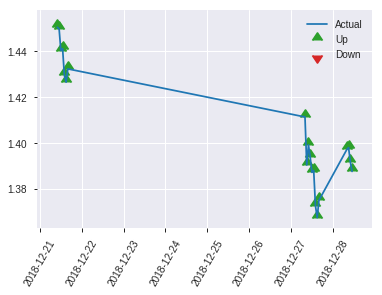


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24967457491725634
RMSE: 0.49967446894678974
LogLoss: 0.6924969641485332
Null degrees of freedom: 219
Residual degrees of freedom: -814
Null deviance: 304.8700323300008
Residual deviance: 304.69866422535455
AIC: 2372.6986642253546
AUC: 0.5159209329253163
pr_auc: 0.551748315881439
Gini: 0.031841865850632534
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46750109500045484: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    103  0.9626   (103.0/107.0)
1      2    111  0.0177   (2.0/113.0)
Total  6    214  0.4773   (105.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.467501     0.678899  213
max f2                       0.447903     0.840774  219
max f0point5                 0.467501     0.572755  213
max accuracy                 0.505829     0.554545  54
max precision                0.528363     1         0
max recall                   0.447903     1         219
max specificity              0.528363     1         0
max absolute_mcc             0.519043     0.166722  12
max min_per_class_accuracy   0.495968     0.495575  108
max mean_per_class_accuracy  0.505829     0.561409  54

Gains/Lift Table: Avg response rate: 51.36 %, avg score: 49.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.526316           1.29794   1.29794            0.666667         0.527435  0.666667                    0.527435            0.0176991       0.0176991                  29.7935   29.7935
    2        0.0227273                   0.523675           0.973451  1.16814            0.5              0.524432  0.6                         0.526234            0.00884956      0.0265487                  -2.65487  16.8142
    3        0.0318182                   0.522474           1.9469    1.39064            1                0.523079  0.714286                    0.525333            0.0176991       0.0442478                  94.6903   39.0645
    4        0.0409091                   0.520455           1.9469    1.51426            1                0.521625  0.777778                    0.524509            0.0176991       0.0619469                  94.6903   51.4258
    5        0.05                        0.519655           1.9469    1.59292            1                0.520232  0.818182                    0.523731            0.0176991       0.079646                   94.6903   59.292
    6        0.1                         0.515187           0.530973  1.06195            0.272727         0.517047  0.545455                    0.520389            0.0265487       0.106195                   -46.9027  6.19469
    7        0.15                        0.512964           1.59292   1.23894            0.818182         0.513987  0.636364                    0.518255            0.079646        0.185841                   59.292    23.8938
    8        0.2                         0.50912            1.23894   1.23894            0.636364         0.511083  0.636364                    0.516462            0.0619469       0.247788                   23.8938   23.8938
    9        0.3                         0.503418           0.973451  1.15044            0.5              0.506004  0.590909                    0.512976            0.0973451       0.345133                   -2.65487  15.0442
    10       0.4                         0.498323           0.619469  1.0177             0.318182         0.501113  0.522727                    0.51001             0.0619469       0.40708                    -38.0531  1.76991
    11       0.5                         0.495866           0.884956  0.99115            0.454545         0.497148  0.509091                    0.507438            0.0884956       0.495575                   -11.5044  -0.884956
    12       0.6                         0.492095           0.79646   0.958702           0.409091         0.493978  0.492424                    0.505195            0.079646        0.575221                   -20.354   -4.12979
    13       0.7                         0.489875           1.06195   0.973451           0.545455         0.490957  0.5                         0.503161            0.106195        0.681416                   6.19469   -2.65487
    14       0.8                         0.484665           1.15044   0.995575           0.590909         0.487511  0.511364                    0.501204            0.115044        0.79646                    15.0442   -0.442478
    15       0.9                         0.475175           1.06195   1.00295            0.545455         0.47977   0.515152                    0.498823            0.106195        0.902655                   6.19469   0.294985
    16       1                           0.447903           0.973451  1                  0.5              0.468556  0.513636                    0.495796   

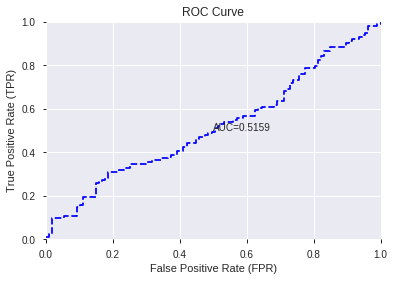

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


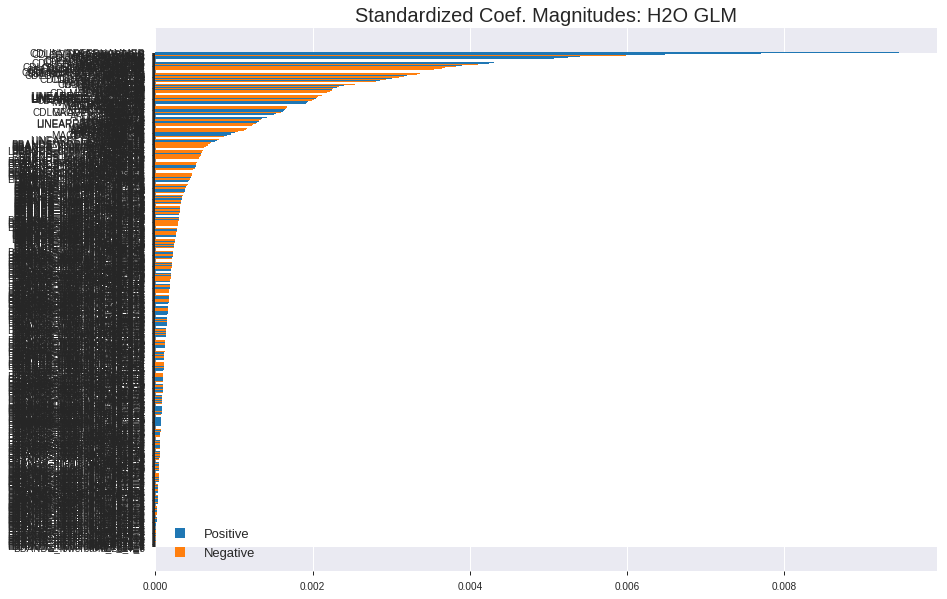

'log_likelihood'
--2019-08-28 19:23:33--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.9.59
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.9.59|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_192256_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_192256_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_a8f4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

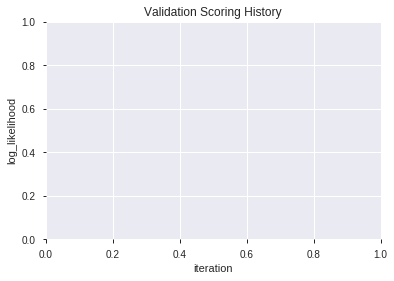

In [15]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [16]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [17]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [18]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_2_AutoML_20190828_192339  0.531966  0.701875              0.500000  0.504152  0.254169
1  XGBoost_grid_1_AutoML_20190828_192339_model_5  0.510628  0.743598              0.500000  0.520565  0.270988
2  XGBoost_grid_1_AutoML_20190828_192339_model_7  0.491192  0.724882              0.500000  0.514612  0.264825
3  XGBoost_grid_1_AutoML_20190828_192339_model_3  0.486229  0.718545              0.500000  0.511975  0.262119
4               XGBoost_3_AutoML_20190828_192339  0.485485  0.713658              0.500000  0.509824  0.259920
5  XGBoost_grid_1_AutoML_20190828_192339_model_6  0.475891  0.710697              0.500000  0.508415  0.258486
6  XGBoost_grid_1_AutoML_20190828_192339_model_1  0.472500  0.709401              0.490406  0.507757  0.257817
7  XGBoost_grid_1_AutoML_20190828_192339_model_4  0.468861  0.708594              0.500000  0.507490  0.257546
8  XGBoost_grid_1_AutoML_20190828_192339_model_2  0.460425  0.718335              0.500000  0.511990  0.262134
9               XGBoost_1_AutoML_20190828_192339  0.443222  0.741456              0.500000  0.522051  0.272537

variable  relative_importance  scaled_importance  percentage
0                   CORREL_8            93.094200           1.000000    0.016913
1                      ATR_8            91.157082           0.979192    0.016561
2                        DIV            89.664360           0.963157    0.016290
3                        BOP            87.417191           0.939019    0.015882
4                    NATR_30            83.790710           0.900064    0.015223
..                       ...                  ...                ...         ...
267        MACDFIX_signal_12             3.136653           0.033693    0.000570
268  BBANDS_upperband_14_7_5             2.970720           0.031911    0.000540
269  BBANDS_lowerband_20_1_4             2.838207           0.030487    0.000516
270  BBANDS_upperband_30_1_5             2.317775           0.024897    0.000421
271                   VAR_24             2.187851           0.023501    0.000397

[272 rows x 4 columns]

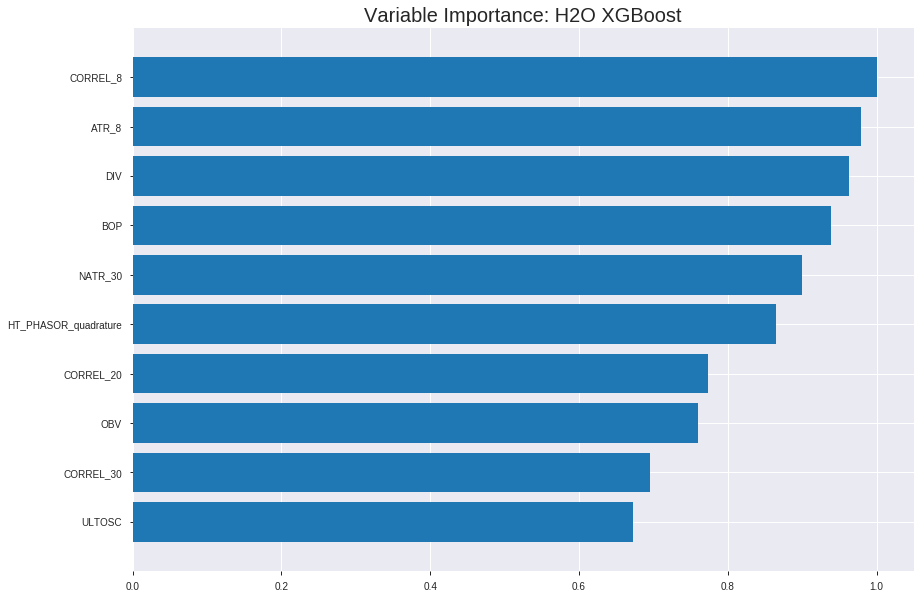

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20190828_192339


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17335818106681178
RMSE: 0.41636303998651436
LogLoss: 0.5346559126060626
Mean Per-Class Error: 0.14082763479209215
AUC: 0.9362931878300158
pr_auc: 0.9361014754966879
Gini: 0.8725863756600316
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4930047392845154: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      613  146  0.1924   (146.0/759.0)
1      82   696  0.1054   (82.0/778.0)
Total  695  842  0.1483   (228.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.493005     0.859259  209
max f2                       0.443895     0.907443  252
max f0point5                 0.550012     0.884805  160
max accuracy                 0.520447     0.858816  185
max precision                0.775469     1         0
max recall                   0.345613     1         338
max specificity              0.775469     1         0
max absolute_mcc             0.520447     0.719147  185
max min_per_class_accuracy   0.510595     0.856041  194
max mean_per_class_accuracy  0.520447     0.859172  185

Gains/Lift Table: Avg response rate: 50.62 %, avg score: 50.83 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.74215            1.97558    1.97558            1                0.753388  1                           0.753388            0.0205656       0.0205656                  97.5578   97.5578
    2        0.0201692                   0.727608           1.97558    1.97558            1                0.734784  1                           0.744386            0.0192802       0.0398458                  97.5578   97.5578
    3        0.0305791                   0.718657           1.97558    1.97558            1                0.722751  1                           0.737021            0.0205656       0.0604113                  97.5578   97.5578
    4        0.0403383                   0.711981           1.97558    1.97558            1                0.715732  1                           0.73187             0.0192802       0.0796915                  97.5578   97.5578
    5        0.0500976                   0.703446           1.97558    1.97558            1                0.708186  1                           0.727256            0.0192802       0.0989717                  97.5578   97.5578
    6        0.100195                    0.674545           1.92426    1.94992            0.974026         0.687909  0.987013                    0.707583            0.096401        0.195373                   92.4265   94.9922
    7        0.150293                    0.6487             1.97558    1.95847            1                0.660705  0.991342                    0.691957            0.0989717       0.294344                   97.5578   95.8474
    8        0.20039                     0.627459           1.89861    1.94351            0.961039         0.636694  0.983766                    0.678141            0.0951157       0.38946                    89.8608   94.3507
    9        0.299935                    0.59152            1.84646    1.9113             0.934641         0.60826   0.967462                    0.654949            0.183805        0.573265                   84.6456   91.1297
    10       0.40013                     0.549513           1.62921    1.84066            0.824675         0.569424  0.931707                    0.633533            0.163239        0.736504                   62.9211   84.0661
    11       0.500325                    0.510863           1.15456    1.70326            0.584416         0.529324  0.862159                    0.612664            0.115681        0.852185                   15.4559   70.3262
    12       0.59987                     0.471656           0.787649   1.55132            0.398693         0.491724  0.785249                    0.592595            0.0784062       0.930591                   -21.2351  55.1322
    13       0.700065                    0.432593           0.423338   1.38988            0.214286         0.450269  0.703532                    0.572225            0.0424165       0.973008                   -57.6662  38.9882
    14       0.79961                     0.389936           0.193684   1.24097            0.0980392        0.411007  0.628153                    0.552154            0.0192802       0.992288                   -80.6316  24.0965
    15       0.899805                    0.340307           0.0769706  1.11135            0.038961         0.364773  0.562545                    0.531289            0.00771208      1                          -92.3029  11.1352
    16       1                           0.197444           0          1                  0                0.302005  0.506181                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2620806225183293
RMSE: 0.5119381041867554
LogLoss: 0.7178646711129717
Mean Per-Class Error: 0.4958856287922866
AUC: 0.45161457900423907
pr_auc: 0.4803908360717882
Gini: -0.09677084199152186
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3133352994918823: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    212  1        (212.0/212.0)
1      0    227  0        (0.0/227.0)
Total  0    439  0.4829   (212.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.313335     0.681682  399
max f2                       0.313335     0.842613  399
max f0point5                 0.313335     0.572365  399
max accuracy                 0.313335     0.517084  399
max precision                0.59903      0.542857  32
max recall                   0.313335     1         399
max specificity              0.671001     0.995283  0
max absolute_mcc             0.626231     0.117556  10
max min_per_class_accuracy   0.484514     0.462555  201
max mean_per_class_accuracy  0.59903      0.504114  32

Gains/Lift Table: Avg response rate: 51.71 %, avg score: 48.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.645898           0.773568  0.773568           0.4              0.660316  0.4                         0.660316            0.00881057      0.00881057                 -22.6432  -22.6432
    2        0.0205011                   0.630428           0         0.42976            0                0.637114  0.222222                    0.650004            0               0.00881057                 -100      -57.024
    3        0.0318907                   0.623274           0.386784  0.414412           0.2              0.62668   0.214286                    0.641674            0.00440529      0.0132159                  -61.3216  -58.5588
    4        0.0410023                   0.619236           1.93392   0.75208            1                0.620671  0.388889                    0.637007            0.0176211       0.030837                   93.3921   -24.792
    5        0.0501139                   0.6119             1.93392   0.96696            1                0.61629   0.5                         0.63324             0.0176211       0.0484581                  93.3921   -3.30396
    6        0.100228                    0.592098           0.879055  0.923008           0.454545         0.600638  0.477273                    0.616939            0.0440529       0.092511                   -12.0945  -7.69924
    7        0.150342                    0.573846           0.879055  0.908357           0.454545         0.583672  0.469697                    0.60585             0.0440529       0.136564                   -12.0945  -9.16433
    8        0.200456                    0.558622           0.703244  0.857078           0.363636         0.564615  0.443182                    0.595541            0.0352423       0.171806                   -29.6756  -14.2922
    9        0.300683                    0.530461           1.01091   0.908357           0.522727         0.542348  0.469697                    0.57781             0.101322        0.273128                   1.09131   -9.16433
    10       0.400911                    0.507703           0.835102  0.890043           0.431818         0.519242  0.460227                    0.563168            0.0837004       0.356828                   -16.4898  -10.9957
    11       0.501139                    0.482493           1.09882   0.931798           0.568182         0.494425  0.481818                    0.54942             0.110132        0.46696                    9.88186   -6.82018
    12       0.599089                    0.466959           1.03442   0.948577           0.534884         0.474638  0.490494                    0.537193            0.101322        0.568282                   3.44227   -5.14229
    13       0.699317                    0.448261           1.14277   0.976409           0.590909         0.457363  0.504886                    0.525752            0.114537        0.682819                   14.2771   -2.35905
    14       0.799544                    0.424286           0.96696   0.975225           0.5              0.434104  0.504274                    0.514263            0.0969163       0.779736                   -3.30396  -2.4775
    15       0.899772                    0.399417           1.09882   0.988992           0.568182         0.412895  0.511392                    0.502971            0.110132        0.889868                   9.88186   -1.10076
    16       1                           0.313335           1.09882   1                  0.568182         0.372452  0.517084                    0.489


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 19:23:44  0.004 sec   0                  0.5              0.693147            0.5             0                  1                0.493819                         0.5                0.693147              0.5               0                    1                  0.482916
    2019-08-28 19:23:45  0.750 sec   5                  0.488885         0.671118            0.759067        0.750117           1.72863          0.329213                         0.503871           0.700936              0.419666          0.4558               0.386784           0.482916
    2019-08-28 19:23:45  1.364 sec   10                 0.479247         0.652295            0.808776        0.810087           1.8521           0.276513                         0.506238           0.705757              0.411749          0.446217             0.386784           0.482916
    2019-08-28 19:23:46  1.904 sec   15                 0.469395         0.633251            0.835553        0.841075           1.97558          0.248536                         0.507665           0.708737              0.427053          0.461254             0                  0.482916
    2019-08-28 19:23:46  2.505 sec   20                 0.461123         0.617441            0.856664        0.860736           1.8521           0.229018                         0.508388           0.710252              0.43549           0.469022             0.773568           0.482916
    2019-08-28 19:23:47  3.112 sec   25                 0.453529         0.603022            0.872949        0.875799           1.8521           0.221861                         0.508873           0.71127               0.437142          0.471275             0.773568           0.480638
    2019-08-28 19:23:48  3.761 sec   30                 0.446198         0.589274            0.88791         0.891897           1.97558          0.206246                         0.510113           0.713885              0.43469           0.473735             1.16035            0.482916
    2019-08-28 19:23:48  4.366 sec   35                 0.437922         0.573922            0.904851        0.90902            1.97558          0.184125                         0.509686           0.713045              0.447427          0.47634              0.773568           0.482916
    2019-08-28 19:23:49  4.953 sec   40                 0.430058         0.559531            0.919881        0.921966           1.97558          0.169161                         0.511158           0.716128              0.441547          0.472688             0.773568           0.482916
    2019-08-28 19:23:49  5.508 sec   45                 0.423041         0.546751            0.930414        0.932203           1.97558          0.152245                         0.511912           0.717738              0.439531          0.473004             0                  0.482916
    2019-08-28 19:23:50  6.055 sec   50                 0.416363         0.534656            0.936293        0.936101           1.97558          0.148341                         0.511938           0.717865              0.451615          0.480391             0.773568           0.482916

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
CORREL_8                 93.09420013427734      1.0                   0.016913106612839388
ATR_8                    91.1570816040039       0.9791918451688787    0.016561176071764164
DIV                      89.66436004638672      0.9631573171804099    0.016289982390408634
BOP                      87.41719055175781      0.9390186544990867    0.015881722614988047
NATR_30                  83.79071044921875      0.9000637024472049    0.015222873357836524
---                      ---                    ---                   ---
MACDFIX_signal_12        3.136653423309326      0.03369332803531343   0.0005698588492026263
BBANDS_upperband_14_7_5  2.9707202911376953     0.03191090623103033   0.0005397125591977366
BBANDS_lowerband_20_1_4  2.838207244873047      0.030487476564375327  0.0005156379414897221
BBANDS_upperband_30_1_5  2.317774772644043      0.02489709100353113   0.00042108715449228637
VAR_24                   2.1878509521484375     0.023501474302295117  0.0003974829404336224


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5590909090909091)

('F1', 0.6786786786786787)

('auc', 0.5319659250682326)

('logloss', 0.7018754821880735)

('mean_per_class_error', 0.4383839219253991)

('rmse', 0.5041519875268574)

('mse', 0.2541692265272806)

xgboost prediction progress: |████████████████████████████████████████████| 100%


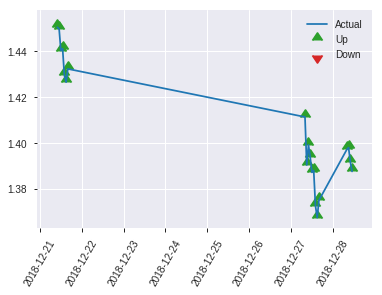


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2541692265272806
RMSE: 0.5041519875268574
LogLoss: 0.7018754821880735
Mean Per-Class Error: 0.4383839219253991
AUC: 0.5319659250682326
pr_auc: 0.5468902579433191
Gini: 0.06393185013646518
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2801385223865509: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    107  1        (107.0/107.0)
1      0    113  0        (0.0/113.0)
Total  0    220  0.4864   (107.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.280139     0.678679  219
max f2                       0.280139     0.840774  219
max f0point5                 0.370997     0.582307  194
max accuracy                 0.480033     0.559091  89
max precision                0.703265     1         0
max recall                   0.280139     1         219
max specificity              0.703265     1         0
max absolute_mcc             0.610754     0.148395  4
max min_per_class_accuracy   0.461675     0.530973  109
max mean_per_class_accuracy  0.480033     0.561616  89

Gains/Lift Table: Avg response rate: 51.36 %, avg score: 46.11 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.633847           1.9469    1.9469             1                0.671682  1                           0.671682            0.0265487       0.0265487                  94.6903   94.6903
    2        0.0227273                   0.608162           1.9469    1.9469             1                0.614912  1                           0.648974            0.0176991       0.0442478                  94.6903   94.6903
    3        0.0318182                   0.593466           0         1.39064            0                0.600829  0.714286                    0.635218            0               0.0442478                  -100      39.0645
    4        0.0409091                   0.589821           0.973451  1.29794            0.5              0.590127  0.666667                    0.625198            0.00884956      0.0530973                  -2.65487  29.7935
    5        0.05                        0.581873           0.973451  1.23894            0.5              0.586251  0.636364                    0.618117            0.00884956      0.0619469                  -2.65487  23.8938
    6        0.1                         0.55767            1.06195   1.15044            0.545455         0.569126  0.590909                    0.593621            0.0530973       0.115044                   6.19469   15.0442
    7        0.15                        0.535905           0.530973  0.943953           0.272727         0.549722  0.484848                    0.578988            0.0265487       0.141593                   -46.9027  -5.60472
    8        0.2                         0.521211           1.06195   0.973451           0.545455         0.529328  0.5                         0.566573            0.0530973       0.19469                    6.19469   -2.65487
    9        0.3                         0.496281           1.23894   1.06195            0.636364         0.510831  0.545455                    0.547993            0.123894        0.318584                   23.8938   6.19469
    10       0.4                         0.480173           1.32743   1.12832            0.681818         0.487596  0.579545                    0.532893            0.132743        0.451327                   32.7434   12.8319
    11       0.5                         0.461649           0.79646   1.06195            0.409091         0.470743  0.545455                    0.520463            0.079646        0.530973                   -20.354   6.19469
    12       0.6                         0.439684           0.619469  0.988201           0.318182         0.451892  0.507576                    0.509035            0.0619469       0.59292                    -38.0531  -1.17994
    13       0.7                         0.413449           1.32743   1.03666            0.681818         0.427504  0.532468                    0.497387            0.132743        0.725664                   32.7434   3.66625
    14       0.8                         0.392379           0.973451  1.02876            0.5              0.404364  0.528409                    0.48576             0.0973451       0.823009                   -2.65487  2.87611
    15       0.9                         0.368967           0.973451  1.02262            0.5              0.38077   0.525253                    0.474094            0.0973451       0.920354                   -2.65487  2.26155
    16       1                           0.280139           0.79646   1                  0.409091         0.343853  0.513636                    0.46107       

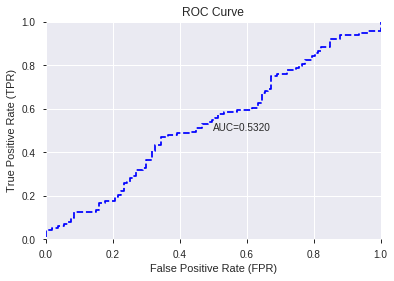

This function is available for GLM models only


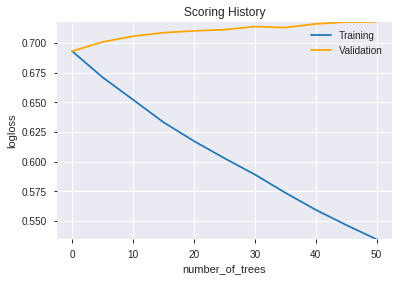

--2019-08-28 19:24:33--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.237.67
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.237.67|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip


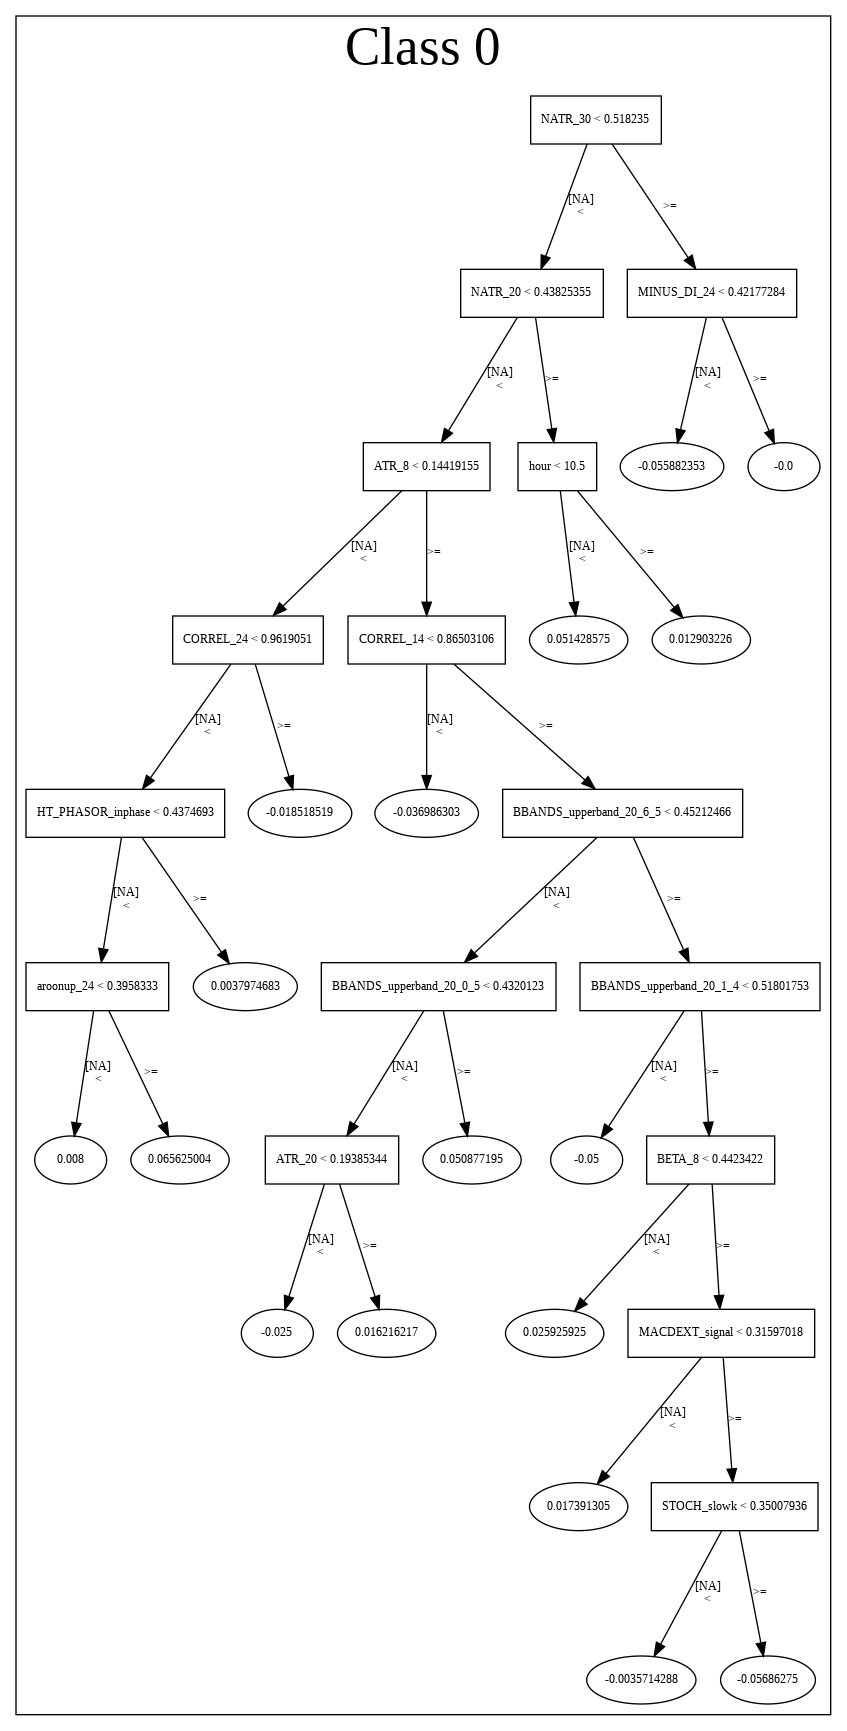

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_2_AutoML_20190828_192339',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_2_AutoML_20190828_192339',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_a8f4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_42_sid_a8f4',
   'type

In [19]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_192439_model_2  0.541229  0.890276              0.466793  0.555608  0.308700
1  DeepLearning_grid_1_AutoML_20190828_192439_model_3  0.539740  0.781579              0.466297  0.531855  0.282870
2  DeepLearning_grid_1_AutoML_20190828_192439_model_9  0.523861  0.692969              0.500000  0.499911  0.249911
3  DeepLearning_grid_1_AutoML_20190828_192439_model_1  0.515673  1.162949              0.500000  0.598014  0.357620
4  DeepLearning_grid_1_AutoML_20190828_192439_model_6  0.513522  0.707933              0.481060  0.506865  0.256912
5               DeepLearning_1_AutoML_20190828_192439  0.511620  0.722722              0.485485  0.513822  0.264013
6  DeepLearning_grid_1_AutoML_20190828_192439_model_8  0.498966  0.695875              0.500000  0.501359  0.251361
7  DeepLearning_grid_1_AutoML_20190828_192439_model_4  0.487801  1.050469              0.500000  0.581093  0.337669
8  DeepLearning_grid_1_AutoML_20190828_192439_model_7  0.478207  0.774407              0.495327  0.535779  0.287059
9  DeepLearning_grid_1_AutoML_20190828_192439_model_5  0.473741  0.701795              0.500000  0.504101  0.254118

variable  relative_importance  scaled_importance  percentage
0     CDLEVENINGDOJISTAR             1.000000           1.000000    0.030357
1                    day             0.939066           0.939066    0.028507
2     CDLIDENTICAL3CROWS             0.876637           0.876637    0.026612
3        CDLSHOOTINGSTAR             0.828110           0.828110    0.025139
4          CDLHIKKAKEMOD             0.792338           0.792338    0.024053
5    CDLGAPSIDESIDEWHITE             0.785529           0.785529    0.023846
6      CDLINVERTEDHAMMER             0.765142           0.765142    0.023227
7                    SIN             0.759323           0.759323    0.023051
8         STOCHRSI_fastd             0.753734           0.753734    0.022881
9                   hour             0.751898           0.751898    0.022825
10                   BOP             0.750292           0.750292    0.022776
11       CDLLADDERBOTTOM             0.737628           0.737628    0.022392
12        STOCHRSI_fastk             0.713739           0.713739    0.021667
13     CDL3WHITESOLDIERS             0.712280           0.712280    0.021623
14   CDLRISEFALL3METHODS             0.711474           0.711474    0.021598
15         days_in_month             0.703118           0.703118    0.021344
16  HT_PHASOR_quadrature             0.698995           0.698995    0.021219
17          aroondown_14             0.686829           0.686829    0.020850
18          HT_TRENDMODE             0.684922           0.684922    0.020792
19          aroondown_12             0.669510           0.669510    0.020324
20                SAREXT             0.661297           0.661297    0.020075
21           HT_DCPERIOD             0.659733           0.659733    0.020027
22            aroonup_24             0.659172           0.659172    0.020010
23              CORREL_8             0.645593           0.645593    0.019598
24                  DX_8             0.640879           0.640879    0.019455
25           aroondown_8             0.632734           0.632734    0.019208
26                 DX_24             0.627727           0.627727    0.019056
27             aroonup_8             0.627484           0.627484    0.019048
28          weekday_name             0.626443           0.626443    0.019017
29               weekday             0.620509           0.620509    0.018837
30          aroondown_30             0.618033           0.618033    0.018762
31                Volume             0.614411           0.614411    0.018652
32               BETA_12             0.602910           0.602910    0.018302
33             dayofweek             0.595845           0.595845    0.018088
34          aroondown_20             0.593020           0.593020    0.018002
35               BETA_14             0.590779           0.590779    0.017934
36           STOCH_slowd             0.588005           0.588005    0.017850
37            aroonup_20             0.581552           0.581552    0.017654
38        CDLSPINNINGTOP             0.568368           0.568368    0.017254
39            PLUS_DI_30             0.563685           0.563685    0.017112
40                MFI_20             0.558204           0.558204    0.016945
41     CDLLONGLEGGEDDOJI             0.553837           0.553837    0.016813
42                 DX_14             0.552393           0.552393    0.016769
43               CDLDOJI             0.551403           0.551403    0.016739
44            AROONOSC_8             0.549279           0.549279    0.016674
45                BETA_8             0.534936           0.534936    0.016239
46                 DX_12             0.520203           0.520203    0.015792
47        CDLRICKSHAWMAN             0.513787           0.513787    0.015597
48           AROONOSC_20             0.492481           0.492481    0.014950
49        CDLMATCHINGLOW             0.476279           0.476279    0.014458

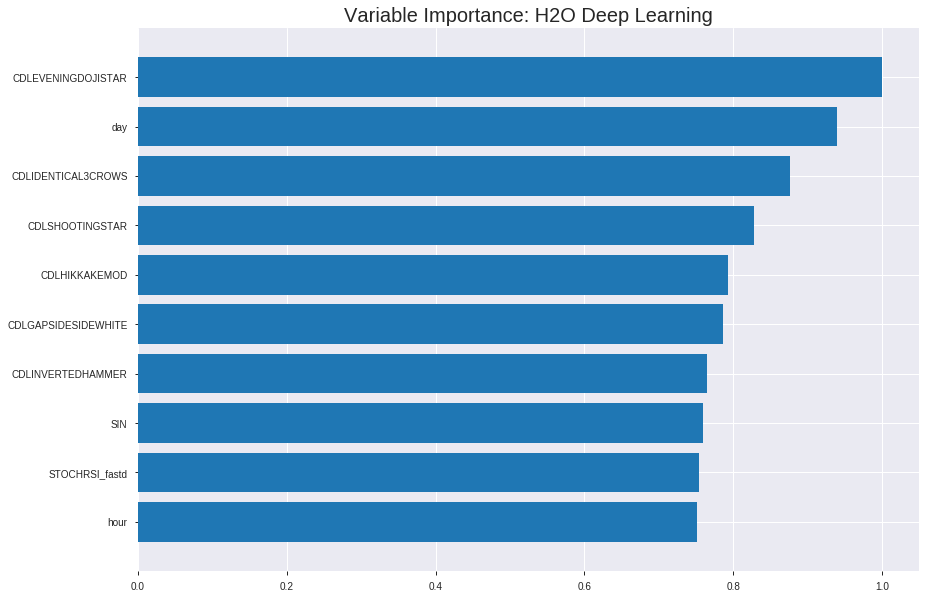

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_192439_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2912945776930785
RMSE: 0.5397171274779766
LogLoss: 0.8683296983363494
Mean Per-Class Error: 0.4194820677999398
AUC: 0.5993942442193252
pr_auc: 0.5933344060657536
Gini: 0.19878848843865038
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24319715747524592: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      100  659   0.8682   (659.0/759.0)
1      46   732   0.0591   (46.0/778.0)
Total  146  1391  0.4587   (705.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.243197     0.674965  335
max f2                       0.00317865   0.836919  398
max f0point5                 0.515036     0.595099  236
max accuracy                 0.587328     0.582303  207
max precision                0.999624     1         0
max recall                   0.00317865   1         398
max specificity              0.999624     1         0
max absolute_mcc             0.515036     0.171344  236
max min_per_class_accuracy   0.699358     0.561697  156
max mean_per_class_accuracy  0.587328     0.580518  207

Gains/Lift Table: Avg response rate: 50.62 %, avg score: 64.94 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.99202            1.72863   1.72863            0.875            0.996614  0.875                       0.996614            0.0179949       0.0179949                  72.8631   72.8631
    2        0.0201692                   0.987994           1.71217   1.72067            0.866667         0.990253  0.870968                    0.993536            0.0167095       0.0347044                  71.2168   72.0665
    3        0.0305791                   0.978821           0.987789  1.47118            0.5              0.982923  0.744681                    0.989923            0.0102828       0.0449871                  -1.22108  47.1175
    4        0.0403383                   0.975682           1.31705   1.43389            0.666667         0.977163  0.725806                    0.986836            0.0128535       0.0578406                  31.7052   43.3888
    5        0.0500976                   0.969275           1.18535   1.38547            0.6              0.972177  0.701299                    0.98398             0.0115681       0.0694087                  18.5347   38.5471
    6        0.100195                    0.944606           1.10325   1.24436            0.558442         0.957276  0.62987                     0.970628            0.0552699       0.124679                   10.3245   24.4358
    7        0.150293                    0.917237           1.15456   1.21442            0.584416         0.930863  0.614719                    0.957373            0.0578406       0.182519                   15.4559   21.4425
    8        0.20039                     0.894039           1.15456   1.19946            0.584416         0.904806  0.607143                    0.944231            0.0578406       0.24036                    15.4559   19.9458
    9        0.299935                    0.832309           1.14919   1.18278            0.581699         0.865219  0.598698                    0.918008            0.114396        0.354756                   14.9193   18.2776
    10       0.40013                     0.7743             1.10325   1.16286            0.558442         0.805065  0.588618                    0.889727            0.11054         0.465296                   10.3245   16.2861
    11       0.500325                    0.696647           0.962132  1.12266            0.487013         0.736397  0.56827                     0.859021            0.096401        0.561697                   -3.78677  12.2663
    12       0.59987                     0.623117           1.1621    1.12921            0.588235         0.663485  0.571584                    0.826573            0.115681        0.677378                   16.2105   12.9208
    13       0.700065                    0.524818           0.974961  1.10713            0.493506         0.578988  0.560409                    0.791138            0.0976864       0.775064                   -2.50392  10.7132
    14       0.79961                     0.42003            0.826386  1.07218            0.418301         0.474977  0.542718                    0.751778            0.0822622       0.857326                   -17.3614  7.21813
    15       0.899805                    0.247656           0.756877  1.03707            0.383117         0.332485  0.524946                    0.705089            0.0758355       0.933162                   -24.3123  3.70715
    16       1                           4.75322e-07        0.667078  1                  0.337662         0.148986  0.506181                    0.64937          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3437931858588188
RMSE: 0.5863387978454255
LogLoss: 1.0249388667172752
Mean Per-Class Error: 0.4874075305460893
AUC: 0.47301762114537443
pr_auc: 0.5101773170143405
Gini: -0.05396475770925113
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.1574314837881728e-05: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    212  1        (212.0/212.0)
1      0    227  0        (0.0/227.0)
Total  0    439  0.4829   (212.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       2.15743e-05  0.681682   399
max f2                       2.15743e-05  0.842613   399
max f0point5                 0.102411     0.573643   387
max accuracy                 0.102411     0.52164    387
max precision                0.989        0.833333   4
max recall                   2.15743e-05  1          399
max specificity              0.995176     0.995283   0
max absolute_mcc             0.547378     0.0822272  247
max min_per_class_accuracy   0.676079     0.475771   190
max mean_per_class_accuracy  0.975056     0.512592   11

Gains/Lift Table: Avg response rate: 51.71 %, avg score: 63.64 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.989088           1.54714   1.54714            0.8              0.991751  0.8                         0.991751            0.0176211       0.0176211                  54.7137   54.7137
    2        0.0205011                   0.979742           0.96696   1.28928            0.5              0.983575  0.666667                    0.988117            0.00881057      0.0264317                  -3.30396  28.928
    3        0.0318907                   0.974983           1.54714   1.38137            0.8              0.97739   0.714286                    0.984286            0.0176211       0.0440529                  54.7137   38.1372
    4        0.0410023                   0.970395           0.48348   1.18184            0.25             0.972281  0.611111                    0.981618            0.00440529      0.0484581                  -51.652   18.184
    5        0.0501139                   0.96801            0.96696   1.14277            0.5              0.96921   0.590909                    0.979362            0.00881057      0.0572687                  -3.30396  14.2771
    6        0.100228                    0.941968           0.791149  0.96696            0.409091         0.955636  0.5                         0.967499            0.0396476       0.0969163                  -20.8851  -3.30396
    7        0.150342                    0.922359           0.96696   0.96696            0.5              0.933696  0.5                         0.956231            0.0484581       0.145374                   -3.30396  -3.30396
    8        0.200456                    0.90011            1.05487   0.988937           0.545455         0.912476  0.511364                    0.945293            0.0528634       0.198238                   5.48658   -1.10633
    9        0.300683                    0.838365           0.879055  0.952309           0.454545         0.8718    0.492424                    0.920795            0.0881057       0.286344                   -12.0945  -4.76906
    10       0.400911                    0.760163           0.96696   0.955972           0.5              0.806439  0.494318                    0.892206            0.0969163       0.38326                    -3.30396  -4.40278
    11       0.501139                    0.674383           0.923008  0.949379           0.477273         0.711128  0.490909                    0.855991            0.092511        0.475771                   -7.69924  -5.06207
    12       0.599089                    0.576877           1.03442   0.963284           0.534884         0.633008  0.498099                    0.819533            0.101322        0.577093                   3.44227   -3.67163
    13       0.699317                    0.473187           0.923008  0.957511           0.477273         0.52497   0.495114                    0.777316            0.092511        0.669604                   -7.69924  -4.24888
    14       0.799544                    0.402049           1.09882   0.975225           0.568182         0.440464  0.504274                    0.735089            0.110132        0.779736                   9.88186   -2.4775
    15       0.899772                    0.260499           1.14277   0.993888           0.590909         0.338628  0.513924                    0.690927            0.114537        0.894273                   14.2771   -0.611164
    16       1                           2.15743e-05        1.05487   1                  0.545455         0.146932  0.517084                    0.636403 


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 19:25:34  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 19:25:37  56.854 sec        5409 obs/sec      9         1             13833      0.539717         0.86833             -0.165356      0.599394        0.593334           1.72863          0.458686                         0.586339           1.02494               -0.37678         0.473018          0.510177             1.54714            0.482916
    2019-08-28 19:25:42  1 min  2.262 sec  7005 obs/sec      36        4             55332      0.502996         0.787716            -0.012174      0.66785         0.640386           1.72863          0.413142                         0.584051           1.0475                -0.366057        0.480072          0.493324             0.386784           0.480638
    2019-08-28 19:25:48  1 min  8.313 sec  7974 obs/sec      72        8             110664     0.477181         0.731534            0.0890551      0.724339        0.700777           1.72863          0.343526                         0.601119           1.11609               -0.447065        0.463127          0.500777             1.16035            0.480638
    2019-08-28 19:25:54  1 min 13.856 sec  8578 obs/sec      108       12            165996     0.451282         0.664574            0.185253       0.77062         0.752949           1.97558          0.294079                         0.600138           1.13494               -0.442348        0.462015          0.490248             0.386784           0.46697
    2019-08-28 19:25:59  1 min 19.119 sec  9017 obs/sec      144       16            221328     0.427608         0.648551            0.268495       0.807786        0.799446           1.97558          0.258295                         0.604177           1.18552               -0.461825        0.46935           0.496538             1.16035            0.476082
    2019-08-28 19:26:04  1 min 24.168 sec  9370 obs/sec      180       20            276660     0.408475         0.610201            0.33249        0.836745        0.828038           1.97558          0.236825                         0.610756           1.2436                -0.493833        0.474441          0.49581              0.386784           0.480638
    2019-08-28 19:26:04  1 min 24.240 sec  9369 obs/sec      180       20            276660     0.539717         0.86833             -0.165356      0.599394        0.593334           1.72863          0.458686                         0.586339           1.02494               -0.37678         0.473018          0.510177             1.54714            0.482916

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CDLEVENINGDOJISTAR  1.0                    1.0                  0.030356801144291734
day                 0.9390664100646973     0.9390664100646973   0.028507052271617934
CDLIDENTICAL3CROWS  0.8766374588012695     0.8766374588012695   0.026611909012467377
CDLSHOOTINGSTAR     0.8281098008155823     0.8281098008155823   0.025138764548997668
CDLHIKKAKEMOD       0.7923380732536316     0.7923380732536316   0.024052849328811753
---                 ---                    ---                  ---
BETA_8              0.5349361300468445     0.5349361300468445   0.01623894972472904
DX_12               0.5202033519744873     0.5202033519744873   0.015791709710483513
CDLRICKSHAWMAN      0.5137866735458374     0.5137866735458374   0.01559691987941812
AROONOSC_20         0.49248141050338745    0.49248141050338745  0.01495016024591164
CDLMATCHINGLOW      0.47627925872802734    0.47627925872802734  0.0144583147463574


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5636363636363636)

('F1', 0.6894409937888198)

('auc', 0.5412290133156894)

('logloss', 0.8902759446136754)

('mean_per_class_error', 0.43892151186833184)

('rmse', 0.5556075623526262)

('mse', 0.3086997633434274)

deeplearning prediction progress: |███████████████████████████████████████| 100%


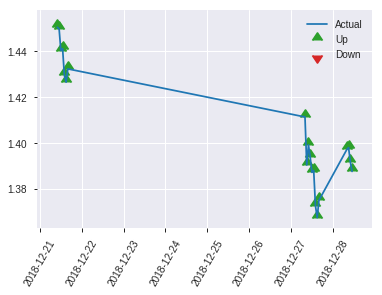


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.3086997633434274
RMSE: 0.5556075623526262
LogLoss: 0.8902759446136754
Mean Per-Class Error: 0.43892151186833184
AUC: 0.5412290133156894
pr_auc: 0.551113187214172
Gini: 0.0824580266313788
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14043451602029922: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      9    98   0.9159   (98.0/107.0)
1      2    111  0.0177   (2.0/113.0)
Total  11   209  0.4545   (100.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.140435     0.689441  208
max f2                       0.0360032    0.840774  219
max f0point5                 0.140435     0.584826  208
max accuracy                 0.591542     0.563636  130
max precision                0.984845     1         0
max recall                   0.0360032    1         219
max specificity              0.984845     1         0
max absolute_mcc             0.140435     0.152305  208
max min_per_class_accuracy   0.687403     0.53271   110
max mean_per_class_accuracy  0.591542     0.561078  130

Gains/Lift Table: Avg response rate: 51.36 %, avg score: 62.35 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.976427           1.29794   1.29794            0.666667         0.980409  0.666667                    0.980409            0.0176991       0.0176991                  29.7935   29.7935
    2        0.0227273                   0.968247           1.9469    1.55752            1                0.971293  0.8                         0.976762            0.0176991       0.0353982                  94.6903   55.7522
    3        0.0318182                   0.962218           1.9469    1.66877            1                0.962942  0.857143                    0.972814            0.0176991       0.0530973                  94.6903   66.8774
    4        0.0409091                   0.957772           0.973451  1.51426            0.5              0.961716  0.777778                    0.970347            0.00884956      0.0619469                  -2.65487  51.4258
    5        0.05                        0.955416           0.973451  1.41593            0.5              0.956529  0.727273                    0.967835            0.00884956      0.0707965                  -2.65487  41.5929
    6        0.1                         0.929256           0.530973  0.973451           0.272727         0.94649   0.5                         0.957163            0.0265487       0.0973451                  -46.9027  -2.65487
    7        0.15                        0.901292           1.23894   1.06195            0.636364         0.912916  0.545455                    0.942414            0.0619469       0.159292                   23.8938   6.19469
    8        0.2                         0.871213           1.06195   1.06195            0.545455         0.890233  0.545455                    0.929368            0.0530973       0.212389                   6.19469   6.19469
    9        0.3                         0.794813           0.973451  1.03245            0.5              0.830368  0.530303                    0.896368            0.0973451       0.309735                   -2.65487  3.24484
    10       0.4                         0.749971           1.15044   1.06195            0.590909         0.774374  0.545455                    0.86587             0.115044        0.424779                   15.0442   6.19469
    11       0.5                         0.687645           1.06195   1.06195            0.545455         0.721887  0.545455                    0.837073            0.106195        0.530973                   6.19469   6.19469
    12       0.6                         0.583334           1.23894   1.09145            0.636364         0.633578  0.560606                    0.803157            0.123894        0.654867                   23.8938   9.14454
    13       0.7                         0.506951           0.619469  1.02402            0.318182         0.546124  0.525974                    0.766438            0.0619469       0.716814                   -38.0531  2.40202
    14       0.8                         0.371088           1.06195   1.02876            0.545455         0.443963  0.528409                    0.726129            0.106195        0.823009                   6.19469   2.87611
    15       0.9                         0.21345            0.884956  1.01278            0.454545         0.295016  0.520202                    0.678228            0.0884956       0.911504                   -11.5044  1.27827
    16       1                           0.0360032          0.884956  1                  0.454545         0.130891  0.513636                    0.623494        

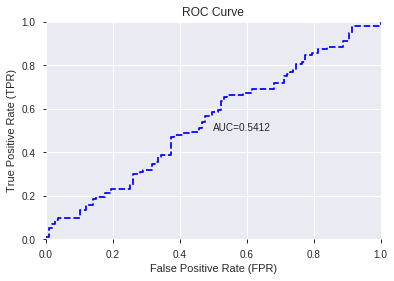

This function is available for GLM models only


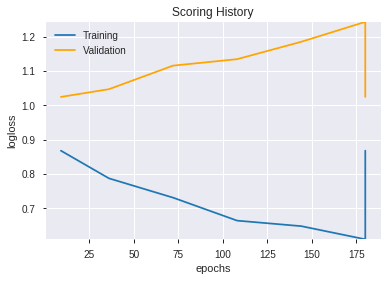

--2019-08-28 19:31:58--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.130.251
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.130.251|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


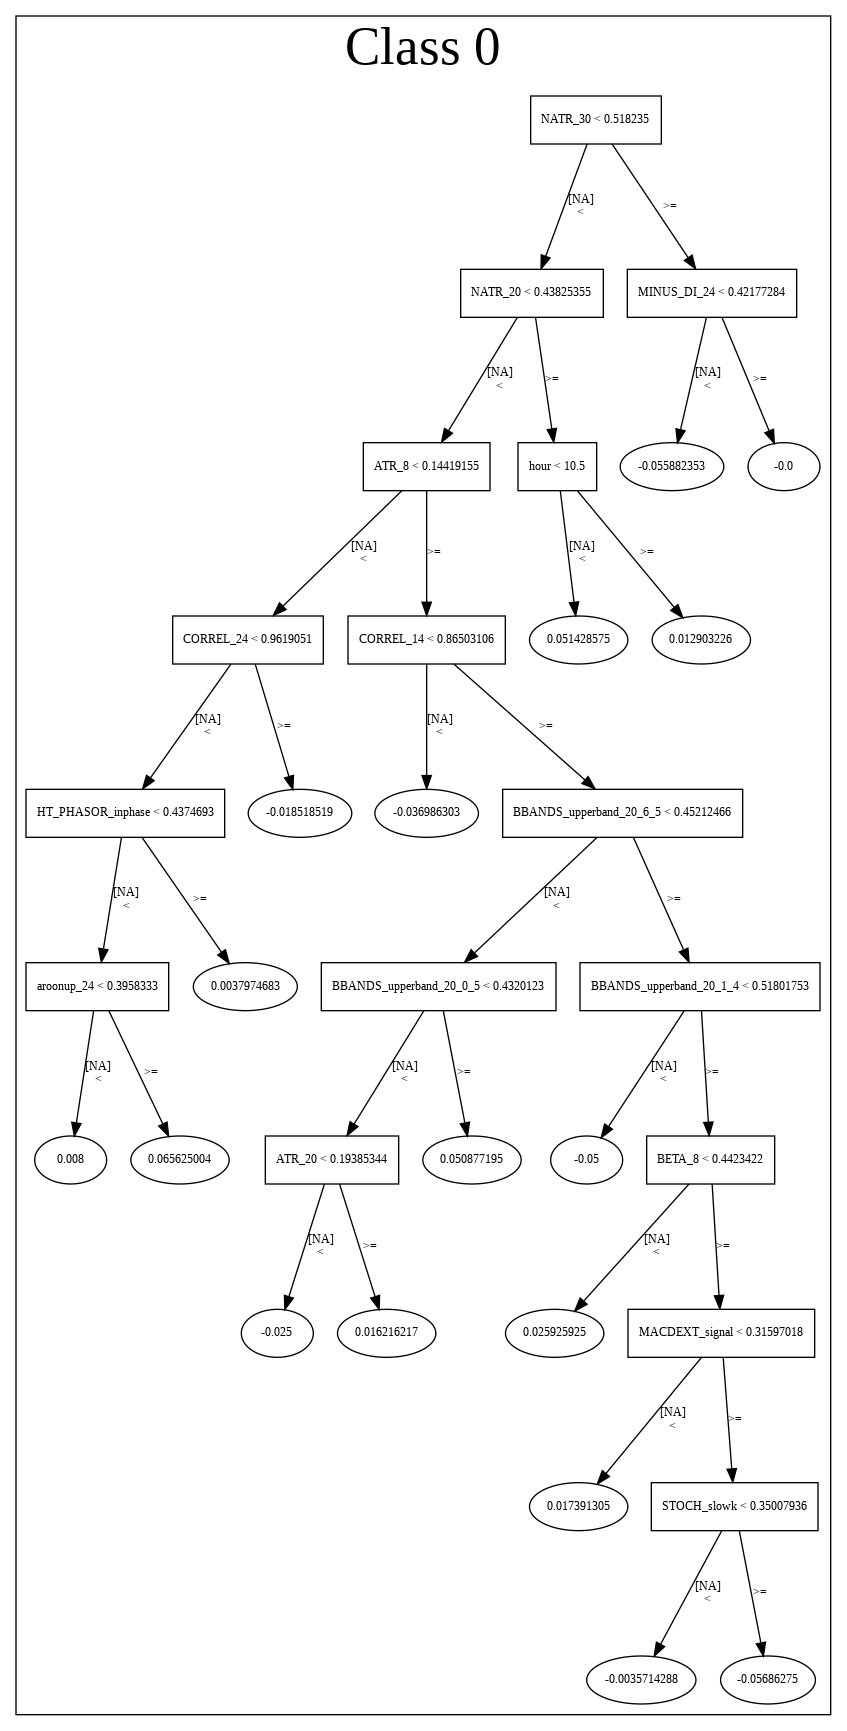

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_192439_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_192439_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_a8f4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLEVENINGDOJISTAR',
 'day',
 'CDLIDENTICAL3CROWS',
 'CDLSHOOTINGSTAR',
 'CDLHIKKAKEMOD',
 'CDLGAPSIDESIDEWHITE',
 'CDLINVERTEDHAMMER',
 'SIN',
 'STOCHRSI_fastd',
 'hour',
 'BOP',
 'CDLLADDERBOTTOM',
 'STOCHRSI_fastk',
 'CDL3WHITESOLDIERS',
 'CDLRISEFALL3METHODS',
 'days_in_month',
 'HT_PHASOR_quadrature',
 'aroondown_14',
 'HT_TRENDMODE',
 'aroondown_12',
 'SAREXT',
 'HT_DCPERIOD',
 'aroonup_24',
 'CORREL_8',
 'DX_8',
 'aroondown_8',
 'DX_24',
 'aroonup_8',
 'weekday_name',
 'weekday',
 'aroondown_30',
 'Volume',
 'BETA_12',
 'dayofweek',
 'aroondown_20',
 'BETA_14',
 'STOCH_slowd',
 'aroonup_20',
 'CDLSPINNINGTOP',
 'PLUS_DI_30',
 'MFI_20',
 'CDLLONGLEGGEDDOJI',
 'DX_14',
 'CDLDOJI',
 'AROONOSC_8',
 'BETA_8',
 'DX_12',
 'CDLRICKSHAWMAN',
 'AROONOSC_20',
 'CDLMATCHINGLOW']

In [20]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_193204_model_1  0.511951  0.692954              0.475891  0.499903  0.249903

variable  relative_importance  scaled_importance  percentage
0      CDLINVERTEDHAMMER             0.009413           1.000000    0.061264
1          days_in_month             0.008662           0.920261    0.056378
2         CDLMATCHINGLOW             0.007625           0.810080    0.049628
3                   DX_8             0.006376           0.677393    0.041499
4              aroonup_8             0.006107           0.648764    0.039746
5           aroondown_14             0.005773           0.613331    0.037575
6           aroondown_20             0.005675           0.602859    0.036933
7         CDLRICKSHAWMAN             0.005400           0.573729    0.035149
8                  DX_12             0.005221           0.554645    0.033979
9               CORREL_8             0.004826           0.512696    0.031410
10       CDLSHOOTINGSTAR             0.004739           0.503487    0.030845
11                   day             0.004731           0.502656    0.030794
12                 DX_14             0.004702           0.499518    0.030602
13     CDLLONGLEGGEDDOJI             0.004456           0.473350    0.028999
14               CDLDOJI             0.004451           0.472863    0.028969
15  HT_PHASOR_quadrature             0.003960           0.420729    0.025775
16               BETA_14             0.003810           0.404799    0.024799
17          HT_TRENDMODE             0.003757           0.399171    0.024455
18                   SIN             0.003716           0.394816    0.024188
19       CDLLADDERBOTTOM             0.003554           0.377536    0.023129
20    CDLIDENTICAL3CROWS             0.003521           0.374091    0.022918
21   CDLGAPSIDESIDEWHITE             0.003470           0.368595    0.022581
22   CDLRISEFALL3METHODS             0.003446           0.366120    0.022430
23          aroondown_12             0.003347           0.355572    0.021784
24            AROONOSC_8             0.002903           0.308433    0.018896
25         CDLHIKKAKEMOD             0.002779           0.295248    0.018088
26           AROONOSC_20             0.002674           0.284087    0.017404
27               BETA_12             0.002459           0.261205    0.016002
28                SAREXT             0.002095           0.222545    0.013634
29                MFI_20             0.002066           0.219479    0.013446
30     CDL3WHITESOLDIERS             0.001910           0.202965    0.012434
31                 DX_24             0.001674           0.177792    0.010892
32           STOCH_slowd             0.001538           0.163383    0.010009
33               weekday             0.001442           0.153143    0.009382
34             dayofweek             0.001438           0.152737    0.009357
35            aroonup_24             0.001325           0.140805    0.008626
36           HT_DCPERIOD             0.001325           0.140752    0.008623
37        STOCHRSI_fastk             0.001219           0.129509    0.007934
38           aroondown_8             0.001133           0.120333    0.007372
39            aroonup_20             0.001090           0.115819    0.007095
40        STOCHRSI_fastd             0.001004           0.106661    0.006534
41                Volume             0.000778           0.082602    0.005060
42                   BOP             0.000666           0.070760    0.004335
43          weekday_name             0.000467           0.049590    0.003038
44                  hour             0.000463           0.049141    0.003011
45        CDLSPINNINGTOP             0.000225           0.023911    0.001465
46            PLUS_DI_30             0.000115           0.012250    0.000750
47          aroondown_30             0.000063           0.006686    0.000410
48    CDLEVENINGDOJISTAR             0.000033           0.003551    0.000218
49                BETA_8             0.000023           0.002479    0.000152

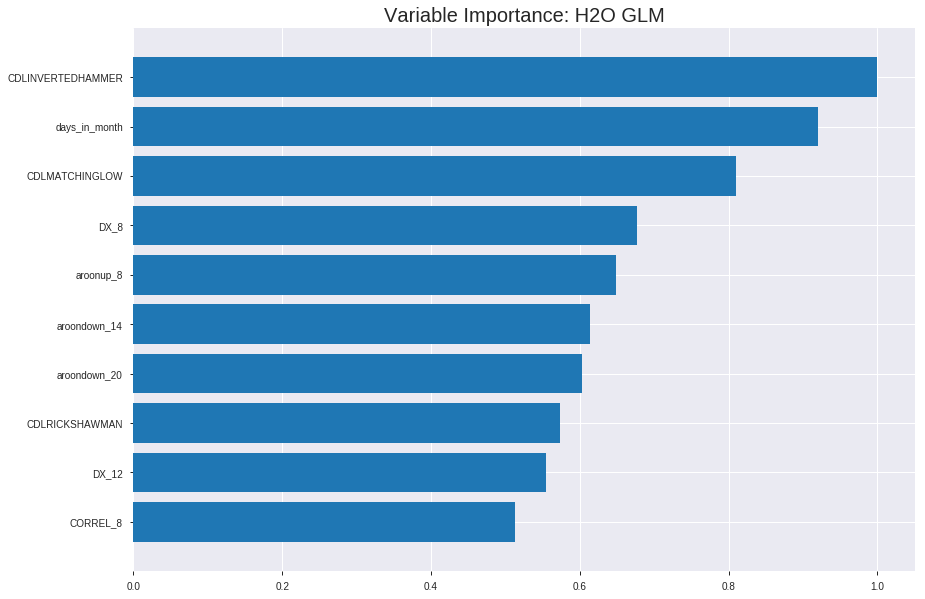

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_193204_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24863559633162063
RMSE: 0.4986337296369156
LogLoss: 0.6904160948585977
Null degrees of freedom: 1536
Residual degrees of freedom: 1486
Null deviance: 2130.499553929498
Residual deviance: 2122.339075595329
AIC: 2224.339075595329
AUC: 0.5790869463608929
pr_auc: 0.5842004409991992
Gini: 0.15817389272178572
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4888841476964431: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      24   735   0.9684   (735.0/759.0)
1      4    774   0.0051   (4.0/778.0)
Total  28   1509  0.4808   (739.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.488884     0.676869  380
max f2                       0.48592      0.838007  388
max f0point5                 0.502546     0.578303  253
max accuracy                 0.502659     0.562785  252
max precision                0.54946      1         0
max recall                   0.483673     1         393
max specificity              0.54946      1         0
max absolute_mcc             0.51018      0.132738  158
max min_per_class_accuracy   0.506028     0.55527   209
max mean_per_class_accuracy  0.51018      0.562319  158

Gains/Lift Table: Avg response rate: 50.62 %, avg score: 50.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.531656           1.72863   1.72863            0.875            0.538014  0.875                       0.538014            0.0179949       0.0179949                  72.8631   72.8631
    2        0.0201692                   0.527036           1.31705   1.52948            0.666667         0.528815  0.774194                    0.533563            0.0128535       0.0308483                  31.7052   52.948
    3        0.0305791                   0.524405           1.60516   1.55524            0.8125           0.525833  0.787234                    0.530932            0.0167095       0.0475578                  60.5157   55.5243
    4        0.0403383                   0.522728           0.921937  1.40202            0.466667         0.523549  0.709677                    0.529146            0.00899743      0.0565553                  -7.80634  40.2023
    5        0.0500976                   0.521111           0.790231  1.28284            0.4              0.521876  0.649351                    0.527729            0.00771208      0.0642674                  -20.9769  28.2843
    6        0.100195                    0.517465           1.15456   1.2187             0.584416         0.518895  0.616883                    0.523312            0.0578406       0.122108                   15.4559   21.8701
    7        0.150293                    0.514934           1.23153   1.22298            0.623377         0.516052  0.619048                    0.520892            0.0616967       0.183805                   23.1529   22.2977
    8        0.20039                     0.513316           0.923647  1.14814            0.467532         0.514155  0.581169                    0.519208            0.0462725       0.230077                   -7.6353   14.8145
    9        0.299935                    0.510786           1.25249   1.18278            0.633987         0.512072  0.598698                    0.51684             0.124679        0.354756                   25.2491   18.2776
    10       0.40013                     0.508418           1.01345   1.14037            0.512987         0.509654  0.577236                    0.51504             0.101542        0.456298                   1.34461   14.0375
    11       0.500325                    0.506013           0.987789  1.10982            0.5              0.507147  0.561769                    0.51346             0.0989717       0.55527                    -1.22108  10.9818
    12       0.59987                     0.503455           0.968421  1.08635            0.490196         0.504656  0.549892                    0.511999            0.096401        0.651671                   -3.15792  8.63539
    13       0.700065                    0.501235           0.962132  1.06857            0.487013         0.502322  0.540892                    0.510614            0.096401        0.748072                   -3.78677  6.85749
    14       0.79961                     0.498351           0.839298  1.04003            0.424837         0.499861  0.526444                    0.509275            0.0835476       0.83162                    -16.0702  4.00319
    15       0.899805                    0.494799           0.936475  1.0285             0.474026         0.496609  0.520607                    0.507865            0.0938303       0.92545                    -6.35245  2.85007
    16       1                           0.458597           0.744049  1                  0.376623         0.491059  0.506181                    0.506181          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.25067350859382737
RMSE: 0.5006730555900001
LogLoss: 0.6944941467855008
Null degrees of freedom: 438
Residual degrees of freedom: 388
Null deviance: 608.2794432341497
Residual deviance: 609.7658608776698
AIC: 711.7658608776698
AUC: 0.4437702601612501
pr_auc: 0.489167087976637
Gini: -0.11245947967749981
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48732032611146536: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    212  1        (212.0/212.0)
1      0    227  0        (0.0/227.0)
Total  0    439  0.4829   (212.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.48732      0.681682  399
max f2                       0.48732      0.842613  399
max f0point5                 0.48732      0.572365  399
max accuracy                 0.48732      0.517084  399
max precision                0.540864     1         0
max recall                   0.48732      1         399
max specificity              0.540864     1         0
max absolute_mcc             0.492315     0.141928  386
max min_per_class_accuracy   0.507259     0.462555  201
max mean_per_class_accuracy  0.522123     0.508031  13

Gains/Lift Table: Avg response rate: 51.71 %, avg score: 50.67 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.524524           0.773568  0.773568           0.4              0.531895  0.4                         0.531895            0.00881057      0.00881057                 -22.6432  -22.6432
    2        0.0205011                   0.523443           0.96696   0.85952            0.5              0.523769  0.444444                    0.528283            0.00881057      0.0176211                  -3.30396  -14.048
    3        0.0318907                   0.522108           1.93392   1.24323            1                0.522908  0.642857                    0.526363            0.0220264       0.0396476                  93.3921   24.3235
    4        0.0410023                   0.521035           0.48348   1.0744             0.25             0.521546  0.555556                    0.525293            0.00440529      0.0440529                  -51.652   7.44004
    5        0.0501139                   0.520195           0.96696   1.05487            0.5              0.520732  0.545455                    0.524464            0.00881057      0.0528634                  -3.30396  5.48658
    6        0.100228                    0.516637           0.791149  0.923008           0.409091         0.518253  0.477273                    0.521358            0.0396476       0.092511                   -20.8851  -7.69924
    7        0.150342                    0.515348           1.05487   0.96696            0.545455         0.516115  0.5                         0.51961             0.0528634       0.145374                   5.48658   -3.30396
    8        0.200456                    0.51391            0.703244  0.901031           0.363636         0.514505  0.465909                    0.518334            0.0352423       0.180617                   -29.6756  -9.89688
    9        0.300683                    0.511449           1.01091   0.937659           0.522727         0.512536  0.484848                    0.516401            0.101322        0.281938                   1.09131   -6.23415
    10       0.400911                    0.509085           1.01091   0.955972           0.522727         0.51017   0.494318                    0.514843            0.101322        0.38326                    1.09131   -4.40278
    11       0.501139                    0.507162           0.835102  0.931798           0.431818         0.50804   0.481818                    0.513483            0.0837004       0.46696                    -16.4898  -6.82018
    12       0.599089                    0.504741           0.809548  0.911811           0.418605         0.505968  0.471483                    0.512254            0.0792952       0.546256                   -19.0452  -8.81895
    13       0.699317                    0.501656           1.01091   0.926014           0.522727         0.503125  0.478827                    0.510946            0.101322        0.647577                   1.09131   -7.39859
    14       0.799544                    0.498789           1.09882   0.947676           0.568182         0.500394  0.490028                    0.509623            0.110132        0.757709                   9.88186   -5.23238
    15       0.899772                    0.495704           1.05487   0.959616           0.545455         0.497217  0.496203                    0.508241            0.105727        0.863436                   5.48658   -4.03837
    16       1                           0.48732            1.36254   1                  0.704545         0.49307   0.517084                    0.5067


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 19:32:04  0.000 sec   2            3.4       51            1.38083           1.38899
    2019-08-28 19:32:04  0.021 sec   4            2.1       51            1.37839           1.39075
    2019-08-28 19:32:04  0.032 sec   6            1.3       51            1.37523           1.39321
    2019-08-28 19:32:04  0.043 sec   8            0.81      51            1.37137           1.39649
    2019-08-28 19:32:04  0.058 sec   10           0.5       51            1.36702           1.4006

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5409090909090909)

('F1', 0.6832298136645962)

('auc', 0.5119510379621206)

('logloss', 0.6929537884375155)

('mean_per_class_error', 0.46298900008270616)

('rmse', 0.49990316228582077)

('mse', 0.24990317166336365)

glm prediction progress: |████████████████████████████████████████████████| 100%


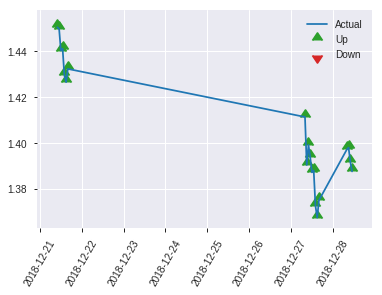


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24990317166336365
RMSE: 0.49990316228582077
LogLoss: 0.6929537884375155
Null degrees of freedom: 219
Residual degrees of freedom: 169
Null deviance: 304.8700323300008
Residual deviance: 304.89966691250686
AIC: 406.89966691250686
AUC: 0.5119510379621206
pr_auc: 0.5097551108223164
Gini: 0.023902075924241206
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4948642382069658: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    99   0.9252   (99.0/107.0)
1      3    110  0.0265   (3.0/113.0)
Total  11   209  0.4636   (102.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.494864     0.68323   208
max f2                       0.489924     0.840774  219
max f0point5                 0.495289     0.58127   203
max accuracy                 0.495289     0.540909  203
max precision                0.533976     1         0
max recall                   0.489924     1         219
max specificity              0.533976     1         0
max absolute_mcc             0.495289     0.112701  203
max min_per_class_accuracy   0.507241     0.530973  108
max mean_per_class_accuracy  0.507578     0.537011  104

Gains/Lift Table: Avg response rate: 51.36 %, avg score: 50.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.529327           0.648968  0.648968           0.333333         0.532119  0.333333                    0.532119            0.00884956      0.00884956                 -35.1032  -35.1032
    2        0.0227273                   0.525679           0.973451  0.778761           0.5              0.526885  0.4                         0.530025            0.00884956      0.0176991                  -2.65487  -22.1239
    3        0.0318182                   0.522868           1.9469    1.11252            1                0.52371   0.571429                    0.528221            0.0176991       0.0353982                  94.6903   11.2516
    4        0.0409091                   0.522004           0.973451  1.08161            0.5              0.522404  0.555556                    0.526928            0.00884956      0.0442478                  -2.65487  8.16126
    5        0.05                        0.520023           0         0.884956           0                0.52178   0.454545                    0.525992            0               0.0442478                  -100      -11.5044
    6        0.1                         0.516305           0.884956  0.884956           0.454545         0.518206  0.454545                    0.522099            0.0442478       0.0884956                  -11.5044  -11.5044
    7        0.15                        0.515067           1.23894   1.00295            0.636364         0.515811  0.515152                    0.520003            0.0619469       0.150442                   23.8938   0.294985
    8        0.2                         0.513774           1.06195   1.0177             0.545455         0.514374  0.522727                    0.518596            0.0530973       0.20354                    6.19469   1.76991
    9        0.3                         0.511088           1.15044   1.06195            0.590909         0.512328  0.545455                    0.516506            0.115044        0.318584                   15.0442   6.19469
    10       0.4                         0.50912            0.973451  1.03982            0.5              0.509937  0.534091                    0.514864            0.0973451       0.415929                   -2.65487  3.9823
    11       0.5                         0.5071             1.15044   1.06195            0.590909         0.508001  0.545455                    0.513492            0.115044        0.530973                   15.0442   6.19469
    12       0.6                         0.504672           0.79646   1.0177             0.409091         0.506179  0.522727                    0.512273            0.079646        0.610619                   -20.354   1.76991
    13       0.7                         0.501417           0.884956  0.998736           0.454545         0.502759  0.512987                    0.510914            0.0884956       0.699115                   -11.5044  -0.126422
    14       0.8                         0.498847           1.06195   1.00664            0.545455         0.499906  0.517045                    0.509538            0.106195        0.80531                    6.19469   0.663717
    15       0.9                         0.49563            1.06195   1.01278            0.545455         0.497216  0.520202                    0.508169            0.106195        0.911504                   6.19469   1.27827
    16       1                           0.489924           0.884956  1                  0.454545         0.494239  0.513636                    0.506776  

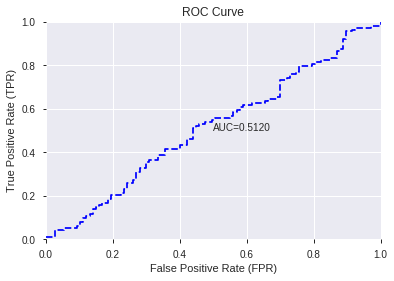

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


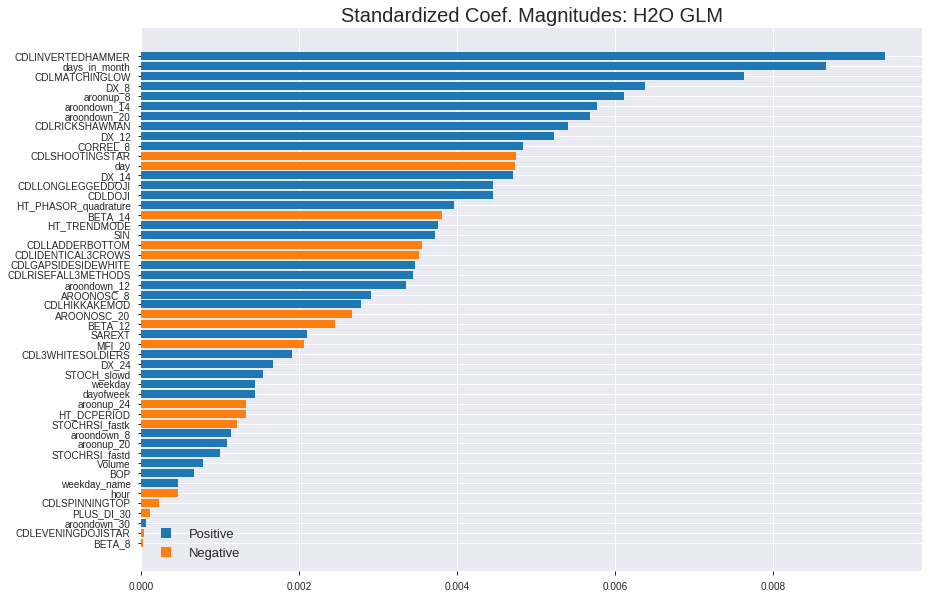

'log_likelihood'
--2019-08-28 19:32:10--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.36.188
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.36.188|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


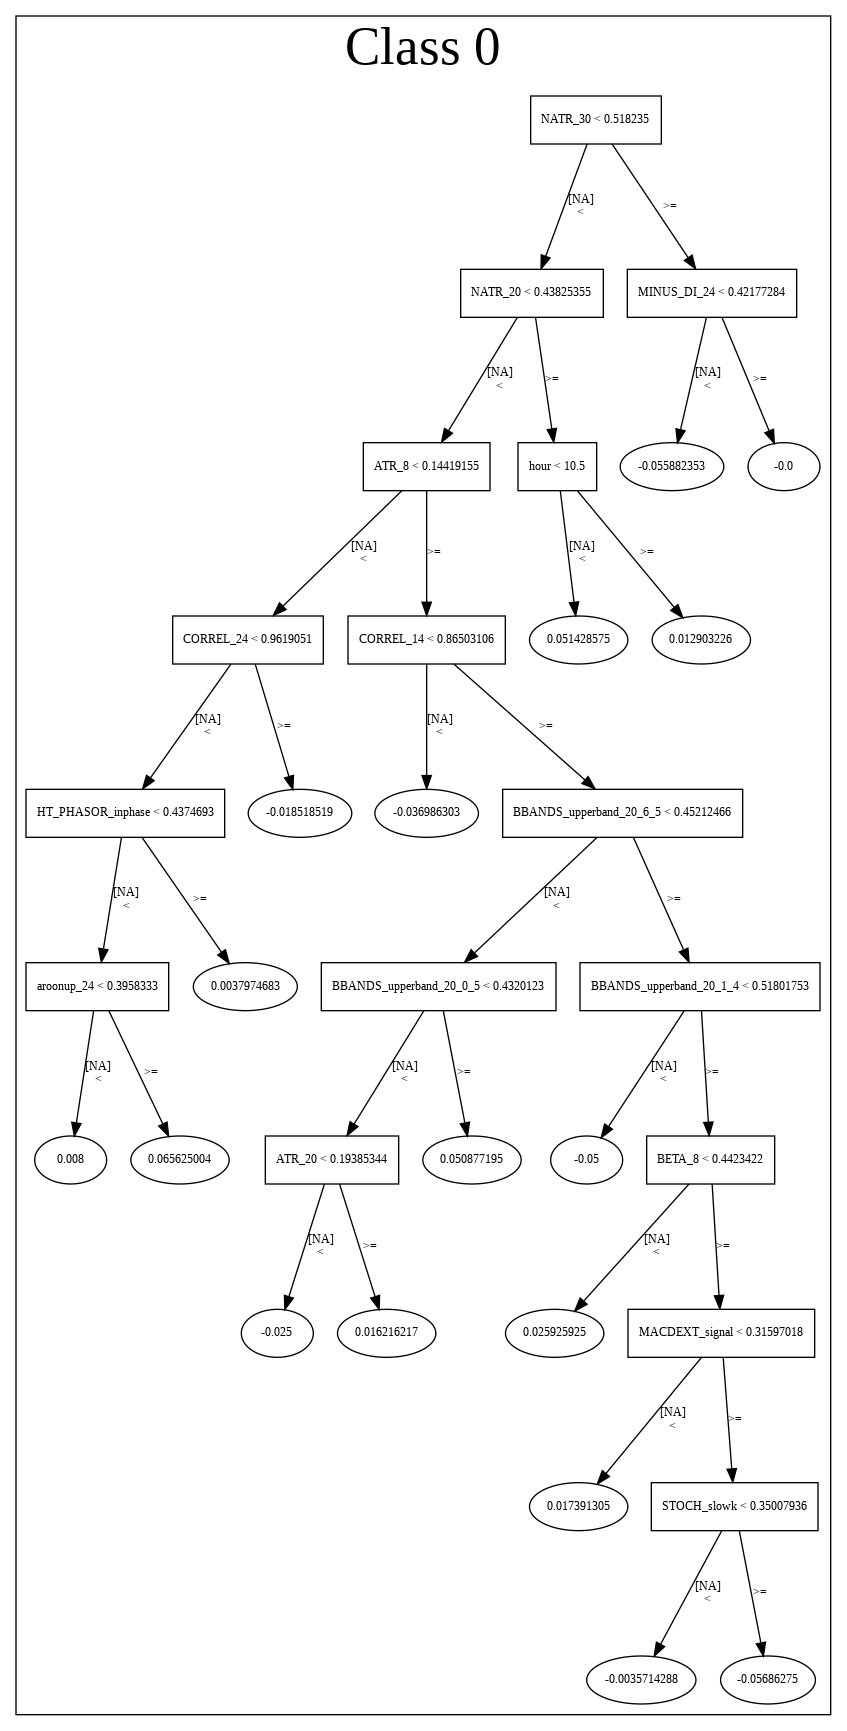

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_193204_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_193204_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_a8f4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['CDLINVERTEDHAMMER',
 'days_in_month',
 'CDLMATCHINGLOW',
 'DX_8',
 'aroonup_8',
 'aroondown_14',
 'aroondown_20',
 'CDLRICKSHAWMAN',
 'DX_12',
 'CORREL_8',
 'CDLSHOOTINGSTAR',
 'day',
 'DX_14',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJI',
 'HT_PHASOR_quadrature',
 'BETA_14',
 'HT_TRENDMODE',
 'SIN',
 'CDLLADDERBOTTOM',
 'CDLIDENTICAL3CROWS',
 'CDLGAPSIDESIDEWHITE',
 'CDLRISEFALL3METHODS',
 'aroondown_12',
 'AROONOSC_8',
 'CDLHIKKAKEMOD',
 'AROONOSC_20',
 'BETA_12',
 'SAREXT',
 'MFI_20',
 'CDL3WHITESOLDIERS',
 'DX_24',
 'STOCH_slowd',
 'weekday',
 'dayofweek',
 'aroonup_24',
 'HT_DCPERIOD',
 'STOCHRSI_fastk',
 'aroondown_8',
 'aroonup_20',
 'STOCHRSI_fastd',
 'Volume',
 'BOP',
 'weekday_name',
 'hour',
 'CDLSPINNINGTOP',
 'PLUS_DI_30',
 'aroondown_30',
 'CDLEVENINGDOJISTAR',
 'BETA_8']

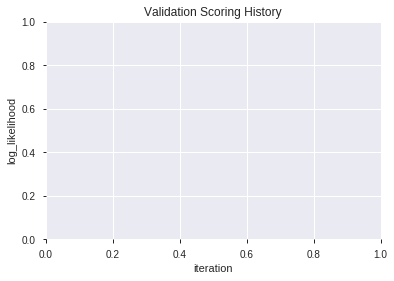

In [21]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_193216_model_6  0.507402  0.707440              0.490406  0.506744  0.256789
1  XGBoost_grid_1_AutoML_20190828_193216_model_4  0.488876  0.707441              0.500000  0.506911  0.256959
2  XGBoost_grid_1_AutoML_20190828_193216_model_5  0.484327  0.745275              0.500000  0.522706  0.273222
3  XGBoost_grid_1_AutoML_20190828_193216_model_3  0.481929  0.711830              0.495327  0.508995  0.259076
4  XGBoost_grid_1_AutoML_20190828_193216_model_1  0.472583  0.712603              0.500000  0.509334  0.259421
5               XGBoost_3_AutoML_20190828_193216  0.472335  0.711444              0.500000  0.508800  0.258877
6               XGBoost_2_AutoML_20190828_193216  0.465222  0.718676              0.500000  0.512252  0.262402
7  XGBoost_grid_1_AutoML_20190828_193216_model_7  0.449921  0.734137              0.495327  0.519164  0.269532
8  XGBoost_grid_1_AutoML_20190828_193216_model_2  0.443222  0.713017              0.500000  0.509626  0.259719
9               XGBoost_1_AutoML_20190828_193216  0.439170  0.735912              0.500000  0.519939  0.270336

variable  relative_importance  scaled_importance  percentage
0                    SIN           370.460144           1.000000    0.063867
1   HT_PHASOR_quadrature           351.813080           0.949665    0.060652
2                    BOP           303.485565           0.819212    0.052320
3            HT_DCPERIOD           293.108093           0.791200    0.050531
4                  DX_24           270.539673           0.730280    0.046641
5               CORREL_8           267.599213           0.722343    0.046134
6                 Volume           266.659363           0.719806    0.045972
7                   DX_8           254.219269           0.686226    0.043827
8         STOCHRSI_fastd           241.899094           0.652969    0.041703
9                 MFI_20           234.685211           0.633497    0.040459
10            PLUS_DI_30           213.538452           0.576414    0.036814
11                 DX_12           201.374329           0.543579    0.034717
12                SAREXT           197.492752           0.533101    0.034047
13           STOCH_slowd           192.282654           0.519037    0.033149
14               BETA_14           186.770691           0.504159    0.032199
15               BETA_12           162.634415           0.439007    0.028038
16                 DX_14           158.994278           0.429181    0.027410
17           AROONOSC_20           155.595627           0.420006    0.026824
18                   day           129.140472           0.348595    0.022264
19                BETA_8           124.711456           0.336639    0.021500
20          aroondown_14           122.540474           0.330779    0.021126
21        STOCHRSI_fastk           118.293030           0.319314    0.020393
22            AROONOSC_8           103.704399           0.279934    0.017878
23             aroonup_8            93.318901           0.251900    0.016088
24            aroonup_24            86.145294           0.232536    0.014851
25          aroondown_30            82.523705           0.222760    0.014227
26          aroondown_20            77.981178           0.210498    0.013444
27           aroondown_8            72.107094           0.194642    0.012431
28            aroonup_20            59.728939           0.161229    0.010297
29         days_in_month            58.706482           0.158469    0.010121
30                  hour            53.554306           0.144562    0.009233
31             dayofweek            52.478714           0.141658    0.009047
32        CDLSPINNINGTOP            48.728035           0.131534    0.008401
33          weekday_name            40.393806           0.109037    0.006964
34          aroondown_12            35.759212           0.096526    0.006165
35        CDLMATCHINGLOW            32.803459           0.088548    0.005655
36          HT_TRENDMODE            30.807468           0.083160    0.005311
37     CDLINVERTEDHAMMER            22.947123           0.061942    0.003956
38        CDLRICKSHAWMAN            14.586267           0.039373    0.002515
39               weekday            10.932865           0.029512    0.001885
40               CDLDOJI             5.485077           0.014806    0.000946

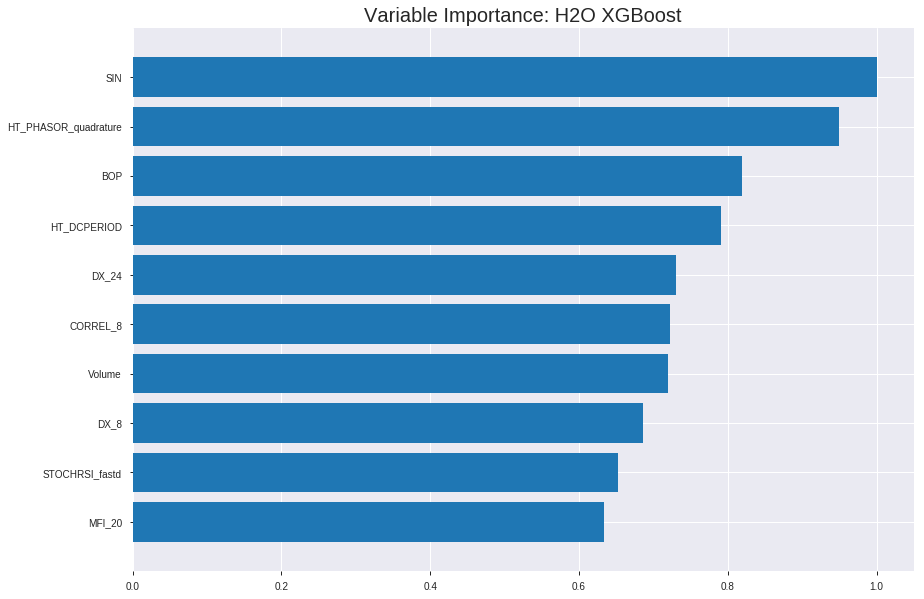

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_193216_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.18595879136330784
RMSE: 0.43122939529130877
LogLoss: 0.5617254098257642
Mean Per-Class Error: 0.13710114444997645
AUC: 0.9333143664204354
pr_auc: 0.9364153801897049
Gini: 0.8666287328408708
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49426180124282837: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      626  133  0.1752   (133.0/759.0)
1      77   701  0.099    (77.0/778.0)
Total  703  834  0.1366   (210.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.494262     0.869727  210
max f2                       0.451249     0.904179  255
max f0point5                 0.532602     0.882883  171
max accuracy                 0.494262     0.86337   210
max precision                0.786794     1         0
max recall                   0.345621     1         348
max specificity              0.786794     1         0
max absolute_mcc             0.494262     0.728393  210
max min_per_class_accuracy   0.5064       0.859025  198
max mean_per_class_accuracy  0.494262     0.862899  210

Gains/Lift Table: Avg response rate: 50.62 %, avg score: 50.57 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.719939           1.97558    1.97558            1                0.740409  1                           0.740409            0.0205656       0.0205656                  97.5578   97.5578
    2        0.0201692                   0.704008           1.97558    1.97558            1                0.710054  1                           0.725721            0.0192802       0.0398458                  97.5578   97.5578
    3        0.0305791                   0.692847           1.97558    1.97558            1                0.698668  1                           0.716512            0.0205656       0.0604113                  97.5578   97.5578
    4        0.0403383                   0.681665           1.97558    1.97558            1                0.687766  1                           0.709557            0.0192802       0.0796915                  97.5578   97.5578
    5        0.0500976                   0.672927           1.97558    1.97558            1                0.676989  1                           0.703213            0.0192802       0.0989717                  97.5578   97.5578
    6        0.100195                    0.641441           1.97558    1.97558            1                0.657199  1                           0.680206            0.0989717       0.197943                   97.5578   97.5578
    7        0.150293                    0.617368           1.94992    1.96703            0.987013         0.628573  0.995671                    0.662995            0.0976864       0.29563                    94.9922   96.7026
    8        0.20039                     0.599532           1.87295    1.94351            0.948052         0.608322  0.983766                    0.649327            0.0938303       0.38946                    87.2951   94.3507
    9        0.299935                    0.566101           1.75607    1.8813             0.888889         0.582039  0.952278                    0.626995            0.174807        0.564267                   75.607    88.1299
    10       0.40013                     0.535416           1.6677     1.82781            0.844156         0.550474  0.925203                    0.607833            0.167095        0.731362                   66.7696   82.7812
    11       0.500325                    0.507098           1.2187     1.70583            0.616883         0.520806  0.863459                    0.590405            0.122108        0.85347                    21.8701   70.5831
    12       0.59987                     0.478485           0.748912   1.54704            0.379085         0.492179  0.78308                     0.574105            0.0745501       0.928021                   -25.1088  54.7036
    13       0.700065                    0.444435           0.41051    1.38437            0.207792         0.461958  0.700743                    0.558054            0.0411311       0.969152                   -58.949   38.4374
    14       0.79961                     0.412702           0.16786    1.23293            0.0849673        0.427493  0.624085                    0.541801            0.0167095       0.985861                   -83.214   23.2928
    15       0.899805                    0.37457            0.102627   1.10707            0.0519481        0.396125  0.560376                    0.525579            0.0102828       0.996144                   -89.7373  10.7067
    16       1                           0.179307           0.0384853  1                  0.0194805        0.327465  0.506181                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.26074910780627536
RMSE: 0.5106359836579042
LogLoss: 0.7155817487714482
Mean Per-Class Error: 0.4853711245947967
AUC: 0.48079960103067076
pr_auc: 0.49041285081362285
Gini: -0.03840079793865847
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2871020436286926: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    211  0.9953   (211.0/212.0)
1      0    227  0        (0.0/227.0)
Total  1    438  0.4806   (211.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.287102     0.682707  398
max f2                       0.287102     0.843239  398
max f0point5                 0.287102     0.573522  398
max accuracy                 0.320495     0.519362  396
max precision                0.488589     0.531532  202
max recall                   0.287102     1         398
max specificity              0.745507     0.995283  0
max absolute_mcc             0.576184     0.106497  56
max min_per_class_accuracy   0.489538     0.509434  200
max mean_per_class_accuracy  0.488589     0.514629  202

Gains/Lift Table: Avg response rate: 51.71 %, avg score: 49.11 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.682178           0.386784  0.386784           0.2              0.71692   0.2                         0.71692             0.00440529      0.00440529                 -61.3216  -61.3216
    2        0.0205011                   0.65872            1.45044   0.85952            0.75             0.67007   0.444444                    0.696097            0.0132159       0.0176211                  45.0441   -14.048
    3        0.0318907                   0.64812            0.773568  0.828823           0.4              0.652359  0.428571                    0.680477            0.00881057      0.0264317                  -22.6432  -17.1177
    4        0.0410023                   0.64366            0.48348   0.75208            0.25             0.645741  0.388889                    0.672758            0.00440529      0.030837                   -51.652   -24.792
    5        0.0501139                   0.632406           0.96696   0.791149           0.5              0.639113  0.409091                    0.666641            0.00881057      0.0396476                  -3.30396  -20.8851
    6        0.100228                    0.593887           0.703244  0.747197           0.363636         0.610147  0.386364                    0.638394            0.0352423       0.0748899                  -29.6756  -25.2803
    7        0.150342                    0.570462           0.96696   0.820451           0.5              0.579727  0.424242                    0.618838            0.0484581       0.123348                   -3.30396  -17.9549
    8        0.200456                    0.550829           1.05487   0.879055           0.545455         0.56084   0.454545                    0.604339            0.0528634       0.176211                   5.48658   -12.0945
    9        0.300683                    0.527825           0.923008  0.893706           0.477273         0.539965  0.462121                    0.582881            0.092511        0.268722                   -7.69924  -10.6294
    10       0.400911                    0.504622           1.31858   0.999925           0.681818         0.515038  0.517045                    0.56592             0.132159        0.400881                   31.8582   -0.00750901
    11       0.501139                    0.489538           1.09882   1.0197             0.568182         0.496831  0.527273                    0.552102            0.110132        0.511013                   9.88186   1.97036
    12       0.599089                    0.474183           0.899498  1.00005            0.465116         0.481916  0.51711                     0.540627            0.0881057       0.599119                   -10.0502  0.00502504
    13       0.699317                    0.448808           1.01091   1.00161            0.522727         0.462149  0.517915                    0.529379            0.101322        0.700441                   1.09131   0.160714
    14       0.799544                    0.424579           0.923008  0.991754           0.477273         0.436228  0.512821                    0.517702            0.092511        0.792952                   -7.69924  -0.824579
    15       0.899772                    0.393873           0.923008  0.984096           0.477273         0.409664  0.508861                    0.505668            0.092511        0.885463                   -7.69924  -1.59036
    16       1                           0.26169            1.14277   1                  0.590909         0.359952  0.517084                   


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 19:32:27  6.920 sec   0                  0.5              0.693147            0.5             0                  1                0.493819                         0.5                0.693147              0.5               0                    1                  0.482916
    2019-08-28 19:32:27  7.027 sec   5                  0.491578         0.676415            0.738683        0.745492           1.97558          0.348081                         0.501886           0.696943              0.472207          0.478639             0.386784           0.47836
    2019-08-28 19:32:27  7.105 sec   10                 0.482845         0.659286            0.810745        0.813935           1.97558          0.281718                         0.50384            0.700908              0.460134          0.472897             0.773568           0.480638
    2019-08-28 19:32:27  7.165 sec   15                 0.474344         0.642804            0.848088        0.849069           1.97558          0.239427                         0.505501           0.704357              0.465547          0.474102             0.773568           0.482916
    2019-08-28 19:32:27  7.232 sec   20                 0.466262         0.627288            0.870585        0.870947           1.97558          0.219909                         0.507212           0.707868              0.453952          0.468262             0.773568           0.480638
    2019-08-28 19:32:27  7.292 sec   25                 0.4589           0.613285            0.884992        0.885451           1.97558          0.20039                          0.5081             0.709817              0.460415          0.475182             0.773568           0.480638
    2019-08-28 19:32:27  7.357 sec   30                 0.453011         0.602135            0.896337        0.89715            1.97558          0.187378                         0.509501           0.712811              0.458472          0.472765             0.773568           0.480638
    2019-08-28 19:32:28  7.426 sec   35                 0.445567         0.588275            0.913511        0.915967           1.97558          0.167209                         0.511088           0.716244              0.457599          0.475207             0.386784           0.480638
    2019-08-28 19:32:28  7.487 sec   40                 0.439279         0.576585            0.921925        0.924407           1.97558          0.1581                           0.511193           0.71657               0.464695          0.481642             0.386784           0.480638
    2019-08-28 19:32:28  7.546 sec   45                 0.435671         0.569948            0.92864         0.931138           1.97558          0.148341                         0.511718           0.717803              0.468882          0.484792             0.773568           0.480638
    2019-08-28 19:32:28  7.604 sec   50                 0.431229         0.561725            0.933314        0.936415           1.97558          0.13663                          0.510636           0.715582              0.4808            0.490413             0.386784           0.480638

Variable Importances: 


variable              relative_importance    scaled_importance     percentage
--------------------  ---------------------  --------------------  ---------------------
SIN                   370.46014404296875     1.0                   0.06386660629884032
HT_PHASOR_quadrature  351.8130798339844      0.9496651272509856    0.0606518887978768
BOP                   303.4855651855469      0.8192124579812999    0.05232031952899696
HT_DCPERIOD           293.10809326171875     0.7912000736784303    0.05053126360923376
DX_24                 270.5396728515625      0.7302801048962052    0.04664051194728175
---                   ---                    ---                   ---
HT_TRENDMODE          30.80746841430664      0.0831600076545167    0.005311147468679566
CDLINVERTEDHAMMER     22.94712257385254      0.06194221684260577   0.003956039176364099
CDLRICKSHAWMAN        14.58626651763916      0.03937337592771474   0.002514643899031594
weekday               10.932865142822266     0.02951158260510256   0.0018848046274957898
CDLDOJI               5.485077381134033      0.014806120089662958  0.0009456166425798546


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5363636363636364)

('F1', 0.6808510638297872)

('auc', 0.5074021999834588)

('logloss', 0.7074395721351895)

('mean_per_class_error', 0.4615002894715078)

('rmse', 0.5067438175108467)

('mse', 0.25678929658546634)

xgboost prediction progress: |████████████████████████████████████████████| 100%


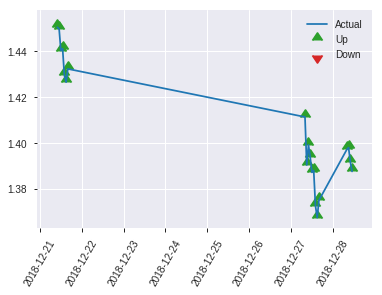


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25678929658546634
RMSE: 0.5067438175108467
LogLoss: 0.7074395721351895
Mean Per-Class Error: 0.4615002894715078
AUC: 0.5074021999834588
pr_auc: 0.5090184098795708
Gini: 0.014804399966917625
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3374539911746979: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    104  0.972    (104.0/107.0)
1      1    112  0.0088   (1.0/113.0)
Total  4    216  0.4773   (105.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.337454     0.680851   215
max f2                       0.264174     0.840774   219
max f0point5                 0.337454     0.573183   215
max accuracy                 0.49599      0.536364   92
max precision                0.506306     0.559524   83
max recall                   0.264174     1          219
max specificity              0.715412     0.990654   0
max absolute_mcc             0.663378     0.0984315  1
max min_per_class_accuracy   0.483895     0.504425   106
max mean_per_class_accuracy  0.49599      0.5385     92

Gains/Lift Table: Avg response rate: 51.36 %, avg score: 48.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.655338           0.648968  0.648968           0.333333         0.678127  0.333333                    0.678127            0.00884956      0.00884956                 -35.1032  -35.1032
    2        0.0227273                   0.63356            0.973451  0.778761           0.5              0.644325  0.4                         0.664606            0.00884956      0.0176991                  -2.65487  -22.1239
    3        0.0318182                   0.627552           0.973451  0.834387           0.5              0.631607  0.428571                    0.655178            0.00884956      0.0265487                  -2.65487  -16.5613
    4        0.0409091                   0.620103           0         0.648968           0                0.623635  0.333333                    0.648168            0               0.0265487                  -100      -35.1032
    5        0.05                        0.61138            1.9469    0.884956           1                0.615741  0.454545                    0.642272            0.0176991       0.0442478                  94.6903   -11.5044
    6        0.1                         0.589766           0.884956  0.884956           0.454545         0.598881  0.454545                    0.620577            0.0442478       0.0884956                  -11.5044  -11.5044
    7        0.15                        0.565721           1.06195   0.943953           0.545455         0.574244  0.484848                    0.605133            0.0530973       0.141593                   6.19469   -5.60472
    8        0.2                         0.55012            1.41593   1.06195            0.727273         0.557199  0.545455                    0.593149            0.0707965       0.212389                   41.5929   6.19469
    9        0.3                         0.517629           1.06195   1.06195            0.545455         0.534214  0.545455                    0.573504            0.106195        0.318584                   6.19469   6.19469
    10       0.4                         0.498981           1.06195   1.06195            0.545455         0.510038  0.545455                    0.557638            0.106195        0.424779                   6.19469   6.19469
    11       0.5                         0.481428           0.79646   1.00885            0.409091         0.489469  0.518182                    0.544004            0.079646        0.504425                   -20.354   0.884956
    12       0.6                         0.464403           0.973451  1.00295            0.5              0.472904  0.515152                    0.532154            0.0973451       0.60177                    -2.65487  0.294985
    13       0.7                         0.441965           0.884956  0.986094           0.454545         0.453161  0.506494                    0.520869            0.0884956       0.690265                   -11.5044  -1.39064
    14       0.8                         0.417904           1.15044   1.00664            0.590909         0.431795  0.517045                    0.509735            0.115044        0.80531                    15.0442   0.663717
    15       0.9                         0.385928           0.884956  0.993117           0.454545         0.403795  0.510101                    0.497964            0.0884956       0.893805                   -11.5044  -0.688299
    16       1                           0.264174           1.06195   1                  0.545455         0.350671  0.513636                    0.48

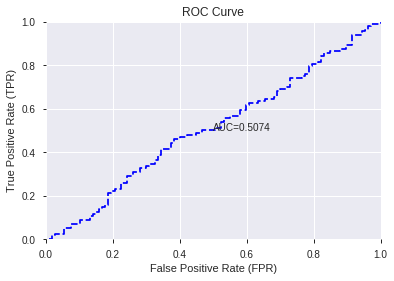

This function is available for GLM models only


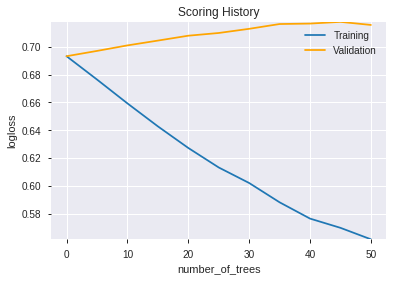

--2019-08-28 19:32:34--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.82.200
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.82.200|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

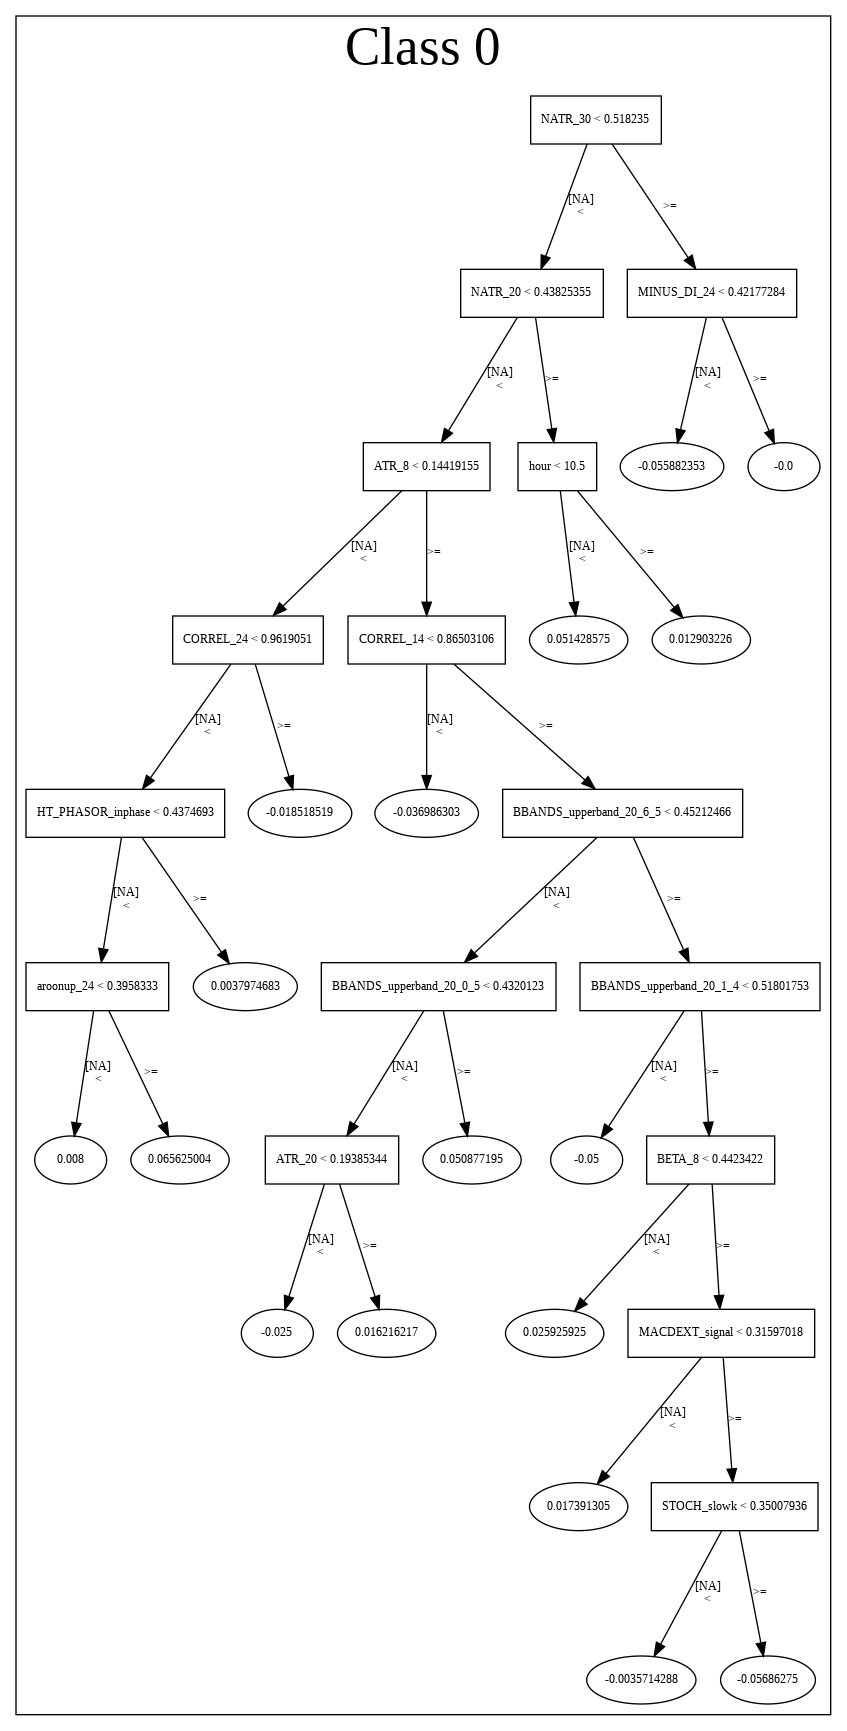

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_193216_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_193216_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_a8f4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['SIN',
 'HT_PHASOR_quadrature',
 'BOP',
 'HT_DCPERIOD',
 'DX_24',
 'CORREL_8',
 'Volume',
 'DX_8',
 'STOCHRSI_fastd',
 'MFI_20',
 'PLUS_DI_30',
 'DX_12',
 'SAREXT',
 'STOCH_slowd',
 'BETA_14',
 'BETA_12',
 'DX_14',
 'AROONOSC_20',
 'day',
 'BETA_8',
 'aroondown_14',
 'STOCHRSI_fastk',
 'AROONOSC_8',
 'aroonup_8',
 'aroonup_24',
 'aroondown_30',
 'aroondown_20',
 'aroondown_8',
 'aroonup_20',
 'days_in_month',
 'hour',
 'dayofweek',
 'CDLSPINNINGTOP',
 'weekday_name',
 'aroondown_12',
 'CDLMATCHINGLOW',
 'HT_TRENDMODE',
 'CDLINVERTEDHAMMER',
 'CDLRICKSHAWMAN',
 'weekday',
 'CDLDOJI']

In [22]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [24]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [25]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [26]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [28]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [29]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [30]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [32]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [33]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [34]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [36]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [37]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [38]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [40]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [41]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [42]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [44]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [45]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [46]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [47]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [12] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_193242_model_1  0.567902  1.604904              0.452279  0.598037  0.357648
1  DeepLearning_grid_1_AutoML_20190828_193242_model_4  0.526011  0.787094              0.500000  0.529995  0.280895
2  DeepLearning_grid_1_AutoML_20190828_193242_model_8  0.505086  0.692937              0.500000  0.499895  0.249895
3               DeepLearning_1_AutoML_20190828_193242  0.503929  0.690696              0.481060  0.499344  0.249345
4  DeepLearning_grid_1_AutoML_20190828_193242_model_6  0.502481  0.693174              0.481060  0.500014  0.250014
5  DeepLearning_grid_1_AutoML_20190828_193242_model_9  0.500000  0.695356              0.500000  0.501095  0.251097
6  DeepLearning_grid_1_AutoML_20190828_193242_model_5  0.500000  0.692852              0.500000  0.499852  0.249852
7  DeepLearning_grid_1_AutoML_20190828_193242_model_3  0.499876  0.735081              0.500000  0.518182  0.268513
8  DeepLearning_grid_1_AutoML_20190828_193242_model_2  0.496071  0.713200              0.495327  0.509579  0.259671
9  DeepLearning_grid_1_AutoML_20190828_193242_model_7  0.491523  0.706033              0.490654  0.506246  0.256285

variable  relative_importance  scaled_importance  percentage
0          CDLGAPSIDESIDEWHITE             1.000000           1.000000    0.001094
1               is_month_start             0.999982           0.999982    0.001094
2              CDLSHOOTINGSTAR             0.992497           0.992497    0.001086
3           CDLIDENTICAL3CROWS             0.970447           0.970447    0.001062
4               CDLMATCHINGLOW             0.967649           0.967649    0.001059
...                        ...                  ...                ...         ...
1028  BBANDS_middleband_24_3_5             0.818296           0.818296    0.000895
1029   BBANDS_lowerband_24_1_5             0.817528           0.817528    0.000894
1030  BBANDS_middleband_12_4_3             0.816391           0.816391    0.000893
1031   BBANDS_lowerband_12_1_4             0.809234           0.809234    0.000885
1032  BBANDS_middleband_12_7_2             0.799937           0.799937    0.000875

[1033 rows x 4 columns]

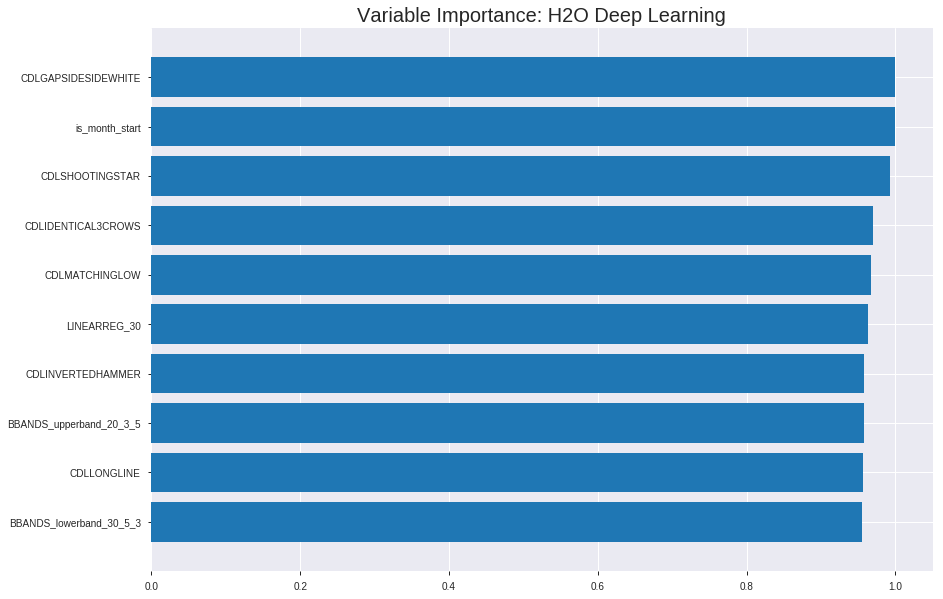

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_193242_model_1


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.3810318575133632
RMSE: 0.6172777798636229
LogLoss: 2.7790992524205613
Mean Per-Class Error: 0.4035549413888522
AUC: 0.6018565559473126
pr_auc: 0.5300122316445682
Gini: 0.20371311189462515
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.0267391997991606e-05: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    759   1        (759.0/759.0)
1      0    778   0        (0.0/778.0)
Total  0    1537  0.4938   (759.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       1.02674e-05  0.672138  399
max f2                       1.02674e-05  0.836739  399
max f0point5                 0.895916     0.592061  87
max accuracy                 0.899894     0.594665  84
max precision                0.999981     0.720339  0
max recall                   1.02674e-05  1         399
max specificity              0.999981     0.956522  0
max absolute_mcc             0.958934     0.208436  50
max min_per_class_accuracy   0.347359     0.564267  241
max mean_per_class_accuracy  0.899894     0.596445  84

Gains/Lift Table: Avg response rate: 50.62 %, avg score: 46.75 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0104099                   1                  1.48168   1.48168            0.75             1            0.75                        1                   0.0154242       0.0154242                  48.1684    48.1684
    2        0.0201692                   0.999999           1.58046   1.52948            0.8              1            0.774194                    1                   0.0154242       0.0308483                  58.0463    52.948
    3        0.0305791                   0.999996           1.8521    1.63931            0.9375           0.999997     0.829787                    0.999999            0.0192802       0.0501285                  85.2105    63.931
    4        0.0403383                   0.999988           0.921937  1.46575            0.466667         0.999993     0.741935                    0.999997            0.00899743      0.059126                   -7.80634   46.5752
    5        0.0500976                   0.99998            1.71217   1.51375            0.866667         0.999985     0.766234                    0.999995            0.0167095       0.0758355                  71.2168    51.3755
    6        0.100195                    0.999673           1.3085    1.41113            0.662338         0.999877     0.714286                    0.999936            0.0655527       0.141388                   30.85      41.1127
    7        0.150293                    0.998538           1.23153   1.35126            0.623377         0.999225     0.683983                    0.999699            0.0616967       0.203085                   23.1529    35.1261
    8        0.20039                     0.995794           1.1289    1.29567            0.571429         0.997272     0.655844                    0.999092            0.0565553       0.25964                    12.8902    29.5672
    9        0.299935                    0.966447           1.31705   1.30277            0.666667         0.986251     0.659436                    0.99483             0.131105        0.390746                   31.7052    30.2768
    10       0.40013                     0.80834            0.936475  1.21105            0.474026         0.904674     0.613008                    0.972255            0.0938303       0.484576                   -6.35245   21.1046
    11       0.500325                    0.345503           0.795363  1.1278             0.402597         0.606588     0.570871                    0.899026            0.0796915       0.564267                   -20.4637   12.7801
    12       0.59987                     0.0427198          0.865123  1.08421            0.437908         0.161989     0.548807                    0.77672             0.0861183       0.650386                   -13.4877   8.42111
    13       0.700065                    0.00251225         0.949304  1.0649             0.480519         0.0153672    0.539033                    0.667753            0.0951157       0.745501                   -5.06961   6.49029
    14       0.79961                     7.83117e-05        0.994245  1.05611            0.503268         0.000720422  0.534581                    0.584713            0.0989717       0.844473                   -0.575466  5.61066
    15       0.899805                    9.91997e-07        0.910819  1.03993            0.461039         1.99016e-05  0.526392                    0.519606            0.0912596       0.935733                   -8.91814   3.99285
    16       1                           4.25817e-17        0.641422  1                  0.3246



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.38755559190970723
RMSE: 0.6225396307944637
LogLoss: 2.0104809042264935
Mean Per-Class Error: 0.45157301969911057
AUC: 0.545403540852797
pr_auc: 0.5366896164432406
Gini: 0.09080708170559393
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0005244330779406684: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      12   200  0.9434   (200.0/212.0)
1      4    223  0.0176   (4.0/227.0)
Total  16   423  0.4647   (204.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.000524433  0.686154  388
max f2                       2.83998e-07  0.842613  399
max f0point5                 0.000524433  0.581032  388
max accuracy                 0.843108     0.546697  165
max precision                0.997818     0.60274   41
max recall                   2.83998e-07  1         399
max specificity              1            0.976415  0
max absolute_mcc             0.000524433  0.103949  388
max min_per_class_accuracy   0.7618       0.54185   187
max mean_per_class_accuracy  0.843108     0.548427  165

Gains/Lift Table: Avg response rate: 51.71 %, avg score: 60.42 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   1                  0.773568  0.773568           0.4              1           0.4                         1                   0.00881057      0.00881057                 -22.6432  -22.6432
    2        0.0205011                   0.999999           0.96696   0.85952            0.5              1           0.444444                    1                   0.00881057      0.0176211                  -3.30396  -14.048
    3        0.0318907                   0.999996           1.54714   1.1051             0.8              0.999998    0.571429                    0.999999            0.0176211       0.0352423                  54.7137   10.5098
    4        0.0410023                   0.999994           1.45044   1.18184            0.75             0.999995    0.611111                    0.999998            0.0132159       0.0484581                  45.0441   18.184
    5        0.0501139                   0.999983           0.96696   1.14277            0.5              0.999989    0.590909                    0.999997            0.00881057      0.0572687                  -3.30396  14.2771
    6        0.100228                    0.999729           1.05487   1.09882            0.545455         0.999912    0.568182                    0.999954            0.0528634       0.110132                   5.48658   9.88186
    7        0.150342                    0.998543           1.14277   1.11347            0.590909         0.999407    0.575758                    0.999772            0.0572687       0.167401                   14.2771   11.3469
    8        0.200456                    0.99325            1.31858   1.16475            0.681818         0.9968      0.602273                    0.999029            0.0660793       0.23348                    31.8582   16.4748
    9        0.300683                    0.972399           0.923008  1.08417            0.477273         0.984895    0.560606                    0.994318            0.092511        0.325991                   -7.69924  8.41677
    10       0.400911                    0.902053           1.18672   1.10981            0.613636         0.942691    0.573864                    0.981411            0.118943        0.444934                   18.6724   10.9807
    11       0.501139                    0.7618             0.96696   1.08124            0.5              0.838902    0.559091                    0.952909            0.0969163       0.54185                    -3.30396  8.12375
    12       0.599089                    0.557252           0.944473  1.05888            0.488372         0.672321    0.547529                    0.907034            0.092511        0.634361                   -5.55271  5.88767
    13       0.699317                    0.267603           0.791149  1.02051            0.409091         0.414783    0.527687                    0.836483            0.0792952       0.713656                   -20.8851  2.05054
    14       0.799544                    0.0613604          0.96696   1.01379            0.5              0.161657    0.524217                    0.751889            0.0969163       0.810573                   -3.30396  1.37932
    15       0.899772                    0.0102622          1.05487   1.01837            0.545455         0.0280535   0.526582                    0.67126             0.105727        0.9163                     5.48658   1.83684
    16       1                           4.29124e-08        0.835102  1                  0.431818         0.00229173  0.517084 


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 19:32:45  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 19:32:48  4.457 sec         219 obs/sec       0.456083  1             701        0.657112         3.68888             -0.727446      0.525035        0.381398           1.35821          0.493819                         0.622076           2.85765               -0.549725        0.540894          0.546518             1.16035            0.482916
    2019-08-28 19:32:59  14.459 sec        231 obs/sec       1.85426   4             2850       0.636066         5.03645             -0.618569      0.5563          0.518869           1.23474          0.493819                         0.677744           2.69625               -0.839498        0.496945          0.519571             1.54714            0.482916
    2019-08-28 19:33:08  23.838 sec        238 obs/sec       3.24008   7             4980       0.597106         1.86218             -0.42636       0.628601        0.531672           1.60516          0.456734                         0.631086           2.01398               -0.594941        0.529143          0.531864             1.16035            0.482916
    2019-08-28 19:33:17  33.033 sec        242 obs/sec       4.60377   10            7076       0.584354         1.71159             -0.366087      0.631601        0.548546           1.48168          0.462589                         0.667796           2.49322               -0.785891        0.515044          0.537603             1.16035            0.469248
    2019-08-28 19:33:27  42.494 sec        244 obs/sec       6.01301   13            9242       0.640299         3.07538             -0.640179      0.589216        0.426164           1.72863          0.439167                         0.658384           2.72432               -0.735904        0.527616          0.508312             0.386784           0.464692
    2019-08-28 19:33:36  51.670 sec        245 obs/sec       7.37541   16            11336      0.617278         2.7791              -0.52436       0.601857        0.530012           1.48168          0.493819                         0.62254            2.01048               -0.552034        0.545404          0.53669              0.773568           0.464692
    2019-08-28 19:33:45  1 min  1.039 sec  246 obs/sec       8.76903   19            13478      0.618933         4.10773             -0.532549      0.596612        0.545978           1.72863          0.493819                         0.66012            2.78135               -0.745069        0.508437          0.516178             1.93392            0.473804
    2019-08-28 19:33:46  1 min  1.918 sec  246 obs/sec       8.76903   19            13478      0.617278         2.7791              -0.52436       0.601857        0.530012           1.48168          0.493819                         0.62254            2.01048               -0.552034        0.545404          0.53669              0.773568           0.464692

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CDLGAPSIDESIDEWHITE       1.0                    1.0                  0.0010940984022941175
is_month_start            0.9999819993972778     0.9999819993972778   0.0010940787078634387
CDLSHOOTINGSTAR           0.992497444152832      0.992497444152832    0.0010858898679286086
CDLIDENTICAL3CROWS        0.9704471230506897     0.9704471230506897   0.0010617646468406823
CDLMATCHINGLOW            0.9676486253738403     0.9676486253738403   0.0010587028150036177
---                       ---                    ---                  ---
BBANDS_middleband_24_3_5  0.8182963728904724     0.8182963728904724   0.0008952967541825372
BBANDS_lowerband_24_1_5   0.8175284266471863     0.8175284266471863   0.00089445654542471
BBANDS_middleband_12_4_3  0.8163905739784241     0.8163905739784241   0.0008932116226377713
BBANDS_lowerband_12_1_4   0.8092336058616638     0.8092336058616638   0.000885381195255954
BBANDS_middleband_12_7_2  0.7999369502067566     0.7999369502067566   0.0008752097391572413


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5818181818181818)

('F1', 0.692063492063492)

('auc', 0.567901745099661)

('logloss', 1.604904085496851)

('mean_per_class_error', 0.4177487387312877)

('rmse', 0.5980369652771229)

('mse', 0.35764821183787066)

deeplearning prediction progress: |███████████████████████████████████████| 100%


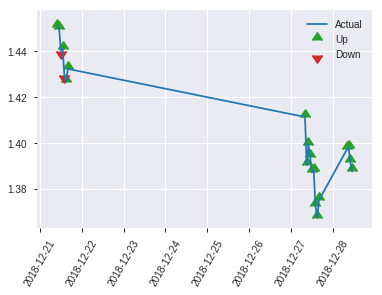


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.35764821183787066
RMSE: 0.5980369652771229
LogLoss: 1.604904085496851
Mean Per-Class Error: 0.4177487387312877
AUC: 0.567901745099661
pr_auc: 0.5464131890922591
Gini: 0.13580349019932192
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.008706698599806922: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      14   93   0.8692   (93.0/107.0)
1      4    109  0.0354   (4.0/113.0)
Total  18   202  0.4409   (97.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0087067    0.692063  200
max f2                       9.43029e-06  0.840774  218
max f0point5                 0.597073     0.593368  113
max accuracy                 0.651818     0.581818  105
max precision                0.987572     0.641026  37
max recall                   9.43029e-06  1         218
max specificity              1            0.990654  0
max absolute_mcc             0.0087067    0.174045  200
max min_per_class_accuracy   0.624185     0.570093  109
max mean_per_class_accuracy  0.651818     0.582251  105

Gains/Lift Table: Avg response rate: 51.36 %, avg score: 55.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.999996           0.648968  0.648968           0.333333         1           0.333333                    1                   0.00884956      0.00884956                 -35.1032  -35.1032
    2        0.0227273                   0.999967           0.973451  0.778761           0.5              0.999981    0.4                         0.999992            0.00884956      0.0176991                  -2.65487  -22.1239
    3        0.0318182                   0.999921           0.973451  0.834387           0.5              0.999944    0.428571                    0.999978            0.00884956      0.0265487                  -2.65487  -16.5613
    4        0.0409091                   0.999846           0         0.648968           0                0.999891    0.333333                    0.999959            0               0.0265487                  -100      -35.1032
    5        0.05                        0.9997             0.973451  0.707965           0.5              0.999773    0.363636                    0.999925            0.00884956      0.0353982                  -2.65487  -29.2035
    6        0.1                         0.997247           1.59292   1.15044            0.818182         0.998721    0.590909                    0.999323            0.079646        0.115044                   59.292    15.0442
    7        0.15                        0.993813           1.06195   1.12094            0.545455         0.995632    0.575758                    0.998093            0.0530973       0.168142                   6.19469   12.0944
    8        0.2                         0.98273            1.41593   1.19469            0.727273         0.989313    0.613636                    0.995898            0.0707965       0.238938                   41.5929   19.469
    9        0.3                         0.929131           0.973451  1.12094            0.5              0.963354    0.575758                    0.98505             0.0973451       0.336283                   -2.65487  12.0944
    10       0.4                         0.780238           1.06195   1.10619            0.545455         0.859076    0.568182                    0.953556            0.106195        0.442478                   6.19469   10.6195
    11       0.5                         0.627118           1.23894   1.13274            0.636364         0.704094    0.581818                    0.903664            0.123894        0.566372                   23.8938   13.2743
    12       0.6                         0.45857            0.79646   1.0767             0.409091         0.546735    0.55303                     0.844176            0.079646        0.646018                   -20.354   7.66962
    13       0.7                         0.185208           0.707965  1.02402            0.363636         0.28867     0.525974                    0.764818            0.0707965       0.716814                   -29.2035  2.40202
    14       0.8                         0.0621105          1.15044   1.03982            0.590909         0.117349    0.534091                    0.683884            0.115044        0.831858                   15.0442   3.9823
    15       0.9                         0.0200373          0.973451  1.03245            0.5              0.0392924   0.530303                    0.612263            0.0973451       0.929204                   -2.65487  3.24484
    16       1                           9.43029e-06        0.707965  1                  0.363636         0.00464639  0.5136

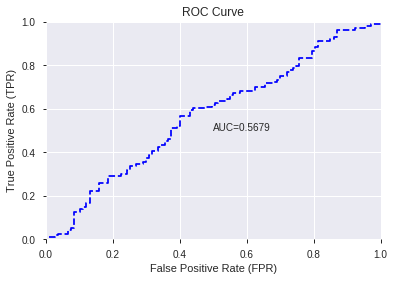

This function is available for GLM models only


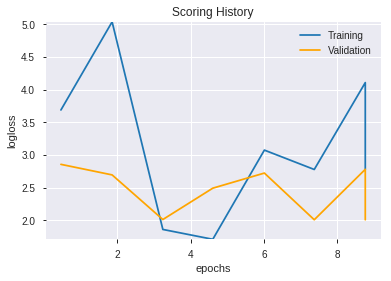

--2019-08-28 19:57:41--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.95.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.95.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


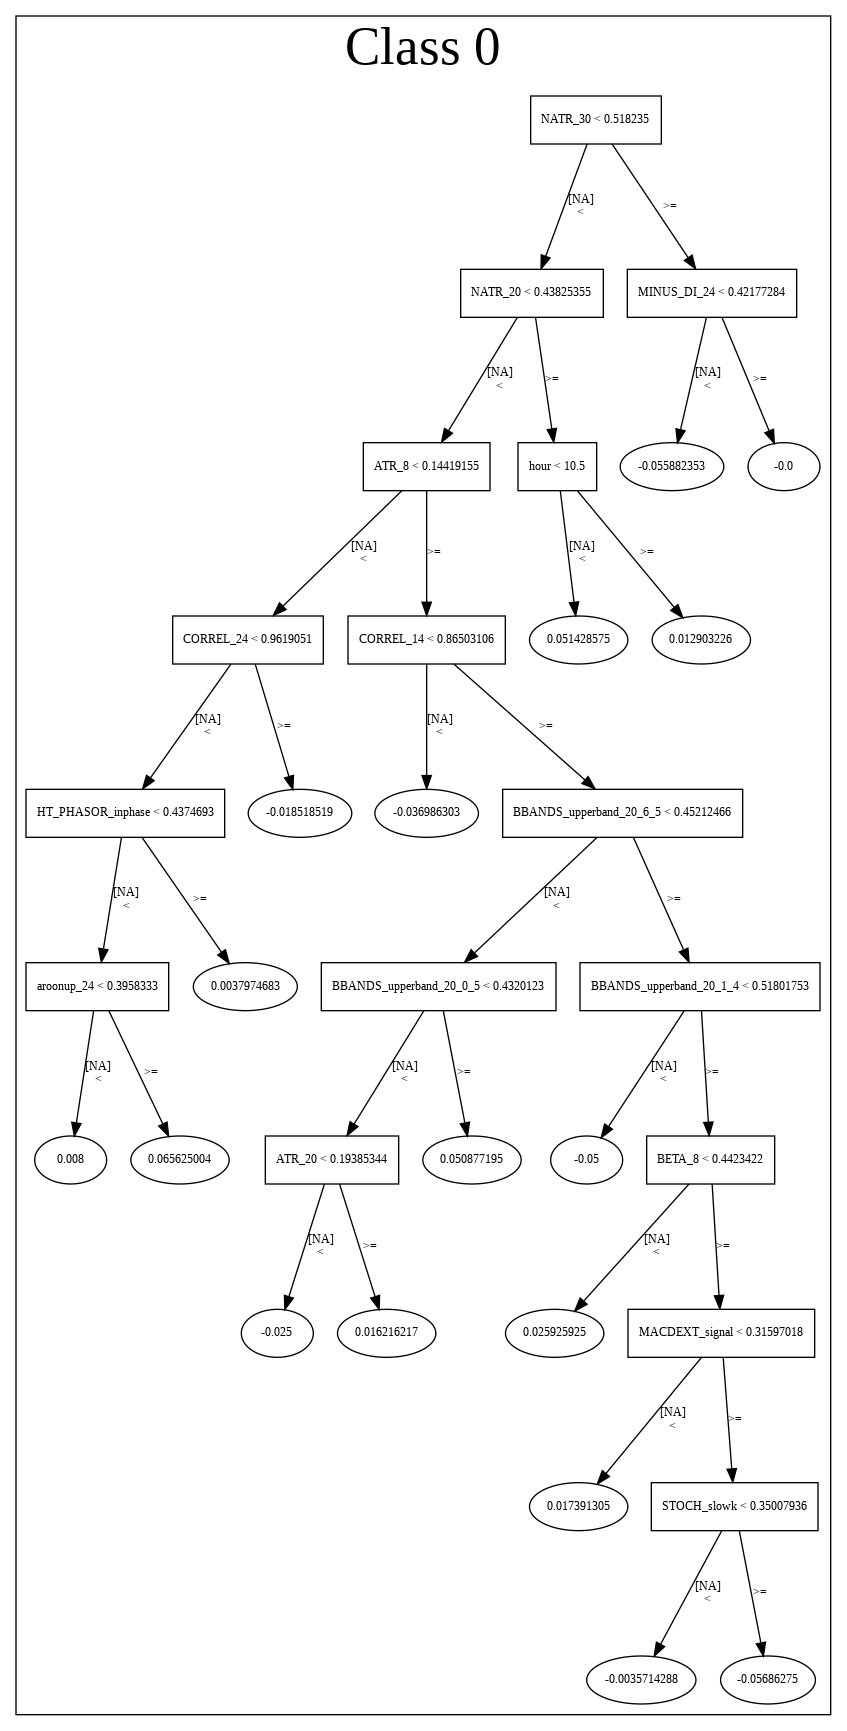

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_193242_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_193242_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_a8f4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLGAPSIDESIDEWHITE',
 'is_month_start',
 'CDLSHOOTINGSTAR',
 'CDLIDENTICAL3CROWS',
 'CDLMATCHINGLOW',
 'LINEARREG_30',
 'CDLINVERTEDHAMMER',
 'BBANDS_upperband_20_3_5',
 'CDLLONGLINE',
 'BBANDS_lowerband_30_5_3',
 'TRANGE',
 'CDLTAKURI',
 'BBANDS_lowerband_14_7_4',
 'CDLDRAGONFLYDOJI',
 'BBANDS_middleband_8_1_4',
 'CORREL_8',
 'CDLDOJISTAR',
 'OBV',
 'CDLEVENINGDOJISTAR',
 'DEMA_8',
 'BBANDS_upperband_24_3_4',
 'BBANDS_lowerband_24_6_2',
 'LINEARREG_20',
 'BBANDS_upperband_30_5_3',
 'ROC_20',
 'SAREXT',
 'BBANDS_lowerband_14_5_5',
 'CDLMORNINGDOJISTAR',
 'SINH',
 'CDLHAMMER',
 'BBANDS_upperband_24_3_2',
 'CDLDOJI',
 'CCI_8',
 'DEMA_24',
 'BETA_12',
 'CORREL_14',
 'BBANDS_lowerband_12_2_3',
 'CDLTHRUSTING',
 'MA_12_6',
 'CDLSTALLEDPATTERN',
 'BBANDS_lowerband_12_6_4',
 'BBANDS_upperband_8_2_3',
 'MACDFIX_14',
 'BOP',
 'BBANDS_middleband_8_6_3',
 'MAVP_14_2',
 'WILLR_8',
 'MIN_12',
 'BBANDS_lowerband_14_4_5',
 'BBANDS_lowerband_30_6_4',
 'CDLLADDERBOTTOM',
 'High',
 'CDLADVANCEBLOCK',

In [48]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_195749_model_1  0.515921  0.692497              0.490158  0.499674  0.249675

variable  relative_importance  scaled_importance    percentage
0            CDLINVERTEDHAMMER         9.460027e-03           1.000000  1.543682e-02
1                 CDLTHRUSTING         7.776398e-03           0.822027  1.268948e-02
2           CDLSEPARATINGLINES         7.699320e-03           0.813879  1.256371e-02
3               CDLMATCHINGLOW         7.615694e-03           0.805039  1.242725e-02
4                days_in_month         6.474896e-03           0.684448  1.056570e-02
...                        ...                  ...                ...           ...
1028  BBANDS_middleband_12_1_5         7.719582e-07           0.000082  1.259677e-06
1029                 MAVP_12_6         7.491810e-07           0.000079  1.222509e-06
1030   BBANDS_upperband_12_5_2         6.599189e-07           0.000070  1.076852e-06
1031                 MAVP_30_7         3.680718e-07           0.000039  6.006174e-07
1032   BBANDS_lowerband_20_7_5         2.452785e-07           0.000026  4.002441e-07

[1033 rows x 4 columns]

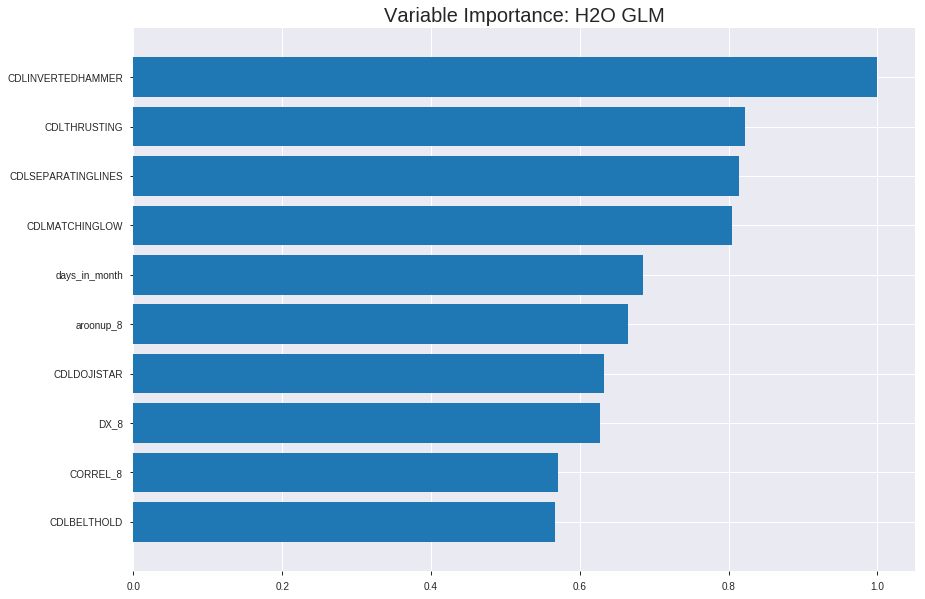

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_195749_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24676963059921955
RMSE: 0.49675912734364486
LogLoss: 0.6866722880914399
Null degrees of freedom: 1536
Residual degrees of freedom: 503
Null deviance: 2130.499553929498
Residual deviance: 2110.830613593086
AIC: 4178.830613593086
AUC: 0.5930606500909396
pr_auc: 0.5989310249855666
Gini: 0.1861213001818791
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4658860618942555: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      47   712   0.9381   (712.0/759.0)
1      13   765   0.0167   (13.0/778.0)
Total  60   1477  0.4717   (725.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.465886     0.678492  358
max f2                       0.451903     0.837657  381
max f0point5                 0.495677     0.589524  248
max accuracy                 0.495677     0.571893  248
max precision                0.568714     1         0
max recall                   0.440778     1         394
max specificity              0.568714     1         0
max absolute_mcc             0.495677     0.155148  248
max min_per_class_accuracy   0.508941     0.560411  179
max mean_per_class_accuracy  0.495677     0.569093  248

Gains/Lift Table: Avg response rate: 50.62 %, avg score: 50.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.549663           1.72863   1.72863            0.875            0.554053  0.875                       0.554053            0.0179949       0.0179949                  72.8631   72.8631
    2        0.0201692                   0.54415            1.58046   1.65694            0.8              0.546364  0.83871                     0.550332            0.0154242       0.033419                   58.0463   65.6937
    3        0.0305791                   0.540455           1.35821   1.55524            0.6875           0.542305  0.787234                    0.5476              0.0141388       0.0475578                  35.821    55.5243
    4        0.0403383                   0.539404           1.18535   1.46575            0.6              0.53987   0.741935                    0.54573             0.0115681       0.059126                   18.5347   46.5752
    5        0.0500976                   0.537805           1.18535   1.41113            0.6              0.538754  0.714286                    0.544371            0.0115681       0.0706941                  18.5347   41.1127
    6        0.100195                    0.531499           1.28284   1.34699            0.649351         0.533892  0.681818                    0.539131            0.0642674       0.134961                   28.2843   34.6985
    7        0.150293                    0.52626            1.10325   1.26574            0.558442         0.528548  0.640693                    0.535603            0.0552699       0.190231                   10.3245   26.5739
    8        0.20039                     0.522613           1.02627   1.20587            0.519481         0.52435   0.61039                     0.53279             0.0514139       0.241645                   2.62745   20.5873
    9        0.299935                    0.51783            1.1621    1.19135            0.588235         0.519999  0.603037                    0.528545            0.115681        0.357326                   16.2105   19.1347
    10       0.40013                     0.513733           1.05193   1.15644            0.532468         0.515868  0.585366                    0.525371            0.105398        0.462725                   5.19314   15.6436
    11       0.500325                    0.508844           0.987789  1.12266            0.5              0.511136  0.56827                     0.52252             0.0989717       0.561697                   -1.22108  12.2663
    12       0.59987                     0.503551           0.929684  1.09064            0.470588         0.506193  0.552061                    0.519811            0.092545        0.654242                   -7.0316   9.06393
    13       0.700065                    0.497602           1.0391    1.08326            0.525974         0.500705  0.548327                    0.517076            0.104113        0.758355                   3.91029   8.32633
    14       0.79961                     0.488712           0.865123  1.05611            0.437908         0.493455  0.534581                    0.514136            0.0861183       0.844473                   -13.4877  5.61066
    15       0.899805                    0.477066           0.795363  1.02707            0.402597         0.483633  0.519884                    0.510739            0.0796915       0.924165                   -20.4637  2.70722
    16       1                           0.417672           0.756877  1                  0.383117         0.465246  0.506181                    0.506181         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2511499973594055
RMSE: 0.501148677898491
LogLoss: 0.6954685345357587
Null degrees of freedom: 438
Residual degrees of freedom: -595
Null deviance: 608.2794432341497
Residual deviance: 610.6213733223962
AIC: 2678.6213733223963
AUC: 0.5011221012384673
pr_auc: 0.5178801935283589
Gini: 0.002244202476934687
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40542672940822627: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    212  1        (212.0/212.0)
1      0    227  0        (0.0/227.0)
Total  0    439  0.4829   (212.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.405427     0.681682  399
max f2                       0.405427     0.842613  399
max f0point5                 0.405427     0.572365  399
max accuracy                 0.481719     0.528474  296
max precision                0.548077     1         0
max recall                   0.405427     1         399
max specificity              0.548077     1         0
max absolute_mcc             0.528754     0.066753  38
max min_per_class_accuracy   0.497973     0.518868  197
max mean_per_class_accuracy  0.498359     0.524219  194

Gains/Lift Table: Avg response rate: 51.71 %, avg score: 49.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.542617           1.54714   1.54714            0.8              0.545126  0.8                         0.545126            0.0176211       0.0176211                  54.7137   54.7137
    2        0.0205011                   0.539618           0.96696   1.28928            0.5              0.541059  0.666667                    0.543318            0.00881057      0.0264317                  -3.30396  28.928
    3        0.0318907                   0.538347           1.16035   1.24323            0.6              0.53913   0.642857                    0.541823            0.0132159       0.0396476                  16.0352   24.3235
    4        0.0410023                   0.5366             0.48348   1.0744             0.25             0.537702  0.555556                    0.540907            0.00440529      0.0440529                  -51.652   7.44004
    5        0.0501139                   0.534586           0.48348   0.96696            0.25             0.535496  0.5                         0.539923            0.00440529      0.0484581                  -51.652   -3.30396
    6        0.100228                    0.526599           0.791149  0.879055           0.409091         0.530233  0.454545                    0.535078            0.0396476       0.0881057                  -20.8851  -12.0945
    7        0.150342                    0.517695           0.96696   0.908357           0.5              0.52223   0.469697                    0.530795            0.0484581       0.136564                   -3.30396  -9.16433
    8        0.200456                    0.515108           1.14277   0.96696            0.590909         0.516389  0.5                         0.527194            0.0572687       0.193833                   14.2771   -3.30396
    9        0.300683                    0.507688           1.05487   0.996262           0.545455         0.51085   0.515152                    0.521746            0.105727        0.299559                   5.48658   -0.373782
    10       0.400911                    0.503081           1.09882   1.0219             0.568182         0.505297  0.528409                    0.517634            0.110132        0.409692                   9.88186   2.19013
    11       0.501139                    0.497973           1.09882   1.03728            0.568182         0.500319  0.536364                    0.514171            0.110132        0.519824                   9.88186   3.72847
    12       0.599089                    0.492008           0.899498  1.01476            0.465116         0.49489   0.524715                    0.511018            0.0881057       0.60793                    -10.0502  1.47569
    13       0.699317                    0.485507           0.923008  1.00161            0.477273         0.489307  0.517915                    0.507907            0.092511        0.700441                   -7.69924  0.160714
    14       0.799544                    0.478578           1.14277   1.0193             0.590909         0.482101  0.527066                    0.504672            0.114537        0.814978                   14.2771   1.93029
    15       0.899772                    0.468488           0.791149  0.993888           0.409091         0.474564  0.513924                    0.501318            0.0792952       0.894273                   -20.8851  -0.611164
    16       1                           0.405427           1.05487   1                  0.545455         0.438701  0.517084                    0.495042 


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 19:57:52  0.000 sec   2            3.4       1034          1.37334           1.39094
    2019-08-28 19:57:54  1.971 sec   4            2.5       1034          1.37014           1.3935
    2019-08-28 19:57:56  3.954 sec   6            1.8       1034          1.36635           1.39665
    2019-08-28 19:57:58  5.981 sec   8            1.3       1034          1.36194           1.40065
    2019-08-28 19:58:00  7.934 sec   10           0.95      1034          1.35685           1.40589

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5545454545454546)

('F1', 0.6788990825688073)

('auc', 0.5159209329253163)

('logloss', 0.6924969641485332)

('mean_per_class_error', 0.4385906872880655)

('rmse', 0.49967446894678974)

('mse', 0.24967457491725634)

glm prediction progress: |████████████████████████████████████████████████| 100%


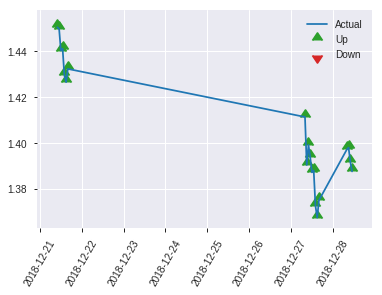


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24967457491725634
RMSE: 0.49967446894678974
LogLoss: 0.6924969641485332
Null degrees of freedom: 219
Residual degrees of freedom: -814
Null deviance: 304.8700323300008
Residual deviance: 304.69866422535455
AIC: 2372.6986642253546
AUC: 0.5159209329253163
pr_auc: 0.551748315881439
Gini: 0.031841865850632534
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46750109500045484: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    103  0.9626   (103.0/107.0)
1      2    111  0.0177   (2.0/113.0)
Total  6    214  0.4773   (105.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.467501     0.678899  213
max f2                       0.447903     0.840774  219
max f0point5                 0.467501     0.572755  213
max accuracy                 0.505829     0.554545  54
max precision                0.528363     1         0
max recall                   0.447903     1         219
max specificity              0.528363     1         0
max absolute_mcc             0.519043     0.166722  12
max min_per_class_accuracy   0.495968     0.495575  108
max mean_per_class_accuracy  0.505829     0.561409  54

Gains/Lift Table: Avg response rate: 51.36 %, avg score: 49.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.526316           1.29794   1.29794            0.666667         0.527435  0.666667                    0.527435            0.0176991       0.0176991                  29.7935   29.7935
    2        0.0227273                   0.523675           0.973451  1.16814            0.5              0.524432  0.6                         0.526234            0.00884956      0.0265487                  -2.65487  16.8142
    3        0.0318182                   0.522474           1.9469    1.39064            1                0.523079  0.714286                    0.525333            0.0176991       0.0442478                  94.6903   39.0645
    4        0.0409091                   0.520455           1.9469    1.51426            1                0.521625  0.777778                    0.524509            0.0176991       0.0619469                  94.6903   51.4258
    5        0.05                        0.519655           1.9469    1.59292            1                0.520232  0.818182                    0.523731            0.0176991       0.079646                   94.6903   59.292
    6        0.1                         0.515187           0.530973  1.06195            0.272727         0.517047  0.545455                    0.520389            0.0265487       0.106195                   -46.9027  6.19469
    7        0.15                        0.512964           1.59292   1.23894            0.818182         0.513987  0.636364                    0.518255            0.079646        0.185841                   59.292    23.8938
    8        0.2                         0.50912            1.23894   1.23894            0.636364         0.511083  0.636364                    0.516462            0.0619469       0.247788                   23.8938   23.8938
    9        0.3                         0.503418           0.973451  1.15044            0.5              0.506004  0.590909                    0.512976            0.0973451       0.345133                   -2.65487  15.0442
    10       0.4                         0.498323           0.619469  1.0177             0.318182         0.501113  0.522727                    0.51001             0.0619469       0.40708                    -38.0531  1.76991
    11       0.5                         0.495866           0.884956  0.99115            0.454545         0.497148  0.509091                    0.507438            0.0884956       0.495575                   -11.5044  -0.884956
    12       0.6                         0.492095           0.79646   0.958702           0.409091         0.493978  0.492424                    0.505195            0.079646        0.575221                   -20.354   -4.12979
    13       0.7                         0.489875           1.06195   0.973451           0.545455         0.490957  0.5                         0.503161            0.106195        0.681416                   6.19469   -2.65487
    14       0.8                         0.484665           1.15044   0.995575           0.590909         0.487511  0.511364                    0.501204            0.115044        0.79646                    15.0442   -0.442478
    15       0.9                         0.475175           1.06195   1.00295            0.545455         0.47977   0.515152                    0.498823            0.106195        0.902655                   6.19469   0.294985
    16       1                           0.447903           0.973451  1                  0.5              0.468556  0.513636                    0.495796   

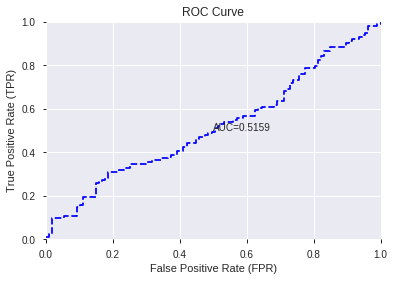

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


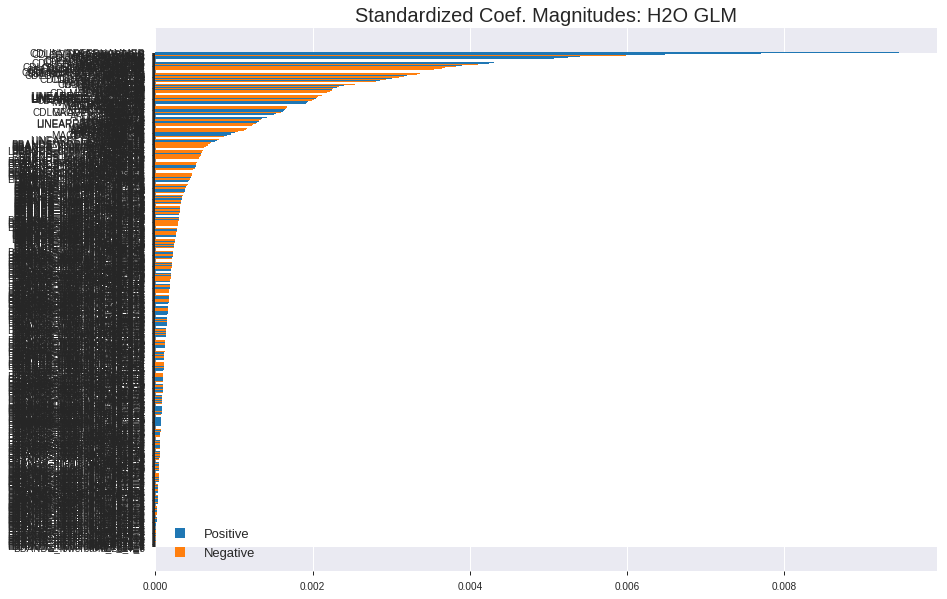

'log_likelihood'
--2019-08-28 19:58:26--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.64.176
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.64.176|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


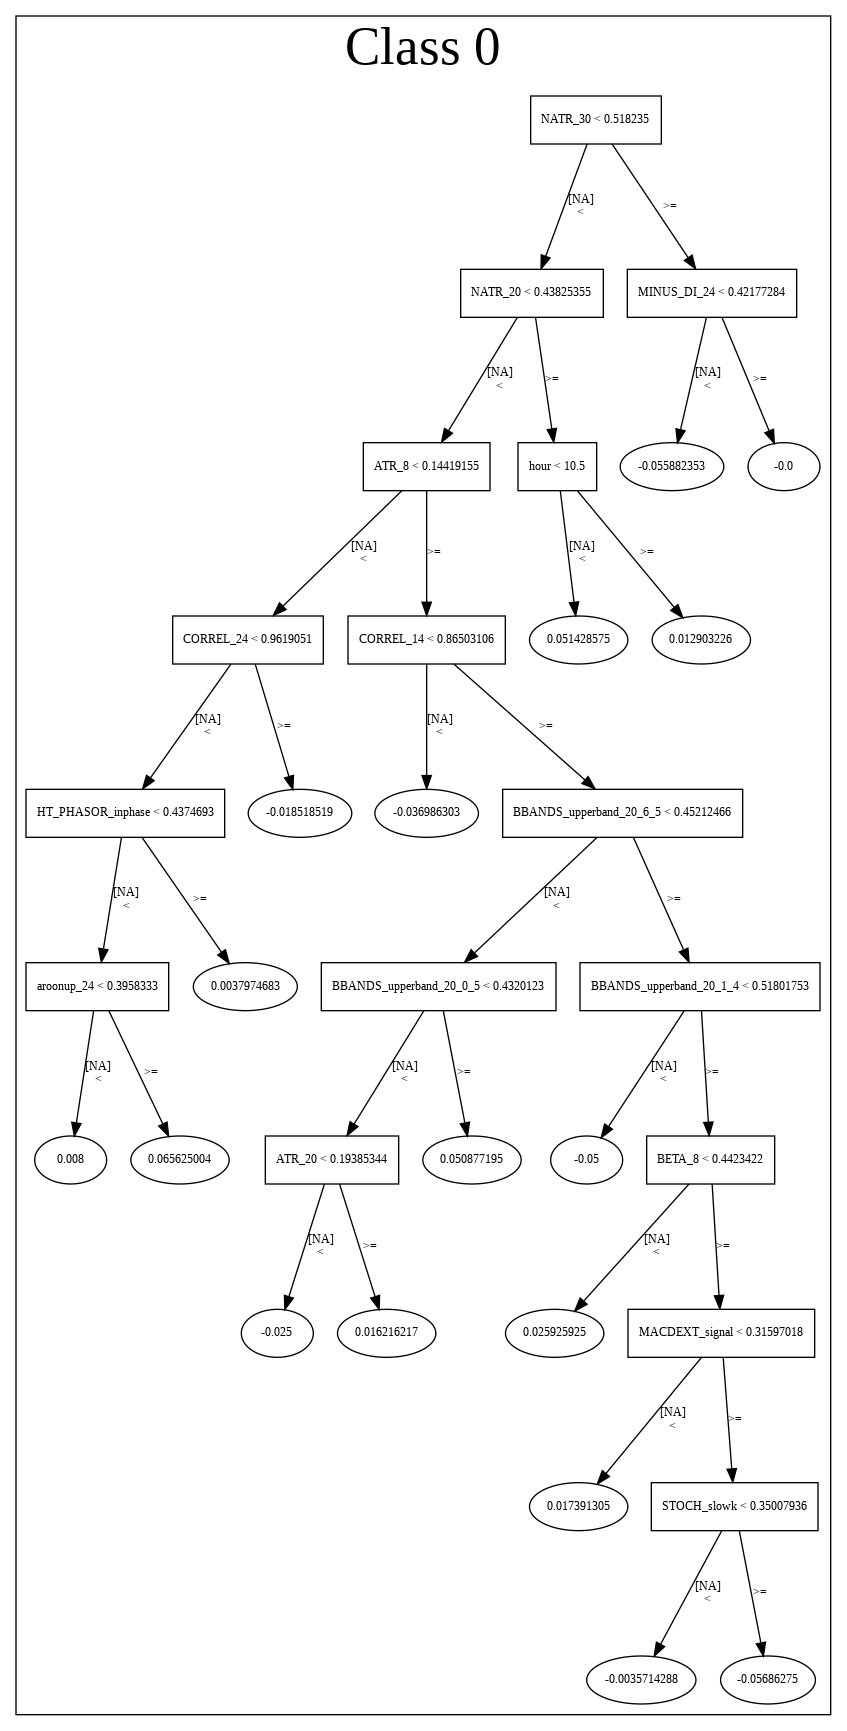

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_195749_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_195749_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_a8f4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['CDLINVERTEDHAMMER',
 'CDLTHRUSTING',
 'CDLSEPARATINGLINES',
 'CDLMATCHINGLOW',
 'days_in_month',
 'aroonup_8',
 'CDLDOJISTAR',
 'DX_8',
 'CORREL_8',
 'CDLBELTHOLD',
 'CDLRICKSHAWMAN',
 'day',
 'CDLENGULFING',
 'is_month_start',
 'OBV',
 'CDLSHOOTINGSTAR',
 'DX_12',
 'aroondown_14',
 'DX_14',
 'CDLADVANCEBLOCK',
 'CDLLONGLEGGEDDOJI',
 'aroondown_20',
 'CDLDOJI',
 'CDLHANGINGMAN',
 'CDL3OUTSIDE',
 'MINUS_DM_30',
 'SIN',
 'MFI_8',
 'MINUS_DM_24',
 'CDLCLOSINGMARUBOZU',
 'HT_TRENDMODE',
 'CDLLADDERBOTTOM',
 'CDLTAKURI',
 'ATR_20',
 'ATR_24',
 'MINUS_DM_20',
 'CDLDARKCLOUDCOVER',
 'CDLIDENTICAL3CROWS',
 'ATR_14',
 'CDLRISEFALL3METHODS',
 'ATR_30',
 'CDLMORNINGDOJISTAR',
 'HT_PHASOR_quadrature',
 'NATR_20',
 'ATR_12',
 'CDLGAPSIDESIDEWHITE',
 'NATR_24',
 'NATR_14',
 'AROONOSC_8',
 'is_month_end',
 'BETA_24',
 'NATR_30',
 'NATR_12',
 'BETA_14',
 'CDLDRAGONFLYDOJI',
 'CDLHARAMICROSS',
 'MACDFIX_hist_24',
 'MINUS_DI_30',
 'SAREXT',
 'DX_20',
 'MFI_24',
 'MINUS_DM_14',
 'ATR_8',
 'MACDFIX_hist

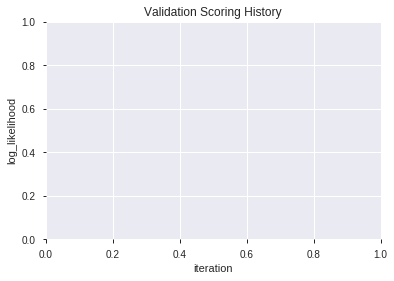

In [49]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_2_AutoML_20190828_195833  0.531966  0.701875              0.500000  0.504152  0.254169
1  XGBoost_grid_1_AutoML_20190828_195833_model_5  0.510628  0.743598              0.500000  0.520565  0.270988
2  XGBoost_grid_1_AutoML_20190828_195833_model_7  0.491192  0.724882              0.500000  0.514612  0.264825
3  XGBoost_grid_1_AutoML_20190828_195833_model_3  0.486229  0.718545              0.500000  0.511975  0.262119
4               XGBoost_3_AutoML_20190828_195833  0.485485  0.713658              0.500000  0.509824  0.259920
5  XGBoost_grid_1_AutoML_20190828_195833_model_6  0.475891  0.710697              0.500000  0.508415  0.258486
6  XGBoost_grid_1_AutoML_20190828_195833_model_1  0.472500  0.709401              0.490406  0.507757  0.257817
7  XGBoost_grid_1_AutoML_20190828_195833_model_4  0.468861  0.708594              0.500000  0.507490  0.257546
8  XGBoost_grid_1_AutoML_20190828_195833_model_2  0.460425  0.718335              0.500000  0.511990  0.262134
9               XGBoost_1_AutoML_20190828_195833  0.443222  0.741456              0.500000  0.522051  0.272537

variable  relative_importance  scaled_importance  percentage
0                   CORREL_8            93.094200           1.000000    0.016913
1                      ATR_8            91.157082           0.979192    0.016561
2                        DIV            89.664360           0.963157    0.016290
3                        BOP            87.417191           0.939019    0.015882
4                    NATR_30            83.790710           0.900064    0.015223
..                       ...                  ...                ...         ...
267        MACDFIX_signal_12             3.136653           0.033693    0.000570
268  BBANDS_upperband_14_7_5             2.970720           0.031911    0.000540
269  BBANDS_lowerband_20_1_4             2.838207           0.030487    0.000516
270  BBANDS_upperband_30_1_5             2.317775           0.024897    0.000421
271                   VAR_24             2.187851           0.023501    0.000397

[272 rows x 4 columns]

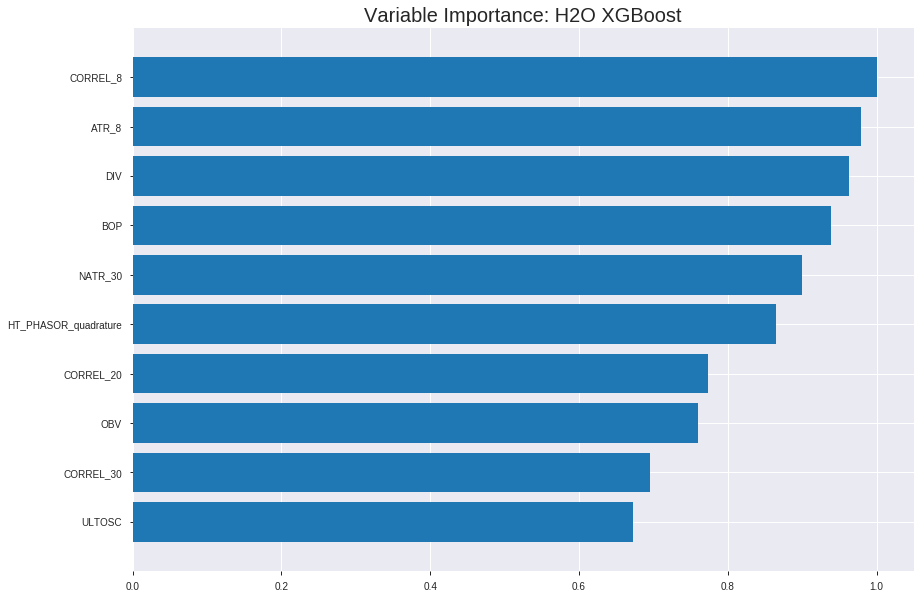

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20190828_195833


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17335818106681178
RMSE: 0.41636303998651436
LogLoss: 0.5346559126060626
Mean Per-Class Error: 0.14082763479209215
AUC: 0.9362931878300158
pr_auc: 0.9361014754966879
Gini: 0.8725863756600316
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4930047392845154: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      613  146  0.1924   (146.0/759.0)
1      82   696  0.1054   (82.0/778.0)
Total  695  842  0.1483   (228.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.493005     0.859259  209
max f2                       0.443895     0.907443  252
max f0point5                 0.550012     0.884805  160
max accuracy                 0.520447     0.858816  185
max precision                0.775469     1         0
max recall                   0.345613     1         338
max specificity              0.775469     1         0
max absolute_mcc             0.520447     0.719147  185
max min_per_class_accuracy   0.510595     0.856041  194
max mean_per_class_accuracy  0.520447     0.859172  185

Gains/Lift Table: Avg response rate: 50.62 %, avg score: 50.83 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.74215            1.97558    1.97558            1                0.753388  1                           0.753388            0.0205656       0.0205656                  97.5578   97.5578
    2        0.0201692                   0.727608           1.97558    1.97558            1                0.734784  1                           0.744386            0.0192802       0.0398458                  97.5578   97.5578
    3        0.0305791                   0.718657           1.97558    1.97558            1                0.722751  1                           0.737021            0.0205656       0.0604113                  97.5578   97.5578
    4        0.0403383                   0.711981           1.97558    1.97558            1                0.715732  1                           0.73187             0.0192802       0.0796915                  97.5578   97.5578
    5        0.0500976                   0.703446           1.97558    1.97558            1                0.708186  1                           0.727256            0.0192802       0.0989717                  97.5578   97.5578
    6        0.100195                    0.674545           1.92426    1.94992            0.974026         0.687909  0.987013                    0.707583            0.096401        0.195373                   92.4265   94.9922
    7        0.150293                    0.6487             1.97558    1.95847            1                0.660705  0.991342                    0.691957            0.0989717       0.294344                   97.5578   95.8474
    8        0.20039                     0.627459           1.89861    1.94351            0.961039         0.636694  0.983766                    0.678141            0.0951157       0.38946                    89.8608   94.3507
    9        0.299935                    0.59152            1.84646    1.9113             0.934641         0.60826   0.967462                    0.654949            0.183805        0.573265                   84.6456   91.1297
    10       0.40013                     0.549513           1.62921    1.84066            0.824675         0.569424  0.931707                    0.633533            0.163239        0.736504                   62.9211   84.0661
    11       0.500325                    0.510863           1.15456    1.70326            0.584416         0.529324  0.862159                    0.612664            0.115681        0.852185                   15.4559   70.3262
    12       0.59987                     0.471656           0.787649   1.55132            0.398693         0.491724  0.785249                    0.592595            0.0784062       0.930591                   -21.2351  55.1322
    13       0.700065                    0.432593           0.423338   1.38988            0.214286         0.450269  0.703532                    0.572225            0.0424165       0.973008                   -57.6662  38.9882
    14       0.79961                     0.389936           0.193684   1.24097            0.0980392        0.411007  0.628153                    0.552154            0.0192802       0.992288                   -80.6316  24.0965
    15       0.899805                    0.340307           0.0769706  1.11135            0.038961         0.364773  0.562545                    0.531289            0.00771208      1                          -92.3029  11.1352
    16       1                           0.197444           0          1                  0                0.302005  0.506181                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2620806225183293
RMSE: 0.5119381041867554
LogLoss: 0.7178646711129717
Mean Per-Class Error: 0.4958856287922866
AUC: 0.45161457900423907
pr_auc: 0.4803908360717882
Gini: -0.09677084199152186
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3133352994918823: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    212  1        (212.0/212.0)
1      0    227  0        (0.0/227.0)
Total  0    439  0.4829   (212.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.313335     0.681682  399
max f2                       0.313335     0.842613  399
max f0point5                 0.313335     0.572365  399
max accuracy                 0.313335     0.517084  399
max precision                0.59903      0.542857  32
max recall                   0.313335     1         399
max specificity              0.671001     0.995283  0
max absolute_mcc             0.626231     0.117556  10
max min_per_class_accuracy   0.484514     0.462555  201
max mean_per_class_accuracy  0.59903      0.504114  32

Gains/Lift Table: Avg response rate: 51.71 %, avg score: 48.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.645898           0.773568  0.773568           0.4              0.660316  0.4                         0.660316            0.00881057      0.00881057                 -22.6432  -22.6432
    2        0.0205011                   0.630428           0         0.42976            0                0.637114  0.222222                    0.650004            0               0.00881057                 -100      -57.024
    3        0.0318907                   0.623274           0.386784  0.414412           0.2              0.62668   0.214286                    0.641674            0.00440529      0.0132159                  -61.3216  -58.5588
    4        0.0410023                   0.619236           1.93392   0.75208            1                0.620671  0.388889                    0.637007            0.0176211       0.030837                   93.3921   -24.792
    5        0.0501139                   0.6119             1.93392   0.96696            1                0.61629   0.5                         0.63324             0.0176211       0.0484581                  93.3921   -3.30396
    6        0.100228                    0.592098           0.879055  0.923008           0.454545         0.600638  0.477273                    0.616939            0.0440529       0.092511                   -12.0945  -7.69924
    7        0.150342                    0.573846           0.879055  0.908357           0.454545         0.583672  0.469697                    0.60585             0.0440529       0.136564                   -12.0945  -9.16433
    8        0.200456                    0.558622           0.703244  0.857078           0.363636         0.564615  0.443182                    0.595541            0.0352423       0.171806                   -29.6756  -14.2922
    9        0.300683                    0.530461           1.01091   0.908357           0.522727         0.542348  0.469697                    0.57781             0.101322        0.273128                   1.09131   -9.16433
    10       0.400911                    0.507703           0.835102  0.890043           0.431818         0.519242  0.460227                    0.563168            0.0837004       0.356828                   -16.4898  -10.9957
    11       0.501139                    0.482493           1.09882   0.931798           0.568182         0.494425  0.481818                    0.54942             0.110132        0.46696                    9.88186   -6.82018
    12       0.599089                    0.466959           1.03442   0.948577           0.534884         0.474638  0.490494                    0.537193            0.101322        0.568282                   3.44227   -5.14229
    13       0.699317                    0.448261           1.14277   0.976409           0.590909         0.457363  0.504886                    0.525752            0.114537        0.682819                   14.2771   -2.35905
    14       0.799544                    0.424286           0.96696   0.975225           0.5              0.434104  0.504274                    0.514263            0.0969163       0.779736                   -3.30396  -2.4775
    15       0.899772                    0.399417           1.09882   0.988992           0.568182         0.412895  0.511392                    0.502971            0.110132        0.889868                   9.88186   -1.10076
    16       1                           0.313335           1.09882   1                  0.568182         0.372452  0.517084                    0.489


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 19:58:39  0.005 sec   0                  0.5              0.693147            0.5             0                  1                0.493819                         0.5                0.693147              0.5               0                    1                  0.482916
    2019-08-28 19:58:39  0.749 sec   5                  0.488885         0.671118            0.759067        0.750117           1.72863          0.329213                         0.503871           0.700936              0.419666          0.4558               0.386784           0.482916
    2019-08-28 19:58:40  1.377 sec   10                 0.479247         0.652295            0.808776        0.810087           1.8521           0.276513                         0.506238           0.705757              0.411749          0.446217             0.386784           0.482916
    2019-08-28 19:58:41  1.914 sec   15                 0.469395         0.633251            0.835553        0.841075           1.97558          0.248536                         0.507665           0.708737              0.427053          0.461254             0                  0.482916
    2019-08-28 19:58:41  2.516 sec   20                 0.461123         0.617441            0.856664        0.860736           1.8521           0.229018                         0.508388           0.710252              0.43549           0.469022             0.773568           0.482916
    2019-08-28 19:58:42  3.118 sec   25                 0.453529         0.603022            0.872949        0.875799           1.8521           0.221861                         0.508873           0.71127               0.437142          0.471275             0.773568           0.480638
    2019-08-28 19:58:42  3.767 sec   30                 0.446198         0.589274            0.88791         0.891897           1.97558          0.206246                         0.510113           0.713885              0.43469           0.473735             1.16035            0.482916
    2019-08-28 19:58:43  4.381 sec   35                 0.437922         0.573922            0.904851        0.90902            1.97558          0.184125                         0.509686           0.713045              0.447427          0.47634              0.773568           0.482916
    2019-08-28 19:58:44  4.944 sec   40                 0.430058         0.559531            0.919881        0.921966           1.97558          0.169161                         0.511158           0.716128              0.441547          0.472688             0.773568           0.482916
    2019-08-28 19:58:44  5.510 sec   45                 0.423041         0.546751            0.930414        0.932203           1.97558          0.152245                         0.511912           0.717738              0.439531          0.473004             0                  0.482916
    2019-08-28 19:58:45  6.059 sec   50                 0.416363         0.534656            0.936293        0.936101           1.97558          0.148341                         0.511938           0.717865              0.451615          0.480391             0.773568           0.482916

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
CORREL_8                 93.09420013427734      1.0                   0.016913106612839388
ATR_8                    91.1570816040039       0.9791918451688787    0.016561176071764164
DIV                      89.66436004638672      0.9631573171804099    0.016289982390408634
BOP                      87.41719055175781      0.9390186544990867    0.015881722614988047
NATR_30                  83.79071044921875      0.9000637024472049    0.015222873357836524
---                      ---                    ---                   ---
MACDFIX_signal_12        3.136653423309326      0.03369332803531343   0.0005698588492026263
BBANDS_upperband_14_7_5  2.9707202911376953     0.03191090623103033   0.0005397125591977366
BBANDS_lowerband_20_1_4  2.838207244873047      0.030487476564375327  0.0005156379414897221
BBANDS_upperband_30_1_5  2.317774772644043      0.02489709100353113   0.00042108715449228637
VAR_24                   2.1878509521484375     0.023501474302295117  0.0003974829404336224


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5590909090909091)

('F1', 0.6786786786786787)

('auc', 0.5319659250682326)

('logloss', 0.7018754821880735)

('mean_per_class_error', 0.4383839219253991)

('rmse', 0.5041519875268574)

('mse', 0.2541692265272806)

xgboost prediction progress: |████████████████████████████████████████████| 100%


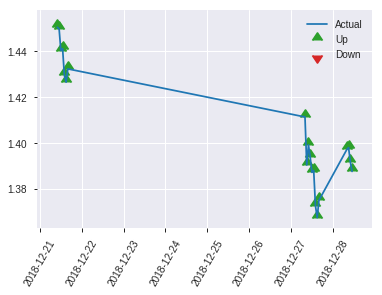


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2541692265272806
RMSE: 0.5041519875268574
LogLoss: 0.7018754821880735
Mean Per-Class Error: 0.4383839219253991
AUC: 0.5319659250682326
pr_auc: 0.5468902579433191
Gini: 0.06393185013646518
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2801385223865509: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    107  1        (107.0/107.0)
1      0    113  0        (0.0/113.0)
Total  0    220  0.4864   (107.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.280139     0.678679  219
max f2                       0.280139     0.840774  219
max f0point5                 0.370997     0.582307  194
max accuracy                 0.480033     0.559091  89
max precision                0.703265     1         0
max recall                   0.280139     1         219
max specificity              0.703265     1         0
max absolute_mcc             0.610754     0.148395  4
max min_per_class_accuracy   0.461675     0.530973  109
max mean_per_class_accuracy  0.480033     0.561616  89

Gains/Lift Table: Avg response rate: 51.36 %, avg score: 46.11 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.633847           1.9469    1.9469             1                0.671682  1                           0.671682            0.0265487       0.0265487                  94.6903   94.6903
    2        0.0227273                   0.608162           1.9469    1.9469             1                0.614912  1                           0.648974            0.0176991       0.0442478                  94.6903   94.6903
    3        0.0318182                   0.593466           0         1.39064            0                0.600829  0.714286                    0.635218            0               0.0442478                  -100      39.0645
    4        0.0409091                   0.589821           0.973451  1.29794            0.5              0.590127  0.666667                    0.625198            0.00884956      0.0530973                  -2.65487  29.7935
    5        0.05                        0.581873           0.973451  1.23894            0.5              0.586251  0.636364                    0.618117            0.00884956      0.0619469                  -2.65487  23.8938
    6        0.1                         0.55767            1.06195   1.15044            0.545455         0.569126  0.590909                    0.593621            0.0530973       0.115044                   6.19469   15.0442
    7        0.15                        0.535905           0.530973  0.943953           0.272727         0.549722  0.484848                    0.578988            0.0265487       0.141593                   -46.9027  -5.60472
    8        0.2                         0.521211           1.06195   0.973451           0.545455         0.529328  0.5                         0.566573            0.0530973       0.19469                    6.19469   -2.65487
    9        0.3                         0.496281           1.23894   1.06195            0.636364         0.510831  0.545455                    0.547993            0.123894        0.318584                   23.8938   6.19469
    10       0.4                         0.480173           1.32743   1.12832            0.681818         0.487596  0.579545                    0.532893            0.132743        0.451327                   32.7434   12.8319
    11       0.5                         0.461649           0.79646   1.06195            0.409091         0.470743  0.545455                    0.520463            0.079646        0.530973                   -20.354   6.19469
    12       0.6                         0.439684           0.619469  0.988201           0.318182         0.451892  0.507576                    0.509035            0.0619469       0.59292                    -38.0531  -1.17994
    13       0.7                         0.413449           1.32743   1.03666            0.681818         0.427504  0.532468                    0.497387            0.132743        0.725664                   32.7434   3.66625
    14       0.8                         0.392379           0.973451  1.02876            0.5              0.404364  0.528409                    0.48576             0.0973451       0.823009                   -2.65487  2.87611
    15       0.9                         0.368967           0.973451  1.02262            0.5              0.38077   0.525253                    0.474094            0.0973451       0.920354                   -2.65487  2.26155
    16       1                           0.280139           0.79646   1                  0.409091         0.343853  0.513636                    0.46107       

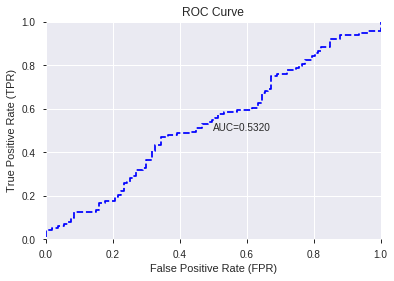

This function is available for GLM models only


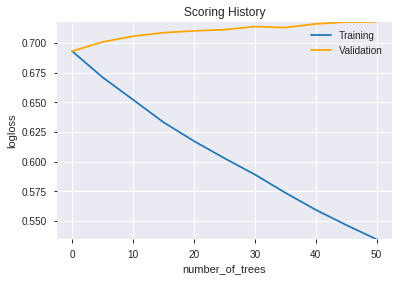

--2019-08-28 19:59:26--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.112.19
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.112.19|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip


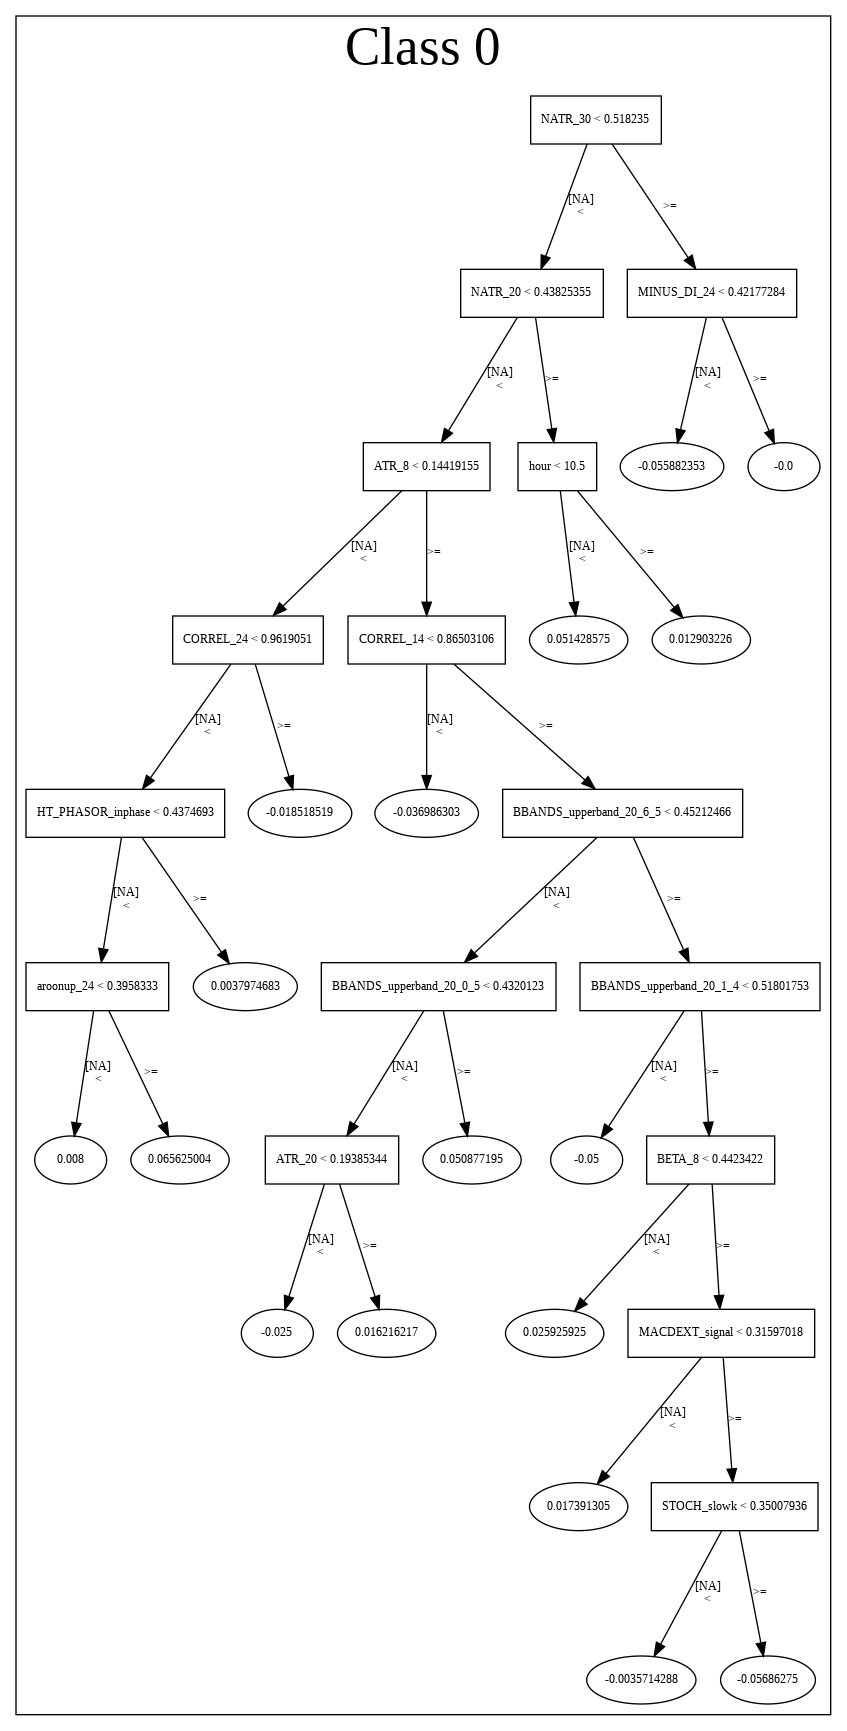

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_2_AutoML_20190828_195833',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_2_AutoML_20190828_195833',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_a8f4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_90_sid_a8f4',
   'type

['CORREL_8',
 'ATR_8',
 'DIV',
 'BOP',
 'NATR_30',
 'HT_PHASOR_quadrature',
 'CORREL_20',
 'OBV',
 'CORREL_30',
 'ULTOSC',
 'MOM_30',
 'MFI_8',
 'MFI_14',
 'MFI_24',
 'CORREL_24',
 'ADOSC',
 'aroonup_8',
 'MFI_30',
 'DX_12',
 'PLUS_DM_8',
 'BETA_20',
 'Volume',
 'DX_20',
 'LINEARREG_ANGLE_20',
 'STDDEV_8',
 'ROC_30',
 'WILLR_8',
 'STOCH_slowk',
 'STDDEV_24',
 'STDDEV_20',
 'NATR_12',
 'VAR_8',
 'HT_PHASOR_inphase',
 'MACDFIX_signal_14',
 'PLUS_DM_30',
 'MACDFIX_signal_24',
 'MINUS_DM_20',
 'MACD_hist',
 'day',
 'ADXR_12',
 'NATR_24',
 'STOCHRSI_fastd',
 'MACDEXT_signal',
 'NATR_8',
 'DX_8',
 'MACDFIX_hist_24',
 'hour',
 'SIN',
 'BETA_14',
 'MACDEXT_hist',
 'ADXR_14',
 'CORREL_12',
 'ATR_20',
 'MINUS_DM_14',
 'MFI_20',
 'MACDFIX_hist_14',
 'TAN',
 'LINEARREG_ANGLE_30',
 'STDDEV_12',
 'CCI_24',
 'BETA_24',
 'PLUS_DI_12',
 'CMO_8',
 'MINUS_DM_12',
 'STDDEV_14',
 'MINUS_DI_20',
 'STOCHF_fastk',
 'NATR_20',
 'CCI_8',
 'MOM_8',
 'MACDFIX_hist_20',
 'DX_30',
 'AD',
 'ATR_24',
 'ATR_12',
 'CCI

In [50]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [51]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

251

['BBANDS_middleband_14_3_4',
 'BBANDS_lowerband_14_3_4',
 'BBANDS_upperband_14_3_5',
 'BBANDS_middleband_14_3_5',
 'BBANDS_lowerband_14_3_5',
 'MA_14_4',
 'MAVP_14_4',
 'BBANDS_upperband_14_4_2',
 'BBANDS_middleband_14_4_2',
 'BBANDS_lowerband_14_4_2',
 'BBANDS_upperband_14_4_3',
 'BBANDS_middleband_14_4_3',
 'BBANDS_lowerband_14_4_3',
 'BBANDS_middleband_14_4_4',
 'BBANDS_lowerband_14_4_4',
 'BBANDS_middleband_14_4_5',
 'BBANDS_lowerband_14_4_5',
 'MA_14_5',
 'MAVP_14_5',
 'BBANDS_middleband_14_5_2',
 'BBANDS_lowerband_14_5_2',
 'BBANDS_middleband_14_5_3',
 'BBANDS_lowerband_14_5_3',
 'BBANDS_upperband_14_5_5',
 'BBANDS_middleband_14_5_5',
 'MAVP_14_6',
 'BBANDS_middleband_14_6_2',
 'BBANDS_lowerband_14_6_2',
 'BBANDS_middleband_14_6_4',
 'BBANDS_lowerband_14_6_5',
 'BBANDS_middleband_14_7_2',
 'BBANDS_upperband_14_7_3',
 'BBANDS_middleband_14_7_3',
 'BBANDS_upperband_14_7_4',
 'BBANDS_upperband_14_7_5',
 'BBANDS_lowerband_14_7_5',
 'EMA_20',
 'SAR_0.2',
 'TRIMA_20',
 'BBANDS_upperban

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_200038_model_7  0.544206  0.765143              0.481308  0.525246  0.275884
1  DeepLearning_grid_1_AutoML_20190828_200038_model_3  0.538252  0.764069              0.495327  0.526360  0.277055
2  DeepLearning_grid_1_AutoML_20190828_200038_model_6  0.532049  0.696999              0.500000  0.501891  0.251895
3  DeepLearning_grid_1_AutoML_20190828_200038_model_1  0.528161  1.115934              0.451782  0.588176  0.345951
4  DeepLearning_grid_1_AutoML_20190828_200038_model_4  0.510214  1.025346              0.495327  0.579489  0.335807
5  DeepLearning_grid_1_AutoML_20190828_200038_model_8  0.505086  0.701860              0.495079  0.503708  0.253722
6               DeepLearning_1_AutoML_20190828_200038  0.501406  0.763001              0.500000  0.526901  0.277625
7  DeepLearning_grid_1_AutoML_20190828_200038_model_9  0.500000  0.693809              0.500000  0.500331  0.250331
8  DeepLearning_grid_1_AutoML_20190828_200038_model_2  0.497560  0.759100              0.500000  0.527607  0.278369
9  DeepLearning_grid_1_AutoML_20190828_200038_model_5  0.452361  0.723160              0.476139  0.509057  0.259139

variable  relative_importance  scaled_importance  percentage
0                 AROONOSC_12             1.000000           1.000000    0.004255
1              STOCHRSI_fastd             0.998879           0.998879    0.004251
2                 STOCH_slowk             0.992165           0.992165    0.004222
3              STOCHRSI_fastk             0.990435           0.990435    0.004215
4           MACDFIX_signal_12             0.990130           0.990130    0.004213
..                        ...                  ...                ...         ...
246  BBANDS_middleband_14_4_2             0.877197           0.877197    0.003733
247  BBANDS_middleband_14_6_4             0.876197           0.876197    0.003729
248                       APO             0.873403           0.873403    0.003717
249   BBANDS_upperband_20_3_4             0.865860           0.865860    0.003685
250  BBANDS_middleband_20_0_4             0.861454           0.861454    0.003666

[251 rows x 4 columns]

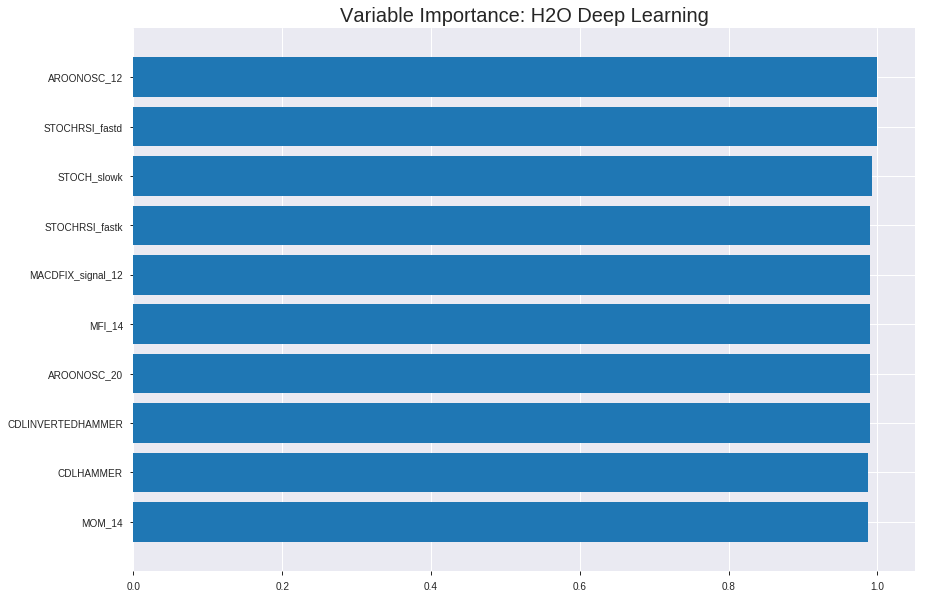

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_200038_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.23496683298164484
RMSE: 0.48473377536710277
LogLoss: 0.6585735414426326
Mean Per-Class Error: 0.3607853995414071
AUC: 0.7026360621979265
pr_auc: 0.7086732159113236
Gini: 0.40527212439585303
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.534766879557671: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      197  562   0.7404   (562.0/759.0)
1      47   731   0.0604   (47.0/778.0)
Total  244  1293  0.3962   (609.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.534767     0.705939  273
max f2                       0.422412     0.849098  328
max f0point5                 0.658398     0.645304  171
max accuracy                 0.658398     0.638256  171
max precision                0.998885     1         0
max recall                   0.193674     1         382
max specificity              0.998885     1         0
max absolute_mcc             0.590028     0.290737  234
max min_per_class_accuracy   0.636362     0.635046  190
max mean_per_class_accuracy  0.658398     0.639215  171

Gains/Lift Table: Avg response rate: 50.62 %, avg score: 64.01 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.972226           1.97558   1.97558            1                0.988859  1                           0.988859            0.0205656       0.0205656                  97.5578   97.5578
    2        0.0201692                   0.94511            1.97558   1.97558            1                0.956108  1                           0.973012            0.0192802       0.0398458                  97.5578   97.5578
    3        0.0305791                   0.916981           1.72863   1.89151            0.875            0.928572  0.957447                    0.957883            0.0179949       0.0578406                  72.8631   89.1511
    4        0.0403383                   0.894545           1.84387   1.87999            0.933333         0.906452  0.951613                    0.94544             0.0179949       0.0758355                  84.3873   87.9986
    5        0.0500976                   0.878029           1.31705   1.77032            0.666667         0.887019  0.896104                    0.93406             0.0128535       0.0886889                  31.7052   77.0324
    6        0.100195                    0.817232           1.61638   1.69335            0.818182         0.844709  0.857143                    0.889384            0.0809769       0.169666                   61.6382   69.3353
    7        0.150293                    0.783557           1.46244   1.61638            0.74026          0.7982    0.818182                    0.858989            0.0732648       0.242931                   46.2441   61.6382
    8        0.20039                     0.751583           1.02627   1.46886            0.519481         0.767442  0.743506                    0.836103            0.0514139       0.294344                   2.62745   46.8855
    9        0.299935                    0.703557           1.17502   1.37133            0.594771         0.72607   0.694143                    0.799584            0.116967        0.411311                   17.5017   37.1334
    10       0.40013                     0.66598            1.19304   1.32669            0.603896         0.684257  0.671545                    0.770705            0.119537        0.530848                   19.3044   32.6689
    11       0.500325                    0.636565           1.05193   1.27167            0.532468         0.651107  0.643693                    0.746755            0.105398        0.636247                   5.19314   27.1666
    12       0.59987                     0.611788           0.878035  1.20635            0.444444         0.62294   0.610629                    0.726208            0.0874036       0.72365                    -12.1965  20.6346
    13       0.700065                    0.590123           1.06476   1.18608            0.538961         0.600231  0.600372                    0.708178            0.106684        0.830334                   6.47598   18.6081
    14       0.79961                     0.562186           0.748912  1.13166            0.379085         0.578178  0.572823                    0.691994            0.0745501       0.904884                   -25.1088  13.1658
    15       0.899805                    0.479091           0.731221  1.08707            0.37013          0.526187  0.550253                    0.673531            0.0732648       0.978149                   -26.8779  8.70681
    16       1                           0.00526697         0.218083  1                  0.11039          0.339528  0.506181                    0.640066         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2939410995821764
RMSE: 0.5421633513823821
LogLoss: 0.8010578927843908
Mean Per-Class Error: 0.4890075637935334
AUC: 0.4712409608511346
pr_auc: 0.4985002977478302
Gini: -0.05751807829773081
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.11412395838251409: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    209  0.9858   (209.0/212.0)
1      0    227  0        (0.0/227.0)
Total  3    436  0.4761   (209.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.114124     0.684766   396
max f2                       0.114124     0.844494   396
max f0point5                 0.114124     0.57585    396
max accuracy                 0.295561     0.526196   376
max precision                0.999883     1          0
max recall                   0.114124     1          396
max specificity              0.999883     1          0
max absolute_mcc             0.540626     0.0988844  301
max min_per_class_accuracy   0.643853     0.462555   194
max mean_per_class_accuracy  0.295561     0.510992   376

Gains/Lift Table: Avg response rate: 51.71 %, avg score: 61.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.924112           1.16035   1.16035            0.6              0.951217  0.6                         0.951217            0.0132159       0.0132159                  16.0352   16.0352
    2        0.0205011                   0.889006           0         0.64464            0                0.902581  0.333333                    0.929601            0               0.0132159                  -100      -35.536
    3        0.0318907                   0.871679           1.16035   0.828823           0.6              0.878774  0.428571                    0.911448            0.0132159       0.0264317                  16.0352   -17.1177
    4        0.0410023                   0.853253           0.96696   0.85952            0.5              0.861555  0.444444                    0.900361            0.00881057      0.0352423                  -3.30396  -14.048
    5        0.0501139                   0.839981           0.96696   0.879055           0.5              0.846792  0.454545                    0.890621            0.00881057      0.0440529                  -3.30396  -12.0945
    6        0.100228                    0.792056           1.05487   0.96696            0.545455         0.815995  0.5                         0.853308            0.0528634       0.0969163                  5.48658   -3.30396
    7        0.150342                    0.779068           1.05487   0.996262           0.545455         0.785362  0.515152                    0.83066             0.0528634       0.14978                    5.48658   -0.373782
    8        0.200456                    0.750006           0.96696   0.988937           0.5              0.765317  0.511364                    0.814324            0.0484581       0.198238                   -3.30396  -1.10633
    9        0.300683                    0.700546           0.923008  0.96696            0.477273         0.724848  0.5                         0.784498            0.092511        0.290749                   -7.69924  -3.30396
    10       0.400911                    0.665212           0.879055  0.944984           0.454545         0.68216   0.488636                    0.758914            0.0881057       0.378855                   -12.0945  -5.5016
    11       0.501139                    0.636279           0.879055  0.931798           0.454545         0.652036  0.481818                    0.737538            0.0881057       0.46696                    -12.0945  -6.82018
    12       0.599089                    0.613238           1.2593    0.985344           0.651163         0.624353  0.509506                    0.719033            0.123348        0.590308                   25.9297   -1.46564
    13       0.699317                    0.58368            0.879055  0.97011            0.454545         0.598226  0.501629                    0.701718            0.0881057       0.678414                   -12.0945  -2.98899
    14       0.799544                    0.487059           0.96696   0.969715           0.5              0.54442   0.501425                    0.682               0.0969163       0.77533                    -3.30396  -3.02848
    15       0.899772                    0.362191           1.18672   0.993888           0.613636         0.441987  0.513924                    0.655264            0.118943        0.894273                   18.6724   -0.611164
    16       1                           0.0164474          1.05487   1                  0.545455         0.263365  0.517084                    0.61


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 20:06:29  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 20:06:33  5.200 sec         184 obs/sec       0.467794  1             719        0.59216          1.10471             -0.402827      0.525928        0.531598           1.48168          0.493819                         0.613652           1.19205               -0.508035        0.551669          0.545138             1.16035            0.462415
    2019-08-28 20:06:46  17.808 sec        285 obs/sec       2.8432    6             4370       0.622096         1.14703             -0.548251      0.60942         0.630967           1.8521           0.470397                         0.645495           1.34512               -0.668603        0.513735          0.521042             0.773568           0.47836
    2019-08-28 20:06:59  31.298 sec        347 obs/sec       6.23357   13            9581       0.484734         0.658574            0.059989       0.702636        0.708673           1.97558          0.396226                         0.542163           0.801058              -0.177139        0.471241          0.4985               1.16035            0.476082
    2019-08-28 20:07:12  44.088 sec        356 obs/sec       9.06701   19            13936      0.53816          0.856305            -0.158641      0.707836        0.733625           1.97558          0.427456                         0.602751           1.0279                -0.454934        0.465921          0.485086             1.16035            0.476082
    2019-08-28 20:07:25  57.163 sec        376 obs/sec       12.488    26            19194      0.436688         0.556457            0.237097       0.801683        0.80619            1.97558          0.30514                          0.581111           1.00658               -0.352338        0.479075          0.491025             1.16035            0.480638
    2019-08-28 20:07:38  1 min 10.009 sec  389 obs/sec       15.8673   33            24388      0.430444         0.557425            0.258758       0.823346        0.803904           1.97558          0.275211                         0.593178           1.11346               -0.409083        0.500748          0.525343             1.93392            0.476082
    2019-08-28 20:07:51  1 min 22.717 sec  399 obs/sec       19.2271   40            29552      0.398572         0.471409            0.364466       0.856476        0.836865           1.97558          0.241379                         0.58937            1.12732               -0.391052        0.495709          0.517118             1.16035            0.464692
    2019-08-28 20:08:03  1 min 35.609 sec  405 obs/sec       22.607    47            34747      0.37184          0.409439            0.446855       0.916158        0.860184           1.97558          0.192583                         0.61976            1.30556               -0.538206        0.479802          0.489705             1.16035            0.47836
    2019-08-28 20:08:05  

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
AROONOSC_12               1.0                    1.0                  0.004255439078264475
STOCHRSI_fastd            0.9988786578178406     0.9988786578178406   0.004250667274922408
STOCH_slowk               0.992165207862854      0.992165207862854    0.004222098597633985
STOCHRSI_fastk            0.9904347658157349     0.9904347658157349   0.004214734806924002
MACDFIX_signal_12         0.9901295304298401     0.9901295304298401   0.004213435896334797
---                       ---                    ---                  ---
BBANDS_middleband_14_4_2  0.8771973848342896     0.8771973848342896   0.0037328600307752376
BBANDS_middleband_14_6_4  0.8761973977088928     0.8761973977088928   0.003728604646484063
APO                       0.8734028935432434     0.8734028935432434   0.0037167128042531854
BBANDS_upperband_20_3_4   0.8658604025840759     0.8658604025840759   0.0036846161934780877
BBANDS_middleband_20_0_4  0.8614538311958313     0.8614538311958313   0.0036658642973913893


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5681818181818182)

('F1', 0.6869300911854104)

('auc', 0.5442064345380863)

('logloss', 0.7651428049359392)

('mean_per_class_error', 0.4317674303200728)

('rmse', 0.5252463795093845)

('mse', 0.27588375918771635)

deeplearning prediction progress: |███████████████████████████████████████| 100%


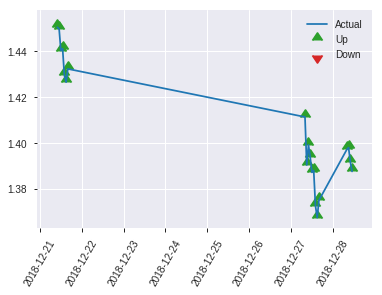


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.27588375918771635
RMSE: 0.5252463795093845
LogLoss: 0.7651428049359392
Mean Per-Class Error: 0.4317674303200728
AUC: 0.5442064345380863
pr_auc: 0.5441670485433245
Gini: 0.08841286907617252
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3717813820312498: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    103  0.9626   (103.0/107.0)
1      0    113  0        (0.0/113.0)
Total  4    216  0.4682   (103.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.371781     0.68693   215
max f2                       0.371781     0.845808  215
max f0point5                 0.619023     0.580848  130
max accuracy                 0.651099     0.568182  109
max precision                0.775686     0.692308  38
max recall                   0.371781     1         215
max specificity              0.966877     0.990654  0
max absolute_mcc             0.775686     0.165936  38
max min_per_class_accuracy   0.651099     0.566372  109
max mean_per_class_accuracy  0.651099     0.568233  109

Gains/Lift Table: Avg response rate: 51.36 %, avg score: 64.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.915951           0         0                  0                0.945638  0                           0.945638            0               0                          -100      -100
    2        0.0227273                   0.882379           0.973451  0.389381           0.5              0.890792  0.2                         0.9237              0.00884956      0.00884956                 -2.65487  -61.0619
    3        0.0318182                   0.866162           0.973451  0.556258           0.5              0.87351   0.285714                    0.90936             0.00884956      0.0176991                  -2.65487  -44.3742
    4        0.0409091                   0.855501           0.973451  0.648968           0.5              0.858436  0.333333                    0.898044            0.00884956      0.0265487                  -2.65487  -35.1032
    5        0.05                        0.83957            0.973451  0.707965           0.5              0.853158  0.363636                    0.889883            0.00884956      0.0353982                  -2.65487  -29.2035
    6        0.1                         0.800222           1.41593   1.06195            0.727273         0.821741  0.545455                    0.855812            0.0707965       0.106195                   41.5929   6.19469
    7        0.15                        0.785741           1.59292   1.23894            0.818182         0.794015  0.636364                    0.835213            0.079646        0.185841                   59.292    23.8938
    8        0.2                         0.759517           1.41593   1.28319            0.727273         0.773392  0.659091                    0.819758            0.0707965       0.256637                   41.5929   28.3186
    9        0.3                         0.716837           0.973451  1.17994            0.5              0.737052  0.606061                    0.792189            0.0973451       0.353982                   -2.65487  17.9941
    10       0.4                         0.678364           0.973451  1.12832            0.5              0.69791   0.579545                    0.768619            0.0973451       0.451327                   -2.65487  12.8319
    11       0.5                         0.650928           1.15044   1.13274            0.590909         0.662254  0.581818                    0.747346            0.115044        0.566372                   15.0442   13.2743
    12       0.6                         0.615986           0.884956  1.09145            0.454545         0.635598  0.560606                    0.728722            0.0884956       0.654867                   -11.5044  9.14454
    13       0.7                         0.59353            0.353982  0.986094           0.181818         0.604656  0.506494                    0.710998            0.0353982       0.690265                   -64.6018  -1.39064
    14       0.8                         0.549689           0.79646   0.962389           0.409091         0.568953  0.494318                    0.693242            0.079646        0.769912                   -20.354   -3.76106
    15       0.9                         0.486099           1.32743   1.00295            0.681818         0.514766  0.515152                    0.673412            0.132743        0.902655                   32.7434   0.294985
    16       1                           0.274028           0.973451  1                  0.5              0.417243  0.513636                    0.647795     

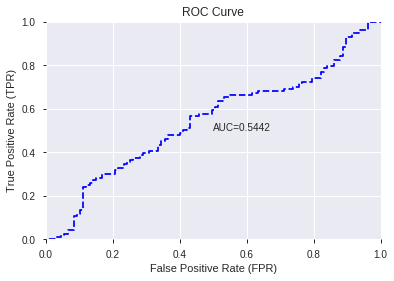

This function is available for GLM models only


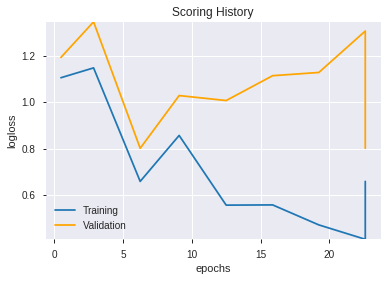

--2019-08-28 20:10:50--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.89.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.89.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


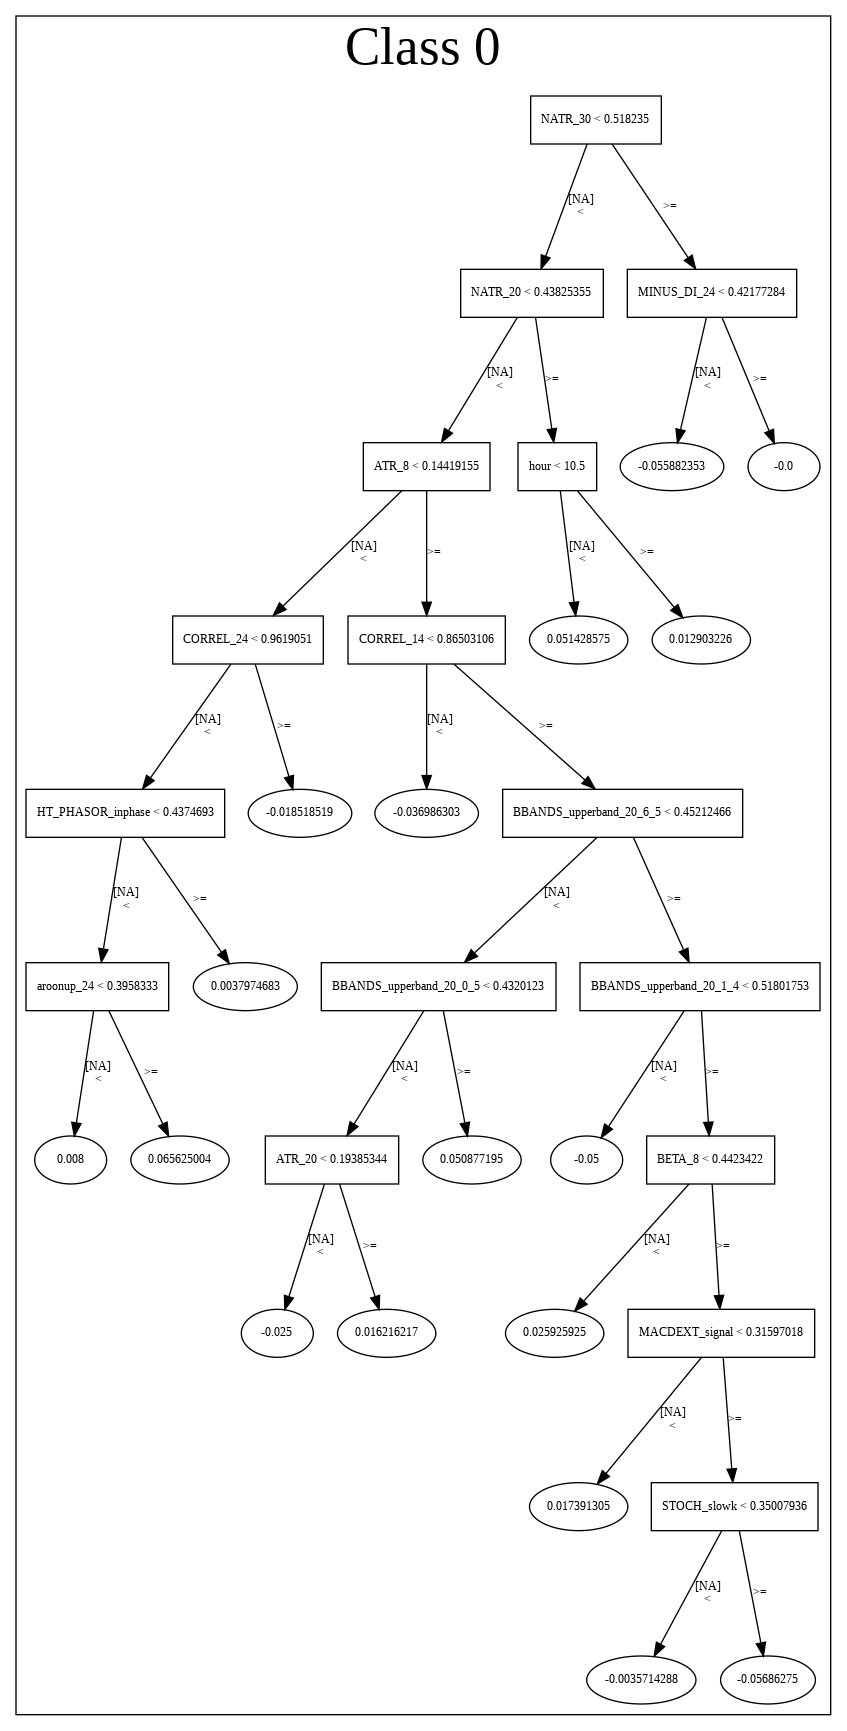

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_200038_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_200038_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_a8f4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['AROONOSC_12',
 'STOCHRSI_fastd',
 'STOCH_slowk',
 'STOCHRSI_fastk',
 'MACDFIX_signal_12',
 'MFI_14',
 'AROONOSC_20',
 'CDLINVERTEDHAMMER',
 'CDLHAMMER',
 'MOM_14',
 'BBANDS_upperband_14_7_3',
 'ROCR100_14',
 'BBANDS_lowerband_14_5_3',
 'aroondown_8',
 'LINEARREG_SLOPE_8',
 'CDLLONGLEGGEDDOJI',
 'BBANDS_upperband_24_2_4',
 'MINUS_DI_30',
 'BBANDS_middleband_14_5_2',
 'BBANDS_lowerband_30_1_3',
 'CORREL_12',
 'MA_24_6',
 'LINEARREG_12',
 'MAVP_20_6',
 'VAR_8',
 'BETA_14',
 'BBANDS_middleband_20_7_4',
 'BBANDS_upperband_20_2_2',
 'LINEARREG_SLOPE_12',
 'BBANDS_middleband_14_6_2',
 'ROCP_8',
 'WILLR_20',
 'BBANDS_lowerband_24_0_4',
 'ROCR100_24',
 'BBANDS_middleband_14_3_5',
 'BBANDS_upperband_30_7_4',
 'BBANDS_lowerband_14_3_4',
 'MAVP_14_4',
 'aroonup_14',
 'LINEARREG_14',
 'BBANDS_middleband_14_4_5',
 'EMA_20',
 'BBANDS_upperband_14_5_5',
 'CDLHIKKAKE',
 'MACDFIX_hist_24',
 'CDLBELTHOLD',
 'aroondown_24',
 'aroonup_12',
 'AD',
 'CORREL_14',
 'PLUS_DM_12',
 'ADX_24',
 'BBANDS_upperband

In [52]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_201058_model_1  0.489786  0.693572              0.490654  0.500213  0.250213

variable  relative_importance  scaled_importance  percentage
0          CDLINVERTEDHAMMER         9.440469e-03           1.000000    0.031010
1               CDLTHRUSTING         7.796981e-03           0.825910    0.025611
2             CDLMATCHINGLOW         7.546527e-03           0.799381    0.024788
3                  aroonup_8         6.655752e-03           0.705023    0.021862
4                CDLBELTHOLD         5.480929e-03           0.580578    0.018003
..                       ...                  ...                ...         ...
246  BBANDS_upperband_14_7_3         2.007326e-05           0.002126    0.000066
247              MIDPRICE_30         1.395950e-05           0.001479    0.000046
248                   RSI_24         1.162411e-05           0.001231    0.000038
249  BBANDS_lowerband_30_2_2         7.854450e-06           0.000832    0.000026
250  BBANDS_lowerband_30_1_5         9.550724e-07           0.000101    0.000003

[251 rows x 4 columns]

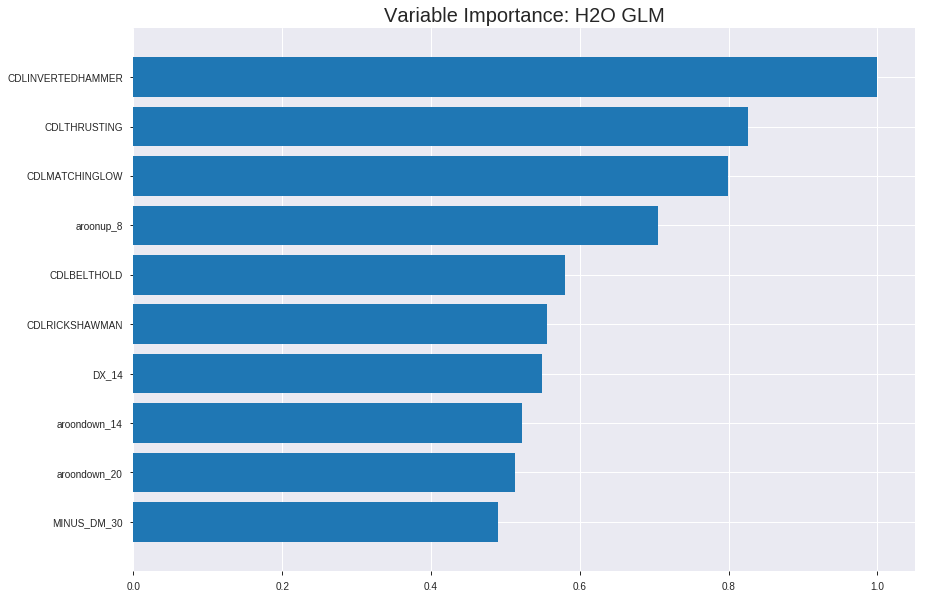

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_201058_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24808031213273082
RMSE: 0.49807661271407916
LogLoss: 0.6893019854892133
Null degrees of freedom: 1536
Residual degrees of freedom: 1285
Null deviance: 2130.499553929498
Residual deviance: 2118.9143033938417
AIC: 2622.9143033938417
AUC: 0.5669532025293733
pr_auc: 0.5793438004631468
Gini: 0.13390640505874662
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4728462365644079: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      39   720   0.9486   (720.0/759.0)
1      12   766   0.0154   (12.0/778.0)
Total  51   1486  0.4763   (732.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.472846     0.676678  363
max f2                       0.461905     0.837646  388
max f0point5                 0.494981     0.579632  270
max accuracy                 0.494981     0.554977  270
max precision                0.551619     1         0
max recall                   0.457319     1         395
max specificity              0.551619     1         0
max absolute_mcc             0.494981     0.123399  270
max min_per_class_accuracy   0.508114     0.533419  184
max mean_per_class_accuracy  0.494981     0.551595  270

Gains/Lift Table: Avg response rate: 50.62 %, avg score: 50.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0104099                   0.540982           1.8521    1.8521             0.9375           0.54426   0.9375                      0.54426             0.0192802       0.0192802                  85.2105    85.2105
    2        0.0201692                   0.53547            1.31705   1.59321            0.666667         0.538274  0.806452                    0.541363            0.0128535       0.0321337                  31.7052    59.3208
    3        0.0305791                   0.533311           1.11126   1.42914            0.5625           0.534212  0.723404                    0.538929            0.0115681       0.0437018                  11.1263    42.9142
    4        0.0403383                   0.531418           1.18535   1.37016            0.6              0.532226  0.693548                    0.537307            0.0115681       0.0552699                  18.5347    37.0159
    5        0.0500976                   0.530309           1.71217   1.43678            0.866667         0.530821  0.727273                    0.536044            0.0167095       0.0719794                  71.2168    43.6784
    6        0.100195                    0.525099           1.15456   1.29567            0.584416         0.52761   0.655844                    0.531827            0.0578406       0.12982                    15.4559    29.5672
    7        0.150293                    0.521631           1.07759   1.22298            0.545455         0.523329  0.619048                    0.528994            0.0539846       0.183805                   7.75882    22.2977
    8        0.20039                     0.519342           0.923647  1.14814            0.467532         0.520434  0.581169                    0.526854            0.0462725       0.230077                   -7.6353    14.8145
    9        0.299935                    0.51479            1.07172   1.12278            0.542484         0.517132  0.56833                     0.523627            0.106684        0.336761                   7.1719     12.278
    10       0.40013                     0.511261           0.974961  1.08577            0.493506         0.513045  0.549593                    0.520978            0.0976864       0.434447                   -2.50392   8.5765
    11       0.500325                    0.507945           1.00062   1.06871            0.506494         0.50969   0.540962                    0.518717            0.100257        0.534704                   0.0617634  6.87134
    12       0.59987                     0.503238           1.09754   1.0735             0.555556         0.505595  0.543384                    0.51654             0.109254        0.643959                   9.75436    7.34976
    13       0.700065                    0.499197           1.00062   1.06307            0.506494         0.501255  0.538104                    0.514352            0.100257        0.744216                   0.0617634  6.30668
    14       0.79961                     0.493251           1.00716   1.05611            0.509804         0.496488  0.534581                    0.512128            0.100257        0.844473                   0.715762   5.61066
    15       0.899805                    0.484999           0.731221  1.01993            0.37013          0.489697  0.516269                    0.50963             0.0732648       0.917738                   -26.8779   1.99298
    16       1                           0.44204            0.82102   1                  0.415584         0.475203  0.506181                    0.



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.25043401974759266
RMSE: 0.5004338315377895
LogLoss: 0.6940203830025097
Null degrees of freedom: 438
Residual degrees of freedom: 187
Null deviance: 608.2794432341497
Residual deviance: 609.3498962762035
AIC: 1113.3498962762035
AUC: 0.5055066079295154
pr_auc: 0.5199676491793508
Gini: 0.011013215859030812
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43934259179780005: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    211  0.9953   (211.0/212.0)
1      0    227  0        (0.0/227.0)
Total  1    438  0.4806   (211.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.439343     0.682707   398
max f2                       0.439343     0.843239   398
max f0point5                 0.439343     0.573522   398
max accuracy                 0.496226     0.539863   263
max precision                0.552534     1          0
max recall                   0.439343     1          398
max specificity              0.552534     1          0
max absolute_mcc             0.534887     0.0866253  6
max min_per_class_accuracy   0.502652     0.514151   193
max mean_per_class_accuracy  0.496226     0.533715   263

Gains/Lift Table: Avg response rate: 51.71 %, avg score: 50.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.535318           1.54714   1.54714            0.8              0.539439  0.8                         0.539439            0.0176211       0.0176211                  54.7137   54.7137
    2        0.0205011                   0.534337           1.45044   1.50416            0.75             0.534807  0.777778                    0.53738             0.0132159       0.030837                   45.0441   50.4161
    3        0.0318907                   0.532618           0.773568  1.24323            0.4              0.533351  0.642857                    0.535941            0.00881057      0.0396476                  -22.6432  24.3235
    4        0.0410023                   0.531641           0.48348   1.0744             0.25             0.532007  0.555556                    0.535067            0.00440529      0.0440529                  -51.652   7.44004
    5        0.0501139                   0.52962            0.48348   0.96696            0.25             0.530497  0.5                         0.534236            0.00440529      0.0484581                  -51.652   -3.30396
    6        0.100228                    0.524626           0.791149  0.879055           0.409091         0.526778  0.454545                    0.530507            0.0396476       0.0881057                  -20.8851  -12.0945
    7        0.150342                    0.519365           1.05487   0.937659           0.545455         0.521349  0.484848                    0.527454            0.0528634       0.140969                   5.48658   -6.23415
    8        0.200456                    0.515699           1.05487   0.96696            0.545455         0.517546  0.5                         0.524977            0.0528634       0.193833                   5.48658   -3.30396
    9        0.300683                    0.511451           0.923008  0.952309           0.477273         0.513539  0.492424                    0.521164            0.092511        0.286344                   -7.69924  -4.76906
    10       0.400911                    0.507111           1.27463   1.03289            0.659091         0.509154  0.534091                    0.518162            0.127753        0.414097                   27.463    3.28895
    11       0.501139                    0.502652           1.01091   1.02849            0.522727         0.504692  0.531818                    0.515468            0.101322        0.515419                   1.09131   2.84942
    12       0.599089                    0.499373           1.0794    1.03682            0.55814          0.500992  0.536122                    0.513101            0.105727        0.621145                   7.93976   3.68168
    13       0.699317                    0.495077           1.05487   1.0394             0.545455         0.497365  0.537459                    0.510846            0.105727        0.726872                   5.48658   3.94036
    14       0.799544                    0.489892           0.747197  1.00277            0.386364         0.492589  0.518519                    0.508557            0.0748899       0.801762                   -25.2803  0.27737
    15       0.899772                    0.478141           0.923008  0.993888           0.477273         0.485604  0.513924                    0.506               0.092511        0.894273                   -7.69924  -0.611164
    16       1                           0.437744           1.05487   1                  0.545455         0.460985  0.517084                    0.501489  


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 20:10:58  0.000 sec   2            3.4       252           1.3786            1.38804
    2019-08-28 20:10:59  0.141 sec   4            2.5       252           1.37672           1.38937
    2019-08-28 20:10:59  0.282 sec   6            1.8       252           1.37454           1.39079
    2019-08-28 20:10:59  0.435 sec   8            1.3       252           1.37205           1.39259
    2019-08-28 20:10:59  0.574 sec   10           0.95      252           1.36925           1.39467

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5318181818181819)

('F1', 0.6827794561933536)

('auc', 0.48978579108427756)

('logloss', 0.6935722949855242)

('mean_per_class_error', 0.4592258704821768)

('rmse', 0.5002127219831362)

('mse', 0.2502127672337783)

glm prediction progress: |████████████████████████████████████████████████| 100%


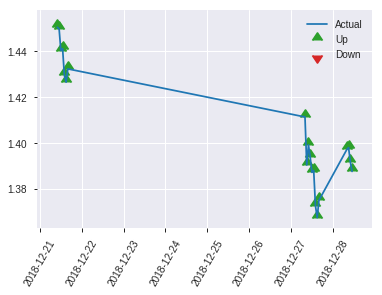


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2502127672337783
RMSE: 0.5002127219831362
LogLoss: 0.6935722949855242
Null degrees of freedom: 219
Residual degrees of freedom: -32
Null deviance: 304.8700323300008
Residual deviance: 305.1718097936306
AIC: 809.1718097936306
AUC: 0.48978579108427756
pr_auc: 0.5253872677692594
Gini: -0.02042841783144489
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47941233428900754: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    105  0.9813   (105.0/107.0)
1      0    113  0        (0.0/113.0)
Total  2    218  0.4773   (105.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.479412     0.682779  217
max f2                       0.479412     0.843284  217
max f0point5                 0.479412     0.573604  217
max accuracy                 0.513748     0.531818  37
max precision                0.531247     1         0
max recall                   0.479412     1         217
max specificity              0.531247     1         0
max absolute_mcc             0.49606      0.139542  162
max min_per_class_accuracy   0.502796     0.486726  108
max mean_per_class_accuracy  0.513748     0.540774  37

Gains/Lift Table: Avg response rate: 51.36 %, avg score: 50.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.529163           1.29794   1.29794            0.666667         0.530611  0.666667                    0.530611            0.0176991       0.0176991                  29.7935   29.7935
    2        0.0227273                   0.525465           0.973451  1.16814            0.5              0.526436  0.6                         0.528941            0.00884956      0.0265487                  -2.65487  16.8142
    3        0.0318182                   0.524722           0.973451  1.11252            0.5              0.525144  0.571429                    0.527856            0.00884956      0.0353982                  -2.65487  11.2516
    4        0.0409091                   0.522562           0.973451  1.08161            0.5              0.52365   0.555556                    0.526922            0.00884956      0.0442478                  -2.65487  8.16126
    5        0.05                        0.521334           0.973451  1.06195            0.5              0.522194  0.545455                    0.526062            0.00884956      0.0530973                  -2.65487  6.19469
    6        0.1                         0.517295           1.23894   1.15044            0.636364         0.519148  0.590909                    0.522605            0.0619469       0.115044                   23.8938   15.0442
    7        0.15                        0.515153           1.23894   1.17994            0.636364         0.516355  0.606061                    0.520522            0.0619469       0.176991                   23.8938   17.9941
    8        0.2                         0.513037           1.06195   1.15044            0.545455         0.513895  0.590909                    0.518865            0.0530973       0.230088                   6.19469   15.0442
    9        0.3                         0.508423           0.884956  1.06195            0.454545         0.510632  0.545455                    0.516121            0.0884956       0.318584                   -11.5044  6.19469
    10       0.4                         0.505074           0.884956  1.0177             0.454545         0.506643  0.522727                    0.513751            0.0884956       0.40708                    -11.5044  1.76991
    11       0.5                         0.502705           0.79646   0.973451           0.409091         0.503864  0.5                         0.511774            0.079646        0.486726                   -20.354   -2.65487
    12       0.6                         0.500094           0.973451  0.973451           0.5              0.501441  0.5                         0.510052            0.0973451       0.584071                   -2.65487  -2.65487
    13       0.7                         0.497938           0.884956  0.960809           0.454545         0.499035  0.493506                    0.508478            0.0884956       0.672566                   -11.5044  -3.91909
    14       0.8                         0.492353           0.973451  0.962389           0.5              0.495327  0.494318                    0.506834            0.0973451       0.769912                   -2.65487  -3.76106
    15       0.9                         0.487055           1.32743   1.00295            0.681818         0.489791  0.515152                    0.50494             0.132743        0.902655                   32.7434   0.294985
    16       1                           0.473813           0.973451  1                  0.5              0.482295  0.513636                    0.502676    

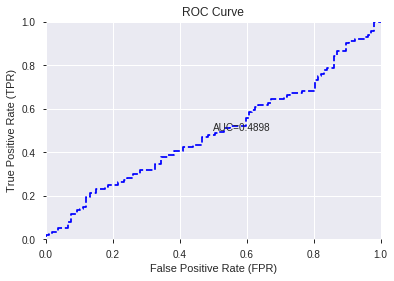

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


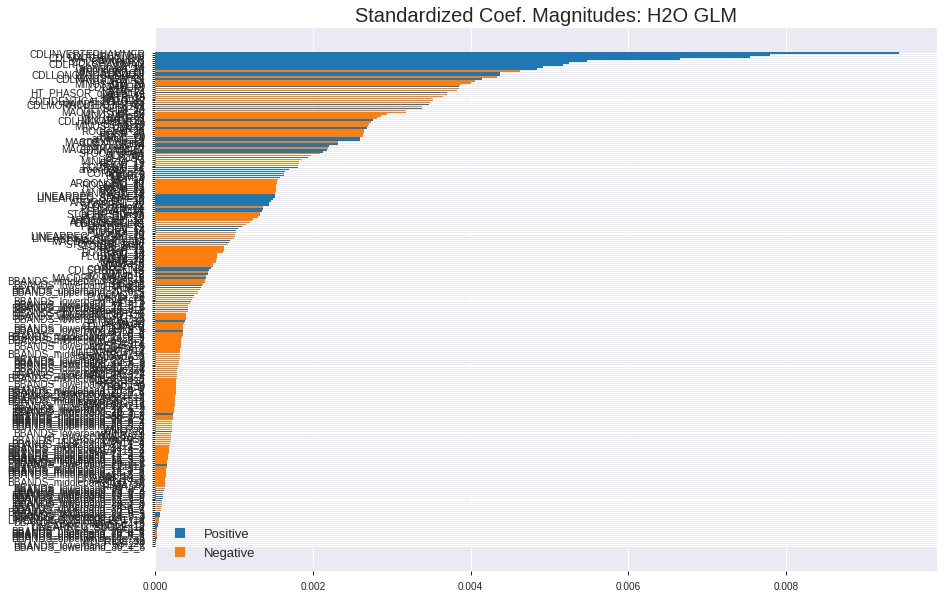

'log_likelihood'
--2019-08-28 20:11:08--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.128.11
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.128.11|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


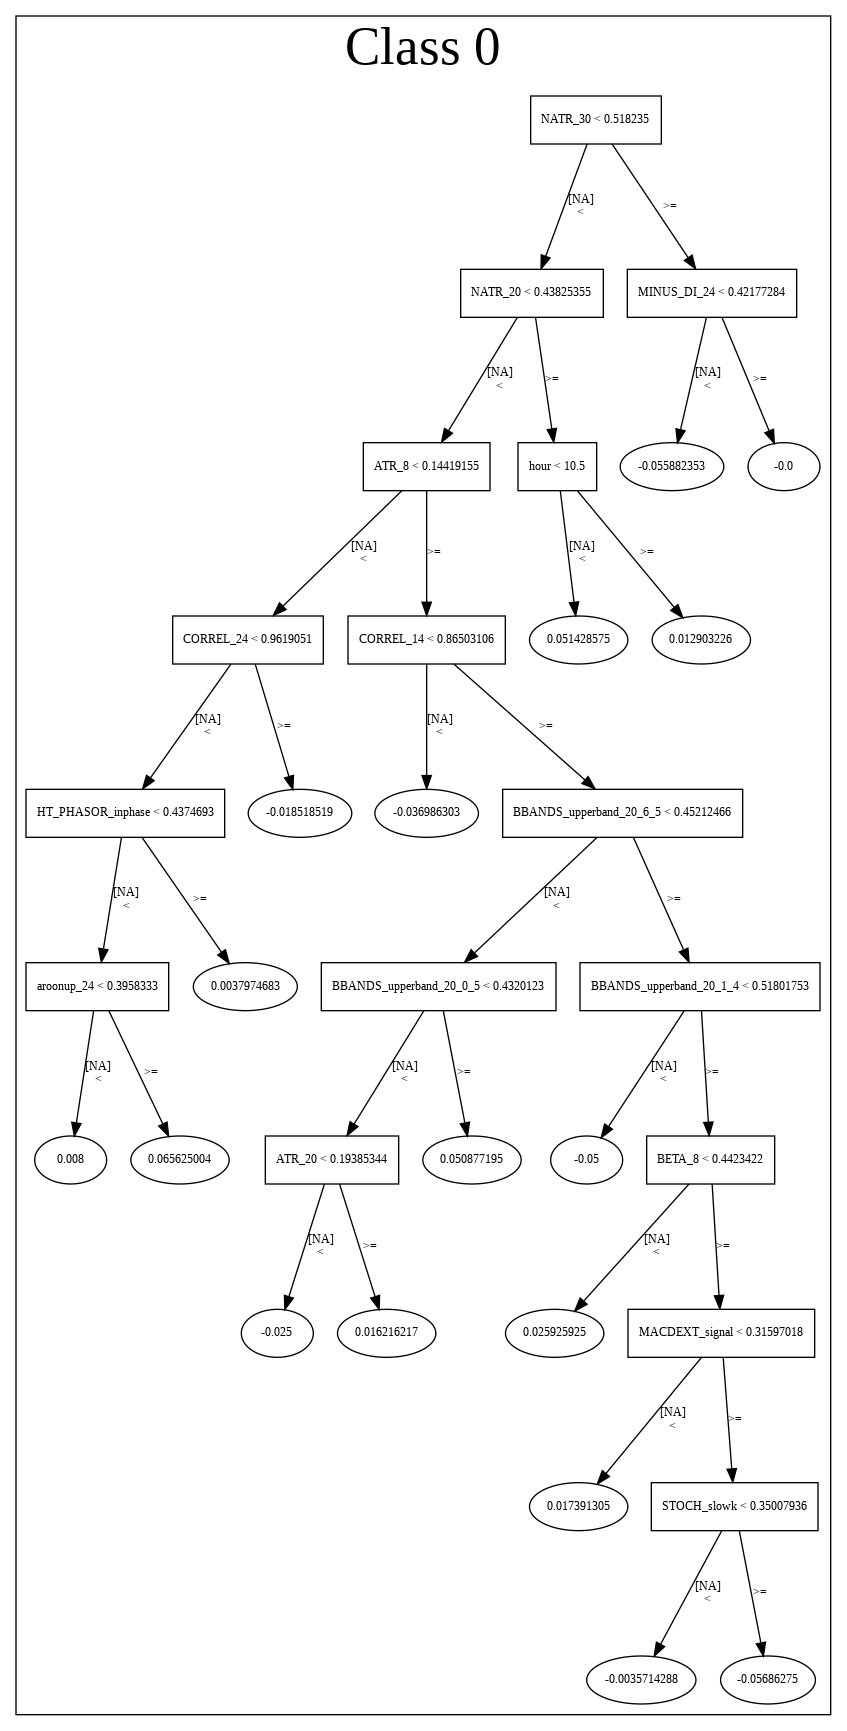

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_201058_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_201058_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_a8f4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['CDLINVERTEDHAMMER',
 'CDLTHRUSTING',
 'CDLMATCHINGLOW',
 'aroonup_8',
 'CDLBELTHOLD',
 'CDLRICKSHAWMAN',
 'DX_14',
 'aroondown_14',
 'aroondown_20',
 'MINUS_DM_30',
 'CDLDOJI',
 'CDLLONGLEGGEDDOJI',
 'MINUS_DM_24',
 'CDLHANGINGMAN',
 'ATR_14',
 'MINUS_DM_20',
 'NATR_20',
 'CDLTAKURI',
 'ATR_12',
 'NATR_24',
 'HT_PHASOR_quadrature',
 'NATR_14',
 'NATR_30',
 'NATR_12',
 'CDLIDENTICAL3CROWS',
 'MACDFIX_hist_24',
 'CDLMORNINGDOJISTAR',
 'BETA_14',
 'DX_20',
 'MACDFIX_hist_20',
 'MINUS_DI_30',
 'MFI_24',
 'NATR_8',
 'MINUS_DI_24',
 'CDLHIKKAKEMOD',
 'BETA_20',
 'MINUS_DM_12',
 'APO',
 'VAR_8',
 'ROCR100_20',
 'ROCR_20',
 'ROCP_20',
 'ROC_20',
 'aroonup_14',
 'aroondown_12',
 'MACDEXT_signal',
 'DX_24',
 'aroonup_20',
 'MACDFIX_hist_12',
 'CDLHAMMER',
 'STOCH_slowd',
 'ADX_24',
 'AD',
 'ULTOSC',
 'MINUS_DI_14',
 'ROCP_12',
 'ROCR_12',
 'ROCR100_12',
 'aroondown_24',
 'VAR_12',
 'CORREL_20',
 'ROCP_8',
 'MOM_8',
 'MFI_14',
 'MFI_30',
 'AROONOSC_20',
 'ROCR100_24',
 'MOM_24',
 'ROCR_24',
 'R

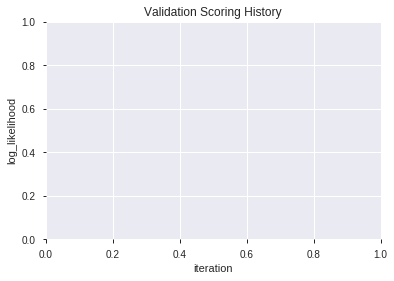

In [53]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_201115_model_3  0.505748  0.705677              0.490654  0.505975  0.256011
1               XGBoost_1_AutoML_20190828_201115  0.490034  0.721405              0.500000  0.513007  0.263177
2  XGBoost_grid_1_AutoML_20190828_201115_model_4  0.485072  0.705048              0.500000  0.505834  0.255868
3  XGBoost_grid_1_AutoML_20190828_201115_model_7  0.469192  0.719792              0.500000  0.512657  0.262818
4  XGBoost_grid_1_AutoML_20190828_201115_model_6  0.468696  0.708837              0.490654  0.507667  0.257725
5  XGBoost_grid_1_AutoML_20190828_201115_model_5  0.464230  0.749004              0.500000  0.525225  0.275861
6  XGBoost_grid_1_AutoML_20190828_201115_model_2  0.462493  0.706801              0.500000  0.506736  0.256781
7  XGBoost_grid_1_AutoML_20190828_201115_model_1  0.453395  0.714948              0.495327  0.510616  0.260729
8               XGBoost_2_AutoML_20190828_201115  0.440906  0.721685              0.500000  0.513655  0.263841
9               XGBoost_3_AutoML_20190828_201115  0.432801  0.723177              0.500000  0.514400  0.264608

variable  relative_importance  scaled_importance  percentage
0                       DX_20           111.519653           1.000000    0.022717
1                       VAR_8            90.223572           0.809037    0.018379
2                 MINUS_DM_20            88.862755           0.796835    0.018102
3        HT_PHASOR_quadrature            87.999977           0.789098    0.017926
4             MACDFIX_hist_24            83.939850           0.752691    0.017099
..                        ...                  ...                ...         ...
178                   ROCR_24             3.485821           0.031257    0.000710
179   BBANDS_lowerband_30_7_3             2.518469           0.022583    0.000513
180  BBANDS_middleband_14_5_5             2.477829           0.022219    0.000505
181                 MAVP_20_5             1.455925           0.013055    0.000297
182                    MOM_24             0.721395           0.006469    0.000147

[183 rows x 4 columns]

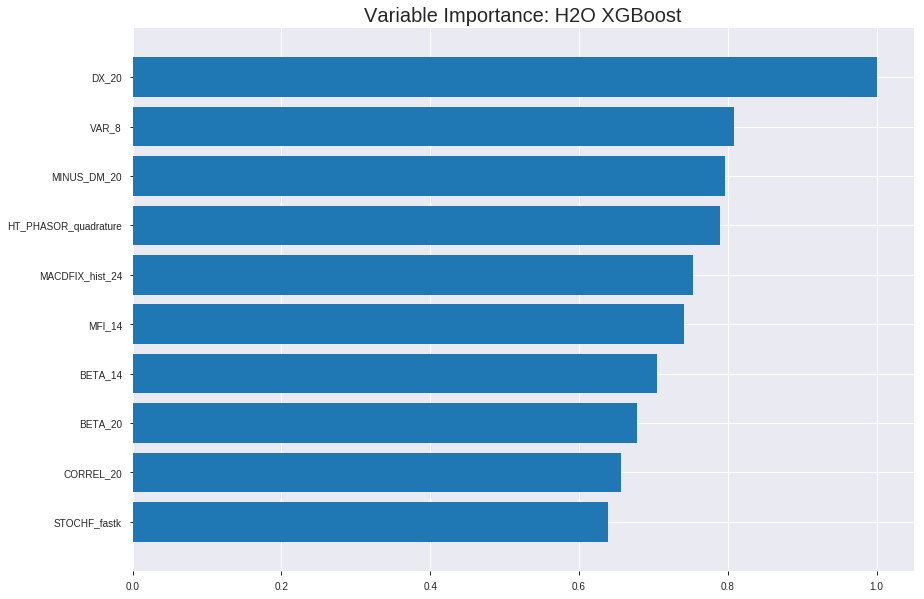

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_201115_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.18235642648742997
RMSE: 0.42703211411722886
LogLoss: 0.5535753302176699
Mean Per-Class Error: 0.15686229682541297
AUC: 0.9208275331836302
pr_auc: 0.9273877577458475
Gini: 0.8416550663672604
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4970705360174179: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      620  139  0.1831   (139.0/759.0)
1      110  668  0.1414   (110.0/778.0)
Total  730  807  0.162    (249.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.497071     0.842902  207
max f2                       0.436978     0.893155  261
max f0point5                 0.535626     0.870769  167
max accuracy                 0.52072      0.84255   183
max precision                0.811983     1         0
max recall                   0.302936     1         370
max specificity              0.811983     1         0
max absolute_mcc             0.52072      0.688807  183
max min_per_class_accuracy   0.506399     0.83419   198
max mean_per_class_accuracy  0.52072      0.843138  183

Gains/Lift Table: Avg response rate: 50.62 %, avg score: 50.56 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.739887           1.97558    1.97558            1                0.763551  1                           0.763551            0.0205656       0.0205656                  97.5578   97.5578
    2        0.0201692                   0.724795           1.97558    1.97558            1                0.731687  1                           0.748133            0.0192802       0.0398458                  97.5578   97.5578
    3        0.0305791                   0.714012           1.97558    1.97558            1                0.718626  1                           0.738088            0.0205656       0.0604113                  97.5578   97.5578
    4        0.0403383                   0.702965           1.97558    1.97558            1                0.709704  1                           0.731221            0.0192802       0.0796915                  97.5578   97.5578
    5        0.0500976                   0.694669           1.97558    1.97558            1                0.698767  1                           0.724899            0.0192802       0.0989717                  97.5578   97.5578
    6        0.100195                    0.65614            1.94992    1.96275            0.987013         0.672457  0.993506                    0.698678            0.0976864       0.196658                   94.9922   96.275
    7        0.150293                    0.632289           1.97558    1.96703            1                0.643039  0.995671                    0.680132            0.0989717       0.29563                    97.5578   96.7026
    8        0.20039                     0.611593           1.92426    1.95634            0.974026         0.622949  0.99026                     0.665836            0.096401        0.392031                   92.4265   95.6336
    9        0.299935                    0.572422           1.73025    1.8813             0.875817         0.591509  0.952278                    0.641168            0.172237        0.564267                   73.0245   88.1299
    10       0.40013                     0.53574            1.59073    1.80854            0.805195         0.552791  0.915447                    0.619038            0.159383        0.72365                    59.0725   80.8538
    11       0.500325                    0.506475           1.10325    1.6673             0.558442         0.522073  0.843953                    0.59962             0.11054         0.83419                    10.3245   66.7296
    12       0.59987                     0.473633           0.787649   1.52132            0.398693         0.488279  0.770065                    0.581143            0.0784062       0.912596                   -21.2351  52.1324
    13       0.700065                    0.438012           0.474652   1.37152            0.24026          0.456089  0.694238                    0.563245            0.0475578       0.960154                   -52.5348  37.1521
    14       0.79961                     0.40452            0.232421   1.22971            0.117647         0.420499  0.622457                    0.545475            0.0231362       0.98329                    -76.7579  22.9713
    15       0.899805                    0.354409           0.128284   1.10707            0.0649351        0.381076  0.560376                    0.527169            0.0128535       0.996144                   -87.1716  10.7067
    16       1                           0.19987            0.0384853  1                  0.0194805        0.31238   0.506181                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2567015939634388
RMSE: 0.5066572746575724
LogLoss: 0.70744807030089
Mean Per-Class Error: 0.4672304879062422
AUC: 0.5151379768930263
pr_auc: 0.5398356250852959
Gini: 0.030275953786052634
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23998971283435822: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    212  1        (212.0/212.0)
1      0    227  0        (0.0/227.0)
Total  0    439  0.4829   (212.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.23999      0.681682   399
max f2                       0.23999      0.842613   399
max f0point5                 0.23999      0.572365   399
max accuracy                 0.481915     0.530752   211
max precision                0.759266     1          0
max recall                   0.23999      1          399
max specificity              0.759266     1          0
max absolute_mcc             0.38423      0.0942999  350
max min_per_class_accuracy   0.487105     0.519824   202
max mean_per_class_accuracy  0.595495     0.53277    75

Gains/Lift Table: Avg response rate: 51.71 %, avg score: 49.28 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.716882           1.16035   1.16035            0.6              0.74068   0.6                         0.74068             0.0132159       0.0132159                  16.0352   16.0352
    2        0.0205011                   0.696774           1.45044   1.28928            0.75             0.704841  0.666667                    0.724752            0.0132159       0.0264317                  45.0441   28.928
    3        0.0318907                   0.682435           0.773568  1.1051             0.4              0.691231  0.571429                    0.71278             0.00881057      0.0352423                  -22.6432  10.5098
    4        0.0410023                   0.671683           1.93392   1.28928            1                0.675439  0.666667                    0.704482            0.0176211       0.0528634                  93.3921   28.928
    5        0.0501139                   0.658178           0.48348   1.14277            0.25             0.665751  0.590909                    0.69744             0.00440529      0.0572687                  -51.652   14.2771
    6        0.100228                    0.619081           1.05487   1.09882            0.545455         0.637333  0.568182                    0.667386            0.0528634       0.110132                   5.48658   9.88186
    7        0.150342                    0.603778           1.05487   1.08417            0.545455         0.611261  0.560606                    0.648678            0.0528634       0.162996                   5.48658   8.41677
    8        0.200456                    0.57895            1.23068   1.12079            0.636364         0.594145  0.579545                    0.635045            0.061674        0.22467                    23.0677   12.0795
    9        0.300683                    0.537809           0.879055  1.04021            0.454545         0.554501  0.537879                    0.608197            0.0881057       0.312775                   -12.0945  4.02149
    10       0.400911                    0.506188           1.01091   1.03289            0.522727         0.522799  0.534091                    0.586847            0.101322        0.414097                   1.09131   3.28895
    11       0.501139                    0.485576           1.05487   1.03728            0.545455         0.494595  0.536364                    0.568397            0.105727        0.519824                   5.48658   3.72847
    12       0.599089                    0.465137           0.899498  1.01476            0.465116         0.475325  0.524715                    0.55318             0.0881057       0.60793                    -10.0502  1.47569
    13       0.699317                    0.438151           0.96696   1.00791            0.5              0.453106  0.521173                    0.538837            0.0969163       0.704846                   -3.30396  0.790656
    14       0.799544                    0.405917           0.791149  0.980735           0.409091         0.421851  0.507123                    0.524172            0.0792952       0.784141                   -20.8851  -1.92653
    15       0.899772                    0.376248           0.923008  0.974304           0.477273         0.391625  0.503797                    0.509407            0.092511        0.876652                   -7.69924  -2.56956
    16       1                           0.23999            1.23068   1                  0.636364         0.343567  0.517084                    0.492786        


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 20:11:23  2.414 sec   0                  0.5              0.693147            0.5             0                  1                0.493819                         0.5                0.693147              0.5               0                    1                  0.482916
    2019-08-28 20:11:24  2.716 sec   5                  0.490541         0.674365            0.73588         0.731324           1.75607          0.387118                         0.499931           0.693014              0.519897          0.533508             1.28928            0.482916
    2019-08-28 20:11:24  2.819 sec   10                 0.483083         0.659736            0.791882        0.785546           1.8521           0.309694                         0.501739           0.696651              0.496779          0.511513             1.54714            0.482916
    2019-08-28 20:11:24  2.926 sec   15                 0.475543         0.645065            0.817089        0.815315           1.8521           0.285621                         0.502884           0.699025              0.499605          0.52054              1.54714            0.482916
    2019-08-28 20:11:24  3.045 sec   20                 0.467414         0.629397            0.839505        0.844566           1.97558          0.264151                         0.503724           0.700778              0.50241           0.517671             1.16035            0.482916
    2019-08-28 20:11:24  3.168 sec   25                 0.4586           0.612585            0.867589        0.875248           1.97558          0.223813                         0.503832           0.701206              0.517309          0.533553             1.16035            0.482916
    2019-08-28 20:11:24  3.283 sec   30                 0.452418         0.600842            0.879225        0.88651            1.97558          0.225114                         0.503539           0.700612              0.519772          0.53797              1.16035            0.482916
    2019-08-28 20:11:24  3.406 sec   35                 0.446768         0.590168            0.888059        0.895137           1.97558          0.197788                         0.504046           0.701785              0.520769          0.549111             1.54714            0.482916
    2019-08-28 20:11:25  3.533 sec   40                 0.438985         0.575665            0.902658        0.908656           1.97558          0.17892                          0.504968           0.70369               0.514525          0.548739             1.54714            0.482916
    2019-08-28 20:11:25  3.653 sec   45                 0.432903         0.564379            0.913067        0.920124           1.97558          0.167209                         0.505095           0.704049              0.520603          0.54849              1.54714            0.482916
    2019-08-28 20:11:25  3.777 sec   50                 0.427032         0.553575            0.920828        0.927388           1.97558          0.162004                         0.506657           0.707448              0.515138          0.539836             1.16035            0.482916

Variable Importances: 


variable                  relative_importance    scaled_importance     percentage
------------------------  ---------------------  --------------------  ----------------------
DX_20                     111.5196533203125      1.0                   0.022717426722381993
VAR_8                     90.22357177734375      0.8090374126092282    0.018379248136615668
MINUS_DM_20               88.86275482177734      0.7968349270826834    0.01810203906583546
HT_PHASOR_quadrature      87.9999771118164       0.7890983740691727    0.017926284489667207
MACDFIX_hist_24           83.93984985351562      0.7526910939403592    0.01709920477117965
---                       ---                    ---                   ---
ROCR_24                   3.485820770263672      0.031257457017477605  0.0007100889893225524
BBANDS_lowerband_30_7_3   2.5184688568115234     0.022583184056157772  0.0005130318289538296
BBANDS_middleband_14_5_5  2.4778287410736084     0.02221876294716108   0.000504753119114108
MAVP_20_5                 1.4559249877929688     0.013055322039167266  0.00029658332176188103
MOM_24                    0.7213954925537109     0.006468774526062071  0.00014695391127942642


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5454545454545454)

('F1', 0.6827794561933536)

('auc', 0.5057480770821272)

('logloss', 0.7056765052169611)

('mean_per_class_error', 0.4471921263749896)

('rmse', 0.5059753521026379)

('mse', 0.2560110569353884)

xgboost prediction progress: |████████████████████████████████████████████| 100%


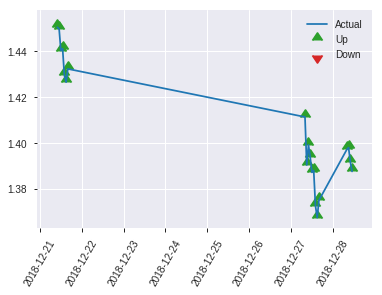


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2560110569353884
RMSE: 0.5059753521026379
LogLoss: 0.7056765052169611
Mean Per-Class Error: 0.4471921263749896
AUC: 0.5057480770821272
pr_auc: 0.5375352178479305
Gini: 0.011496154164254424
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3259308636188507: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    105  0.9813   (105.0/107.0)
1      0    113  0        (0.0/113.0)
Total  2    218  0.4773   (105.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.325931     0.682779  217
max f2                       0.325931     0.843284  217
max f0point5                 0.325931     0.573604  217
max accuracy                 0.542757     0.545455  50
max precision                0.791709     1         0
max recall                   0.325931     1         217
max specificity              0.791709     1         0
max absolute_mcc             0.377191     0.130868  193
max min_per_class_accuracy   0.462223     0.495575  105
max mean_per_class_accuracy  0.542757     0.552808  50

Gains/Lift Table: Avg response rate: 51.36 %, avg score: 47.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.758861           1.29794   1.29794            0.666667         0.774134  0.666667                    0.774134            0.0176991       0.0176991                  29.7935   29.7935
    2        0.0227273                   0.695068           1.9469    1.55752            1                0.718511  0.8                         0.751885            0.0176991       0.0353982                  94.6903   55.7522
    3        0.0318182                   0.656777           0         1.11252            0                0.671677  0.571429                    0.728968            0               0.0353982                  -100      11.2516
    4        0.0409091                   0.641707           0.973451  1.08161            0.5              0.653087  0.555556                    0.712106            0.00884956      0.0442478                  -2.65487  8.16126
    5        0.05                        0.635538           1.9469    1.23894            1                0.637619  0.636364                    0.698563            0.0176991       0.0619469                  94.6903   23.8938
    6        0.1                         0.601419           1.06195   1.15044            0.545455         0.623549  0.590909                    0.661056            0.0530973       0.115044                   6.19469   15.0442
    7        0.15                        0.574139           0.707965  1.00295            0.363636         0.589807  0.515152                    0.637306            0.0353982       0.150442                   -29.2035  0.294985
    8        0.2                         0.555701           1.59292   1.15044            0.818182         0.567141  0.590909                    0.619765            0.079646        0.230088                   59.292    15.0442
    9        0.3                         0.506481           1.06195   1.12094            0.545455         0.528939  0.575758                    0.58949             0.106195        0.336283                   6.19469   12.0944
    10       0.4                         0.478756           0.707965  1.0177             0.363636         0.492878  0.522727                    0.565337            0.0707965       0.40708                    -29.2035  1.76991
    11       0.5                         0.458725           0.884956  0.99115            0.454545         0.468487  0.509091                    0.545967            0.0884956       0.495575                   -11.5044  -0.884956
    12       0.6                         0.433482           1.06195   1.00295            0.545455         0.445898  0.515152                    0.529289            0.106195        0.60177                    6.19469   0.294985
    13       0.7                         0.420053           1.06195   1.01138            0.545455         0.426207  0.519481                    0.514563            0.106195        0.707965                   6.19469   1.1378
    14       0.8                         0.397186           0.79646   0.984513           0.409091         0.410678  0.505682                    0.501577            0.079646        0.787611                   -20.354   -1.54867
    15       0.9                         0.371396           0.79646   0.963618           0.409091         0.385091  0.494949                    0.488634            0.079646        0.867257                   -20.354   -3.63815
    16       1                           0.307835           1.32743   1                  0.681818         0.351747  0.513636                    0.474946    

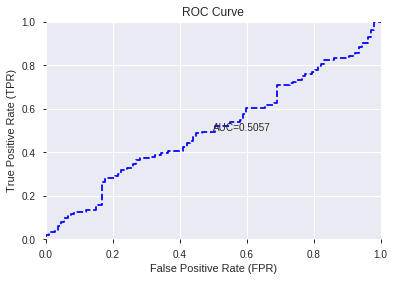

This function is available for GLM models only


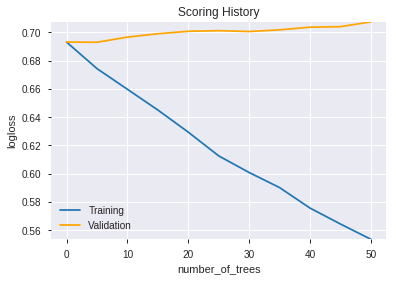

--2019-08-28 20:11:39--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.97.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.97.43|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.calculateChildInclusiveNa(SharedTreeNode.java:133)
	at hex.genmodel.algos.tree.SharedTreeNode.setLeftChild(SharedTreeNode.java:207)
	at hex.genmo

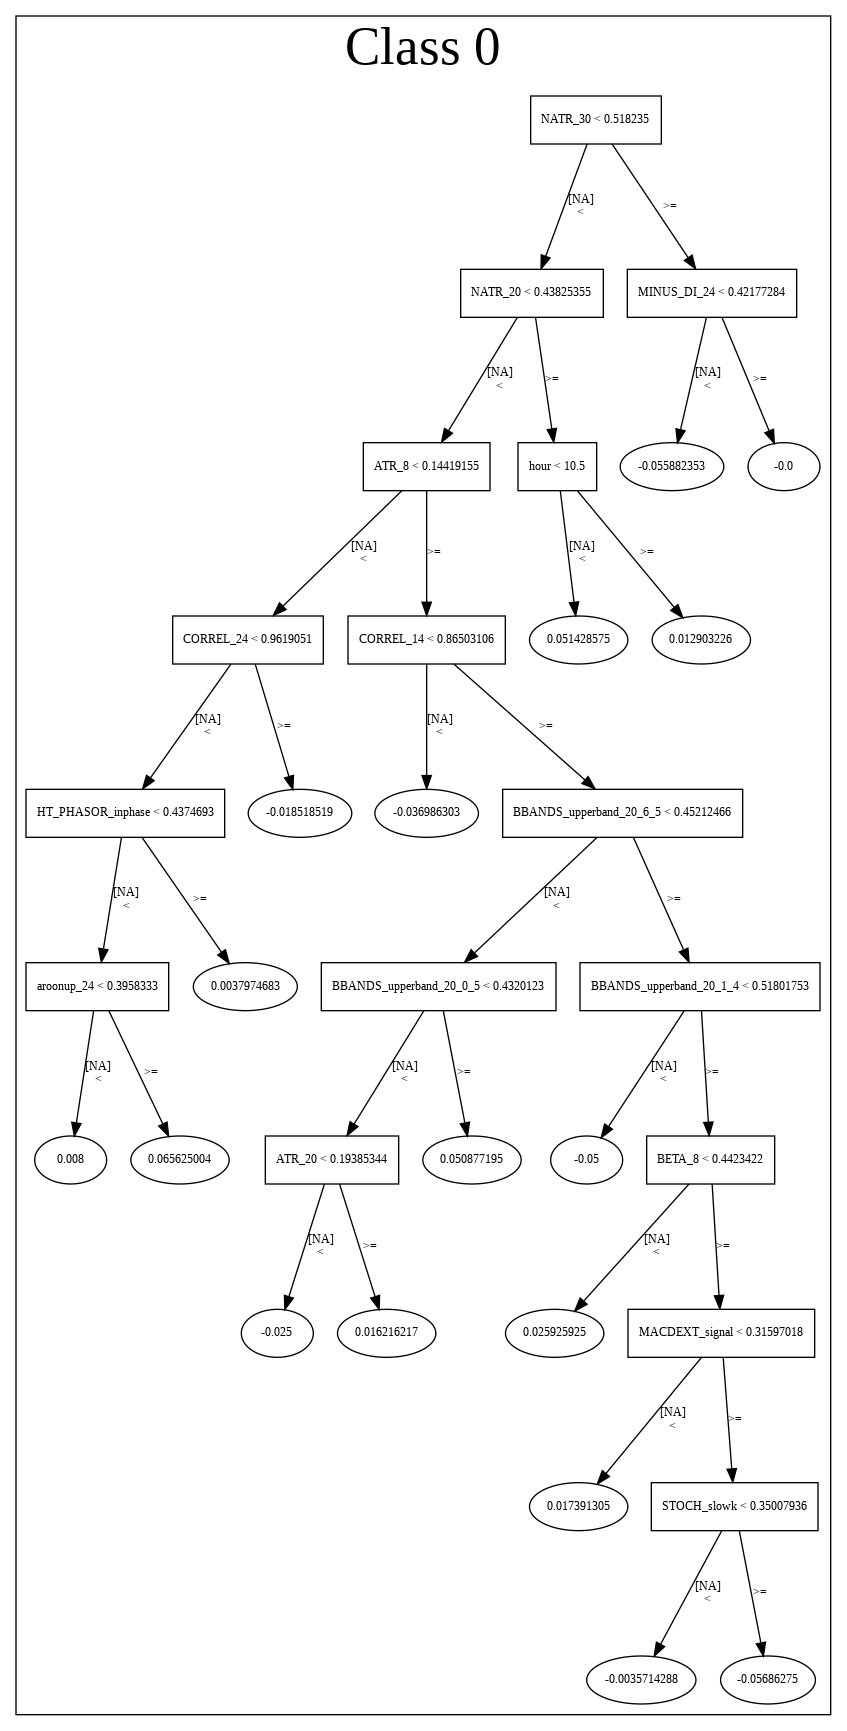

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_201115_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_201115_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_a8f4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['DX_20',
 'VAR_8',
 'MINUS_DM_20',
 'HT_PHASOR_quadrature',
 'MACDFIX_hist_24',
 'MFI_14',
 'BETA_14',
 'BETA_20',
 'CORREL_20',
 'STOCHF_fastk',
 'ATR_12',
 'NATR_8',
 'CORREL_12',
 'CCI_12',
 'MFI_20',
 'MINUS_DM_12',
 'MACDFIX_hist_12',
 'BOP',
 'HT_PHASOR_inphase',
 'ROCP_12',
 'PLUS_DM_24',
 'MFI_24',
 'PLUS_DI_30',
 'CORREL_14',
 'AD',
 'BETA_8',
 'MOM_30',
 'LINEARREG_ANGLE_14',
 'AROONOSC_24',
 'ROC_20',
 'MINUS_DI_14',
 'NATR_24',
 'STDDEV_12',
 'TRANGE',
 'DX_24',
 'ROC_14',
 'DX_14',
 'STOCH_slowd',
 'NATR_30',
 'ATR_14',
 'STDDEV_14',
 'ULTOSC',
 'STOCHRSI_fastd',
 'STOCHRSI_fastk',
 'MACDFIX_8',
 'ADX_24',
 'APO',
 'PLUS_DM_14',
 'MACDFIX_hist_20',
 'NATR_12',
 'NATR_20',
 'MACDFIX_signal_14',
 'MINUS_DM_24',
 'ADX_14',
 'PLUS_DI_14',
 'MACDFIX_signal_12',
 'ROCR_20',
 'SAR_0.2',
 'MINUS_DI_12',
 'CCI_8',
 'BBANDS_lowerband_24_3_5',
 'BBANDS_lowerband_14_4_2',
 'aroonup_12',
 'WILLR_24',
 'MAVP_14_4',
 'PLUS_DM_20',
 'BBANDS_upperband_24_2_4',
 'LINEARREG_INTERCEPT_14',
 

In [54]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [55]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.609
GLM             0.555
XGBoost         0.559
dtype: float64

DeepLearning    GLM  XGBoost
All          0.609  0.555    0.559
DLF          0.550  0.541    0.536
Fwe          0.582  0.555    0.559
RFE          0.568  0.532    0.545
XGBF         0.564  0.541    0.536





F1


DeepLearning    0.692
GLM             0.683
XGBoost         0.683
dtype: float64

DeepLearning    GLM  XGBoost
All          0.687  0.679    0.679
DLF          0.683  0.683    0.681
Fwe          0.692  0.679    0.679
RFE          0.687  0.683    0.683
XGBF         0.689  0.683    0.681





auc


DeepLearning    0.615
GLM             0.516
XGBoost         0.532
dtype: float64

DeepLearning    GLM  XGBoost
All          0.615  0.516    0.532
DLF          0.541  0.512    0.507
Fwe          0.568  0.516    0.532
RFE          0.544  0.490    0.506
XGBF         0.541  0.512    0.507





logloss


DeepLearning    1.605
GLM             0.694
XGBoost         0.707
dtype: float64

DeepLearning    GLM  XGBoost
All          0.675  0.692    0.702
DLF          0.818  0.693    0.707
Fwe          1.605  0.692    0.702
RFE          0.765  0.694    0.706
XGBF         0.890  0.693    0.707





mean_per_class_error


DeepLearning    0.447
GLM             0.463
XGBoost         0.462
dtype: float64

DeepLearning    GLM  XGBoost
All          0.388  0.439    0.438
DLF          0.447  0.463    0.462
Fwe          0.418  0.439    0.438
RFE          0.432  0.459    0.447
XGBF         0.439  0.463    0.462





rmse


DeepLearning    0.598
GLM             0.500
XGBoost         0.507
dtype: float64

DeepLearning  GLM  XGBoost
All          0.491  0.5    0.504
DLF          0.541  0.5    0.507
Fwe          0.598  0.5    0.504
RFE          0.525  0.5    0.506
XGBF         0.556  0.5    0.507





mse


DeepLearning    0.358
GLM             0.250
XGBoost         0.257
dtype: float64

DeepLearning   GLM  XGBoost
All          0.241  0.25    0.254
DLF          0.293  0.25    0.257
Fwe          0.358  0.25    0.254
RFE          0.276  0.25    0.256
XGBF         0.309  0.25    0.257

{'F1':       DeepLearning    GLM  XGBoost
 All          0.687    NaN      NaN
 DLF          0.683    NaN      NaN
 DLF            NaN  0.683      NaN
 DLF            NaN    NaN    0.681
 All            NaN  0.679      NaN
 All            NaN    NaN    0.679
 XGBF         0.689    NaN      NaN
 XGBF           NaN  0.683      NaN
 XGBF           NaN    NaN    0.681
 Fwe          0.692    NaN      NaN
 Fwe            NaN  0.679      NaN
 Fwe            NaN    NaN    0.679
 RFE          0.687    NaN      NaN
 RFE            NaN  0.683      NaN
 RFE            NaN    NaN    0.683,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.609    NaN      NaN
 DLF          0.550    NaN      NaN
 DLF            NaN  0.541      NaN
 DLF            NaN    NaN    0.536
 All            NaN  0.555      NaN
 All            NaN    NaN    0.559
 XGBF         0.564    NaN      NaN
 XGBF           NaN  0.541      NaN
 XGBF           NaN    NaN    0.536
 Fwe          0.582    NaN      NaN
 Fwe     